In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import gym
import numpy as np
from IPython.display import display, clear_output   
from time import sleep

In [5]:
policy_y = np.array([[0, 3, 0, 0, 0]
, [0, 0, 0, 3, 0]
, [0, 3, 3, 3, 3]
, [0, 1, 3, 1, 1]
, [0, 1, 1, 1, 3]])
policy_g = np.array([[2, 0, 2, 2, 0]
, [2, 0, 1, 1, 1]
, [2, 2, 1, 1, 1]
, [1, 2, 1, 2, 1]
, [1, 1, 1, 2, 1]])
policy_r = np.array([[0, 3, 0, 3, 3]
, [1, 1, 0, 3, 0]
, [1, 1, 3, 3, 3]
, [1, 1, 1, 1, 1]
, [1, 1, 3, 1, 1]])
policy_b = np.array([[0, 0, 0, 0, 0]
, [2, 0, 2, 0, 0]
, [2, 2, 2, 0, 0]
, [1, 1, 1, 0, 0]
, [1, 2, 1, 0, 3]])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
env = gym.make("Taxi-v3")

/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [7]:
def average_episode_time(Q):
  steps = []
  trajectories_ep = []
  for i in range(1000):
    state = env.reset()
    done = False
    t = 0
    trajectory = []
    while not done:
      action = np.argmax(Q[state])
      if action<6:
        next_state,reward,done,_ = env.step(action)
        trajectory.append([state,action,next_state,reward,False])
        state = next_state
        t+=1
      if action>=6:
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = options[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction)
          trajectory.append([state,optaction,next_state,reward,True])
          t+=1
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          if next_state_is_terminal:
            optdone = True
          state = next_state
    steps.append(t)
    trajectories_ep.append(trajectory)


  print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
  return(np.array(steps).mean()),steps,trajectories_ep

In [9]:
def SMDP_Learning(ALPHA,GAMMA,EPS,NUM_EPS):
  
  actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
  termination_dict = {6:20,7:4,8:0,9:23}
  options             = [None,None,None,None,None,None,policy_y,policy_g,policy_r,policy_b]
  Q_SMDP = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_SMDP_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_SMDP = []
  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    rewards = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      r = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        if action<6:
          next_state,reward,done,_ = env.step(action)
          r+=reward
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = options[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            r+=reward
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      rewards.append(r)
      trajectories_ep.append(trajectory)


    #print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
    return(np.array(steps).mean()),(np.array(rewards).mean()),steps,trajectories_ep
  def return_action(state,epsilon,Q):
    if np.random.rand()>eps:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]
  # While episode is not over
  # Iterate over 1000 episodes
  ep_steps = []
  for ep in range(int(NUM_EPS)):
      #print(ep)
      state = env.reset()    
      done = False
      r = 0
      t = 0
      # While episode is not over
      while not done:
      
          eps = max((0.99**ep)*0.9,EPS)
          # Choose action        
          action = return_action(state,eps,Q_SMDP)
          
          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair
              next_state, reward, done,_ = env.step(action)
              #r+= gamma**(tmax-1) * reward
              r+=reward
              t +=1
              update = reward + gamma * max(Q_SMDP[next_state]) - Q_SMDP[state][action]
              Q_SMDP[state][action] +=  alpha*(update)
              Update_Frequency_SMDP_q_learning[state][action] += 1
              state = next_state
          
          # Checking if action chosen is an option
          
          if action>=6:
            reward_bar = 0
            current_state = state
            optdone = False
            tau = 0
            done_ = False
            while (optdone==False):
              taxi_row,taxi_col,_,_  = env.decode(state)
              optaction = options[action][taxi_row][taxi_col]
              next_state,reward,done,_ = env.step(optaction)
              tau +=1
              t+=1
              reward_bar = reward_bar + (gamma**(tau-1))*reward
              state = next_state
              row_t_1,col_t_1,_,_ = env.decode(next_state)
              next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
              if next_state_is_terminal:
                optdone = True
            update = reward_bar + (gamma**(tau) * max(Q_SMDP[state])) - Q_SMDP[current_state][action]
            Q_SMDP[current_state][action] +=  alpha * update
            #r+= gamma**(tmax-1) * reward_bar
            r+=reward_bar
            Update_Frequency_SMDP_q_learning[current_state][action] += 1
      cumul_reward_SMDP.append(r)      
      ep_steps.append(t)    

  
  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_SMDP_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_SMDP,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("SMDP ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_SMDP)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  
  mean_steps,mean_reward,_,_ =  average_episode_time(Q_SMDP)
  return mean_steps,mean_reward
  


In [10]:
def Q_intra_option_Q_learning(ALPHA,GAMMA,EPS,NUM_EPS):
  actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
  termination_dict = {6:20,7:4,8:0,9:23}
  options             = [None,None,None,None,None,None,policy_y,policy_g,policy_r,policy_b]
  Q_intra_option_Q = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_intra_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_intra = []
  def return_action(state,epsilon,Q):
    if np.random.rand()>eps:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]
  def average_episode_time(Q):
    steps = []
    rewards= []
    trajectories_ep = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      r = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        if action<6:
          next_state,reward,done,_ = env.step(action)
          r+=reward
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1

        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = options[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            r+=reward
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      rewards.append(r)
      trajectories_ep.append(trajectory)


    #print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
    return(np.array(steps).mean()),(np.array(rewards).mean()),steps,trajectories_ep
  def update_intraoption_action(state,action,next_state,reward): #here action is a primitive action
    Q_intra_option_Q[state][action] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][action])
    Update_Frequency_intra_q_learning[state][action] +=1 
    row_t,col_t,_,_ = env.decode(state)
    row_t_1,col_t_1,_,_ = env.decode(next_state)
    
    for option in range(6,10):
      optaction  = options[option][row_t][col_t]
      next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[option] else False 
      if optaction == action:
        if next_state_is_terminal == False:
          Q_intra_option_Q[state][option] += alpha*(reward + (gamma*Q_intra_option_Q[next_state][option]) - Q_intra_option_Q[state][action])
          Update_Frequency_intra_q_learning[state][option] += 1  
        else:
          Q_intra_option_Q[state][option] += alpha*(reward + gamma*max(Q_intra_option_Q[next_state]) - Q_intra_option_Q[state][option])
          Update_Frequency_intra_q_learning[state][option] += 1  

  for ep in range(int(NUM_EPS)):
    state = env.reset()
    done = False
    tmax = 0
    r = 0
    while not done:
      eps = max((0.99**ep)*0.9,EPS)
      action = return_action(state,eps,Q_intra_option_Q)
      if action <6:
        next_state,reward,done,_ = env.step(action)
        r+= gamma**(tmax-1) * reward
        tmax+=1
        update_intraoption_action(state,action,next_state,reward)
        state = next_state
        #print(state,action,next_state,reward)
      if action>=6:
        #print("current_option: ",action)
        optdone = False
        while not optdone:

          row_t,col_t,_,_ = env.decode(state)
          optaction = options[action][row_t][col_t] 
          next_state,reward,done,_ = env.step(optaction) 
          r+= gamma**(tmax-1) * reward
          tmax+=1
          update_intraoption_action(state,optaction,next_state,reward)
          state= next_state
          row_t_1,col_t_1,_,_ = env.decode(next_state)
          next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
          #print(state,optaction,next_state,reward,termination_dict[action])
          if next_state_is_terminal:
            optdone = True
    cumul_reward_intra.append(r)

  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_intra_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_intra_option_Q,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Intra_option ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_intra)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward_intra ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  mean_steps,mean_reward,_,_ =  average_episode_time(Q_intra_option_Q)
  return mean_steps,mean_reward



In [11]:
!pip install wandb 
import wandb
!wandb login --relogin

import pprint
import numpy as np

sweep_config = {
    'method': 'bayes'
}

metric = {
    'name' : 'Average steps SMDP Q learning',
    'goal' : 'minimize'
}
sweep_config['metric'] = metric

parameters_dict ={
    'NUM_EPISODES': {
      'values': [1e3,5e3,1e4,5e4,1e5]
    }

    }
sweep_config['parameters'] = parameters_dict

import math
parameters_dict.update({
    'LR': {
      'values': [1e-2,1e-1,0.2,0.3,0.5,0.8]
      },
    'EPS': {
      'distribution': 'uniform',
      'max': 0.3,
      'min': 0.05
      }
  
    })

pprint.pprint(sweep_config)

sweep_id = wandb.sweep(sweep_config, project="SMDP_Q Learning")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
{'method': 'bayes',
 'metric': {'goal': 'minimize', 'name': 'Average steps SMDP Q learning'},
 'parameters': {'EPS': {'distribution': 'uniform', 'max': 0.3, 'min': 0.05},
                'LR': {'values': [0.01, 0.1, 0.2, 0.3, 0.5, 0.8]},
                'NUM_EPISODES': {'values': [1000.0,
                                            5000.0,
                                            10000.0,
                                            50000.0,
                                            100000.0]}}}
Create sweep with ID: 4ecde2x7
Sweep URL: https://wandb.

In [12]:
def train(config = None):
  with wandb.init(config = config):
    config = wandb.config
    LR = config.LR               ## learning rate 
    NUM_EPS = config.NUM_EPISODES
    EPS = config.EPS
    num_steps,mean_reward = SMDP_Learning(LR,0.9,EPS,NUM_EPS)
    print("Avergae reward the agent earned on an average of 1000 episodes: ",mean_reward)
    wandb.log({'Average steps SMDP Q learning':num_steps})

wandb: Agent Starting Run: nfzklslt with config:
wandb: 	EPS: 0.12022898031245607
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 5000
wandb: Currently logged in as: me19b190. Use `wandb login --relogin` to force relogin


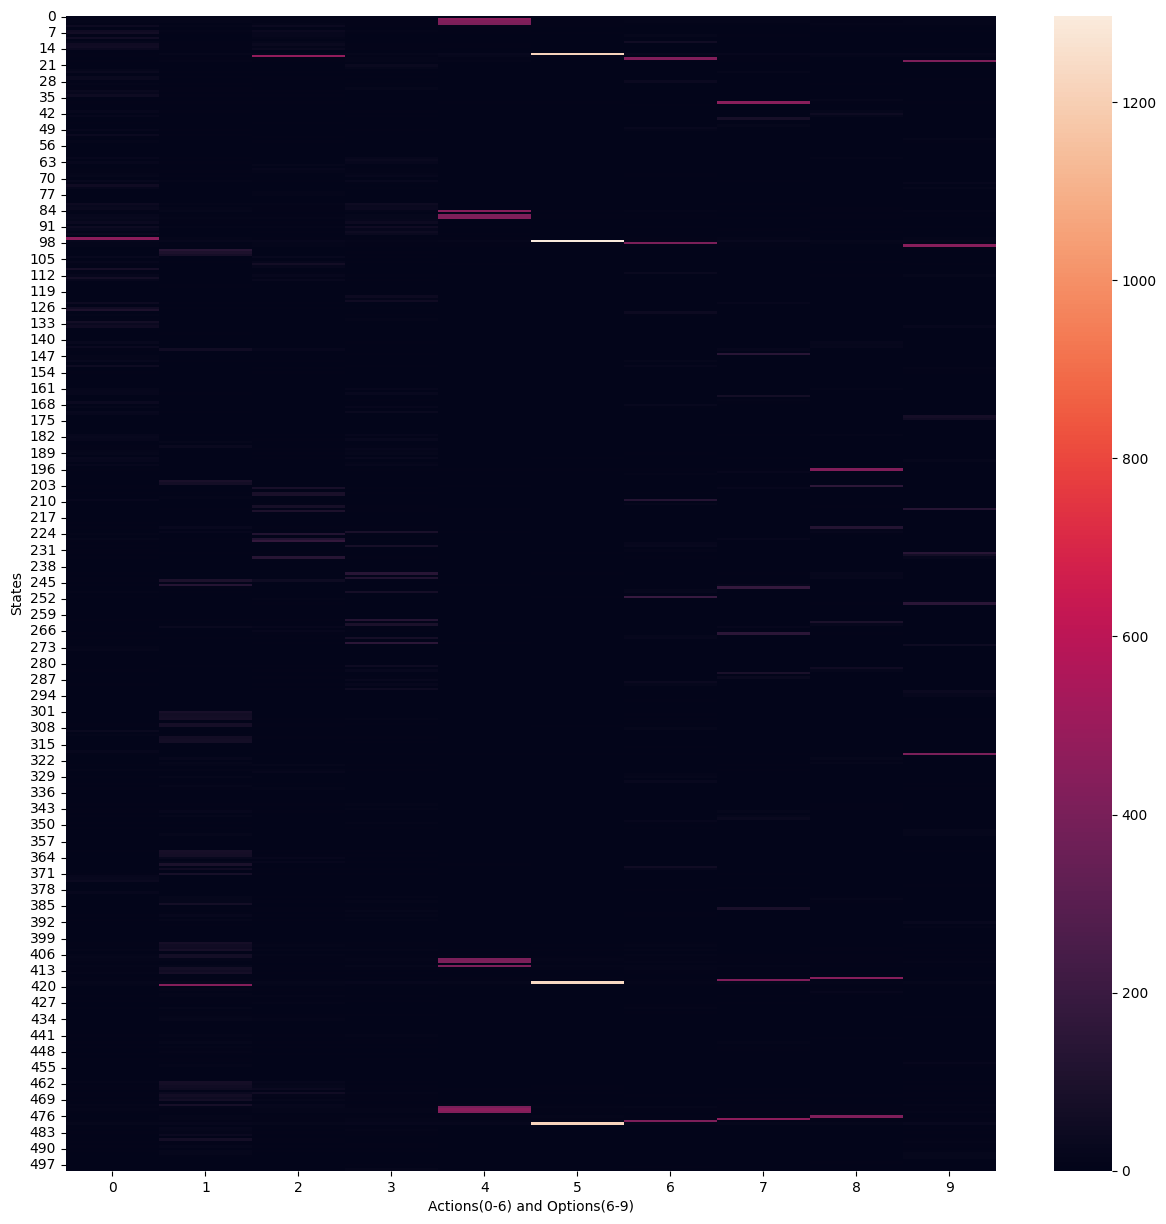

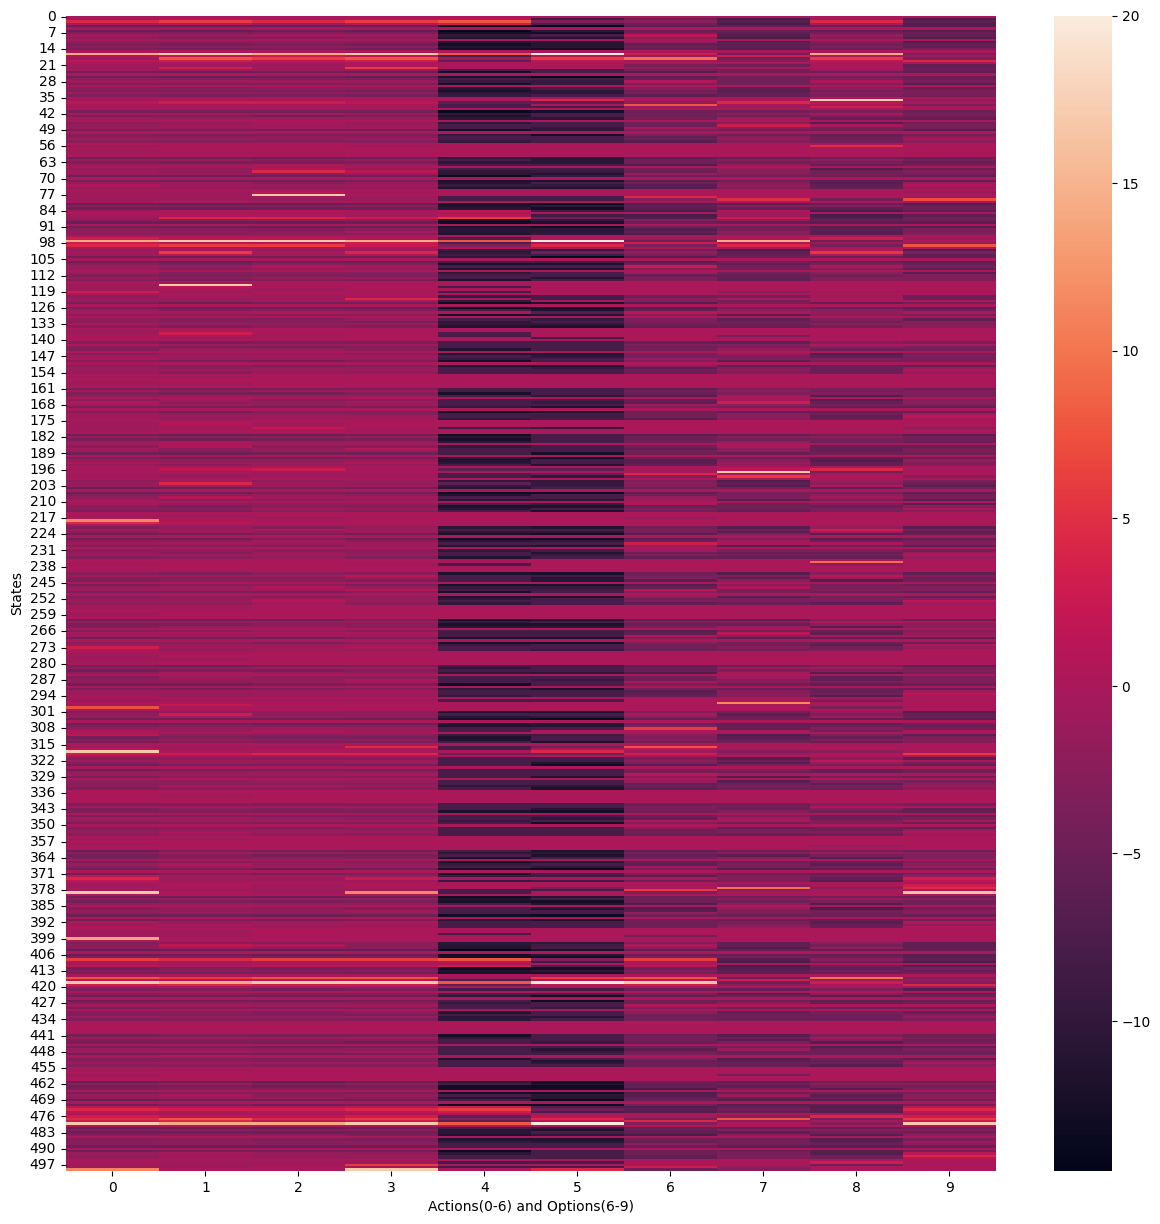

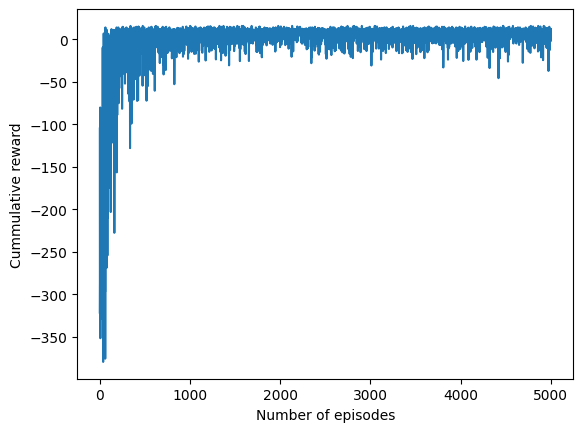

Avergae reward the agent earned on an average of 1000 episodes:  7.843


wandb: Agent Starting Run: reiqyhy3 with config:
wandb: 	EPS: 0.0558368723853163
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 1000


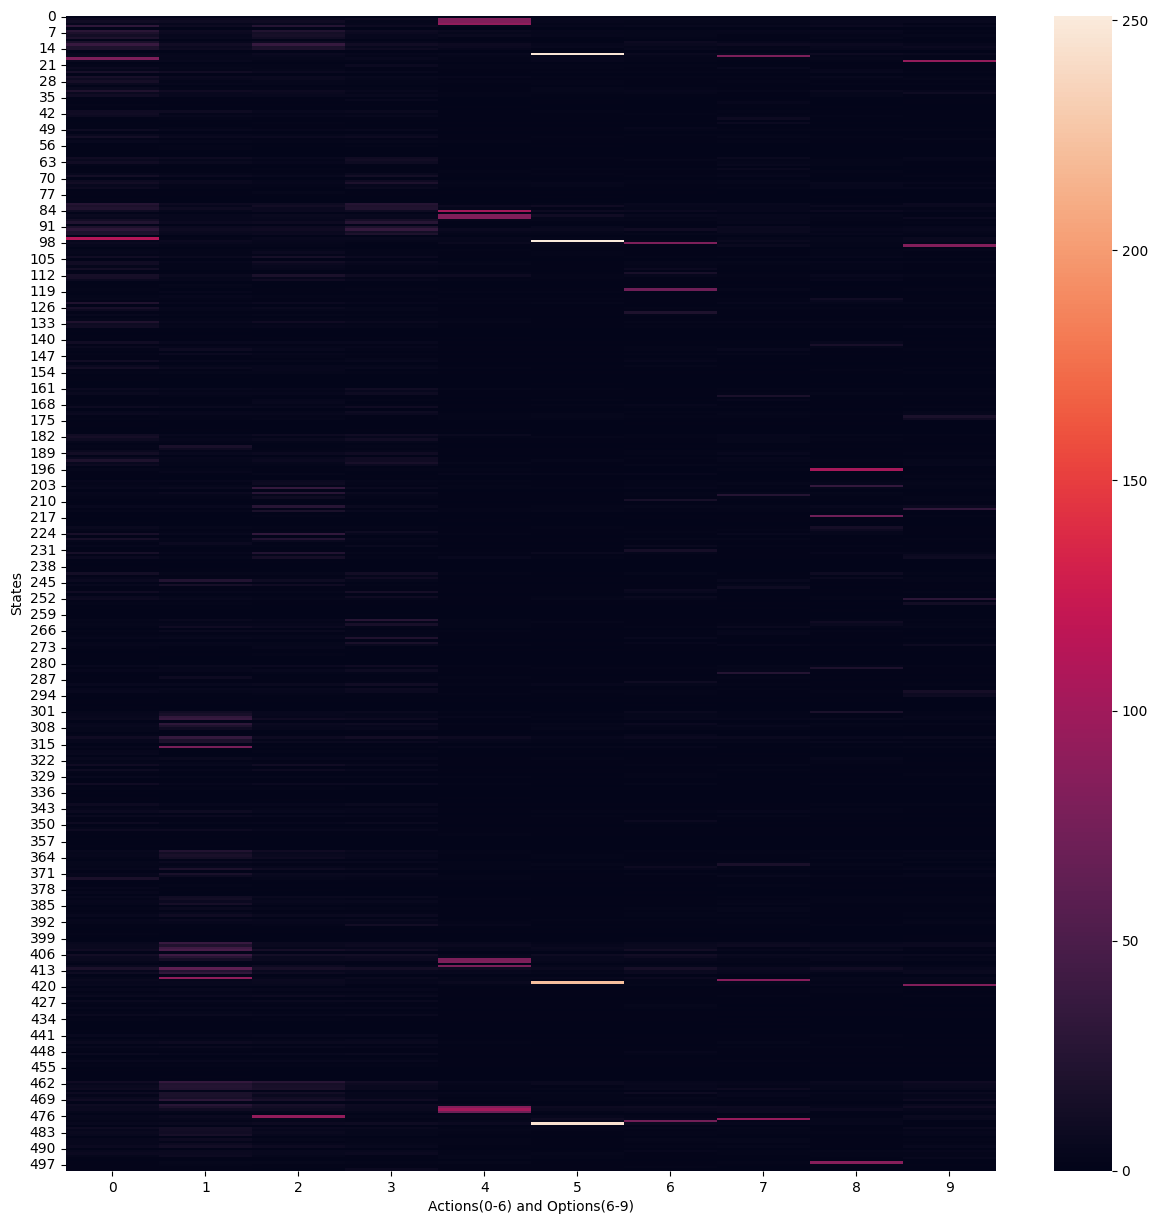

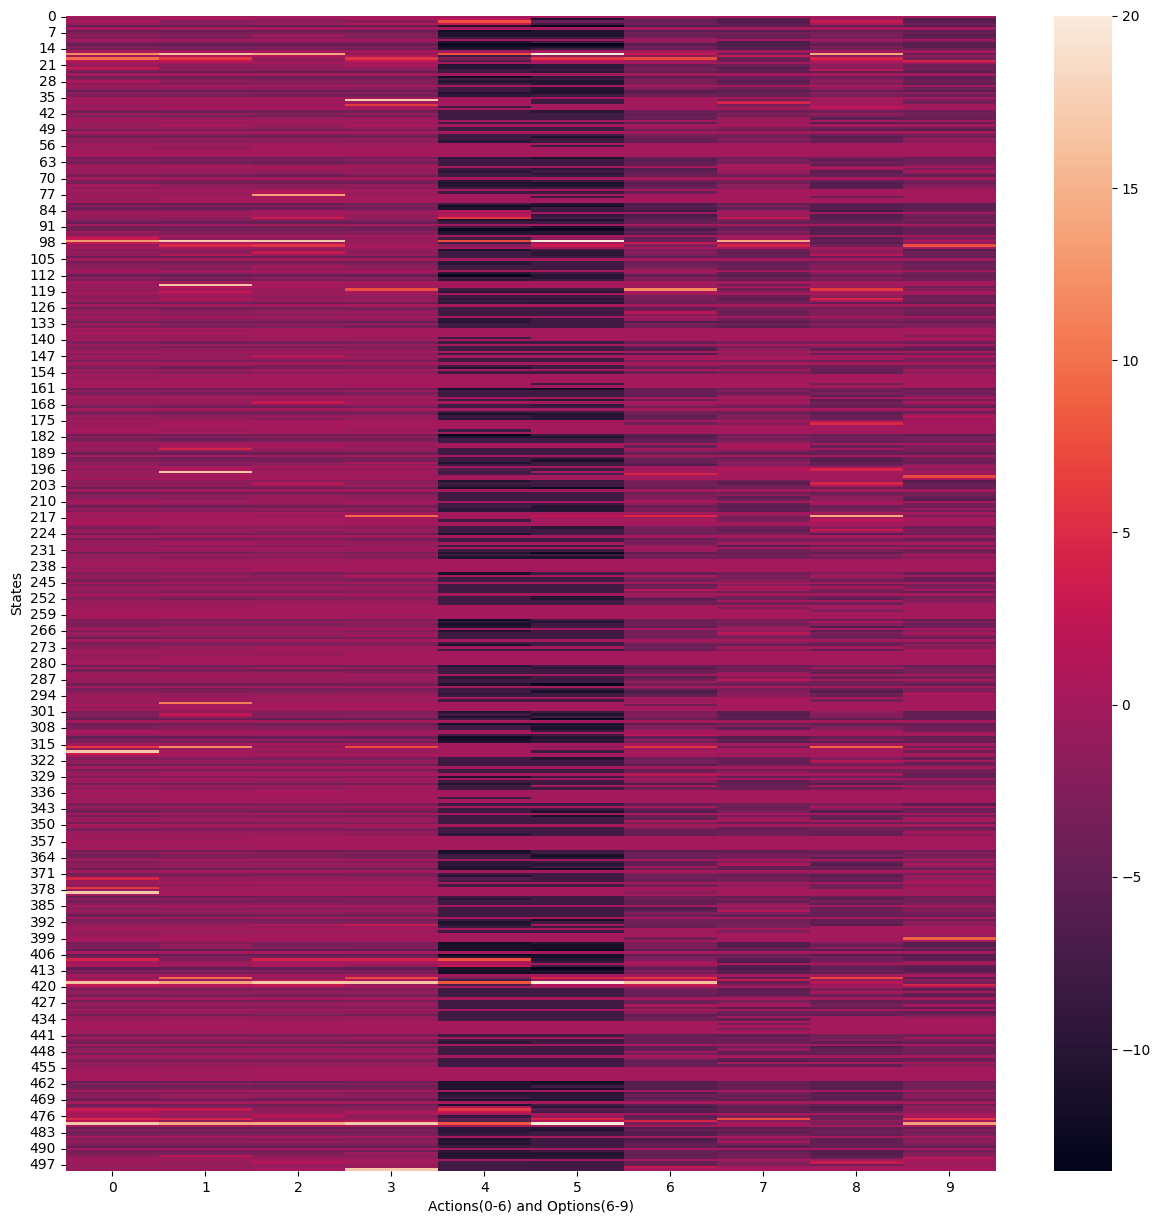

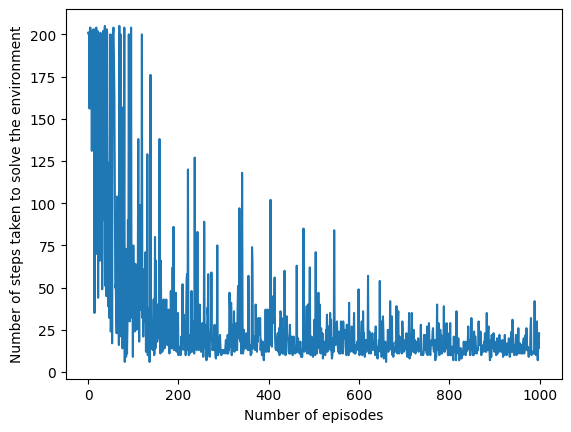

Avergae reward the agent earned on an average of 1000 episodes:  -29.81


wandb: Agent Starting Run: 5ey8t2wp with config:
wandb: 	EPS: 0.0788888517095326
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 5000


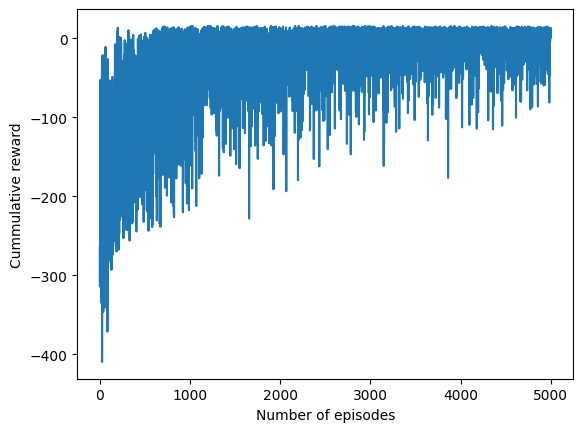

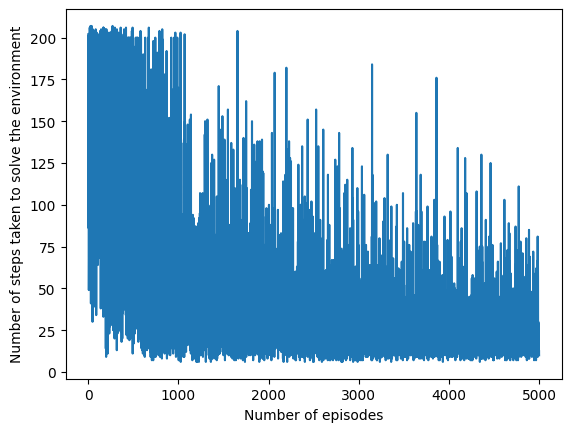

Avergae reward the agent earned on an average of 1000 episodes:  -198.831


wandb: Agent Starting Run: 92infrg0 with config:
wandb: 	EPS: 0.1595263994559733
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 10000


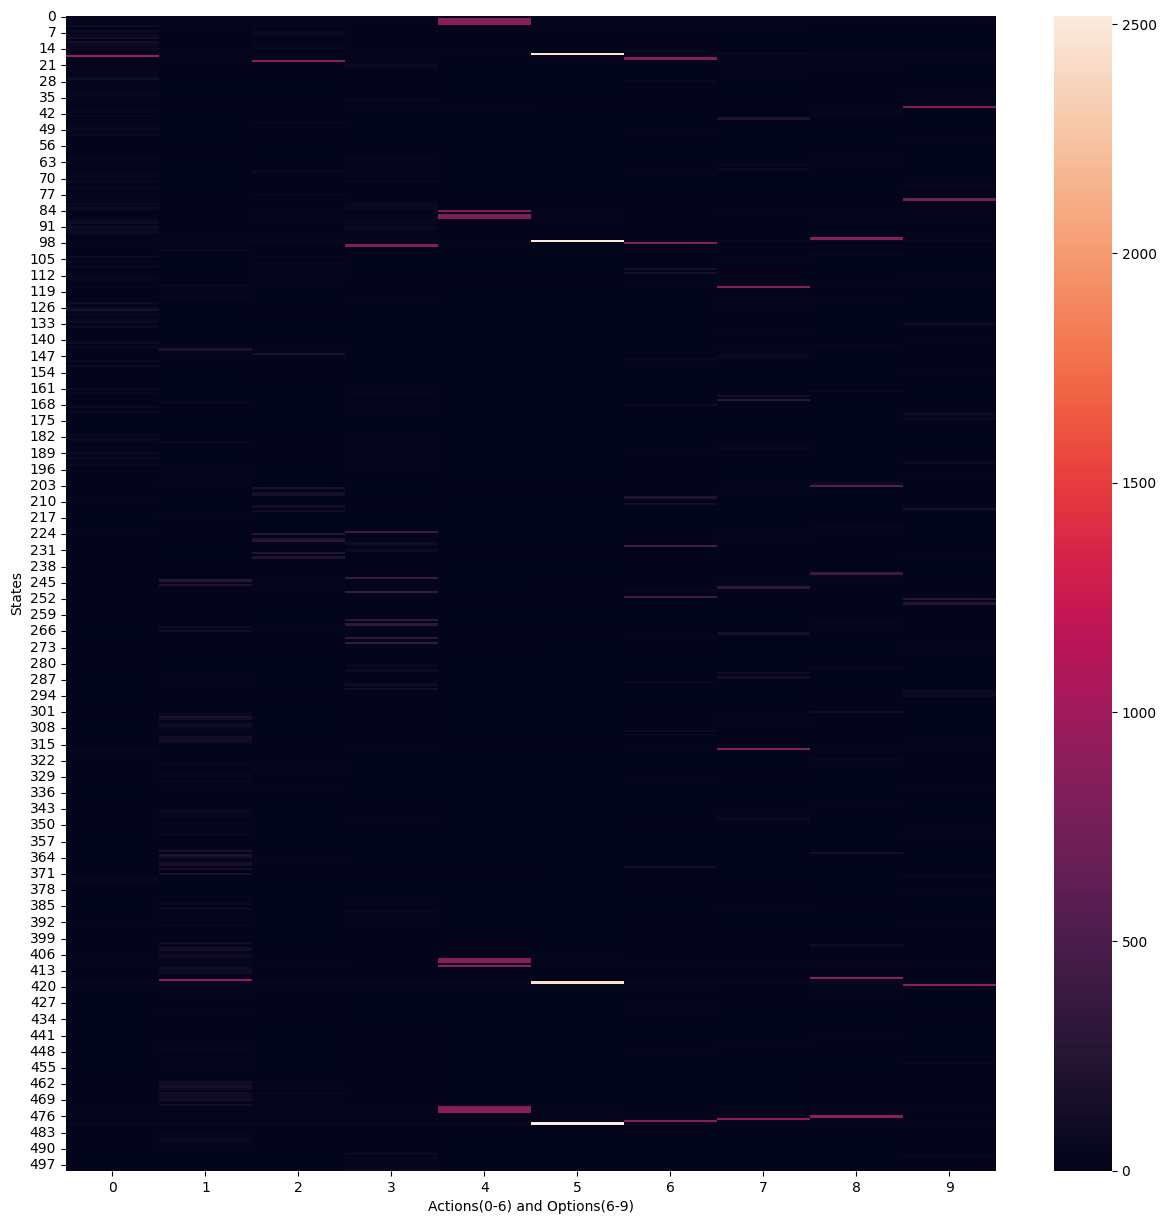

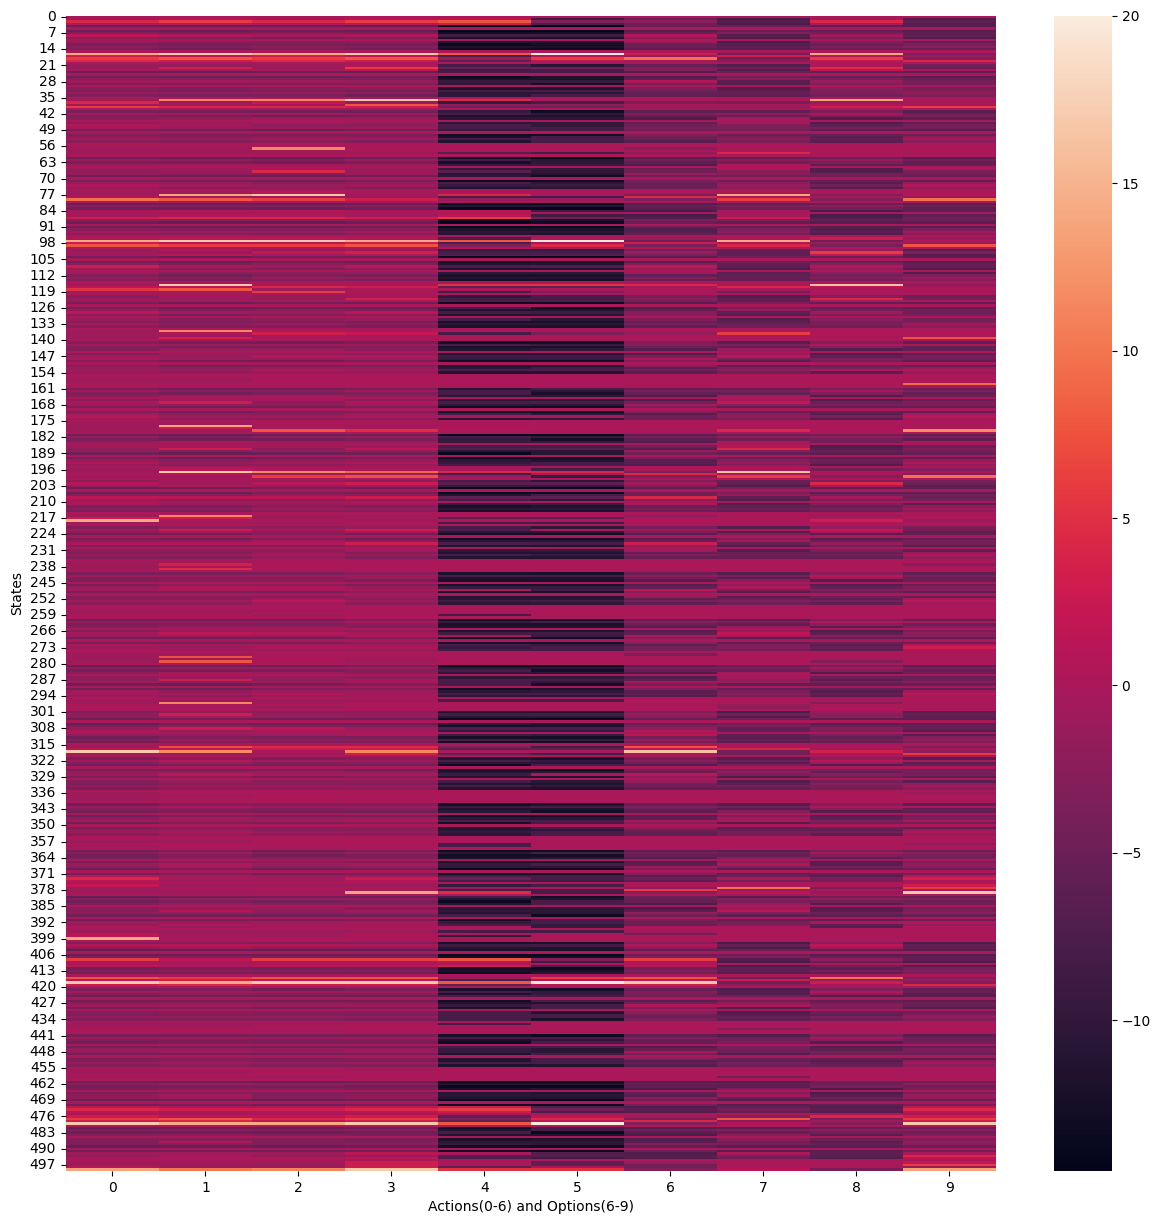

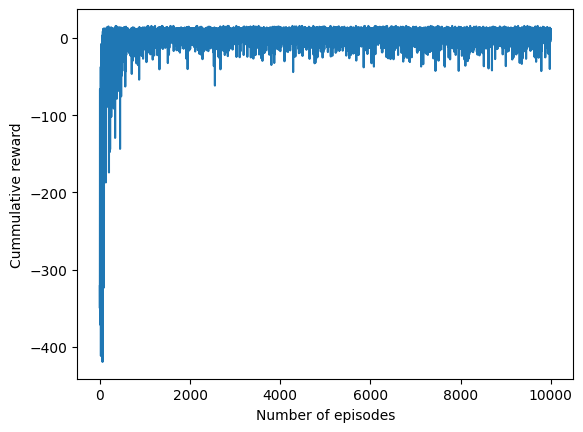

Avergae reward the agent earned on an average of 1000 episodes:  7.863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i0wzh1fg with config:
wandb: 	EPS: 0.21621406252944003
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 5000


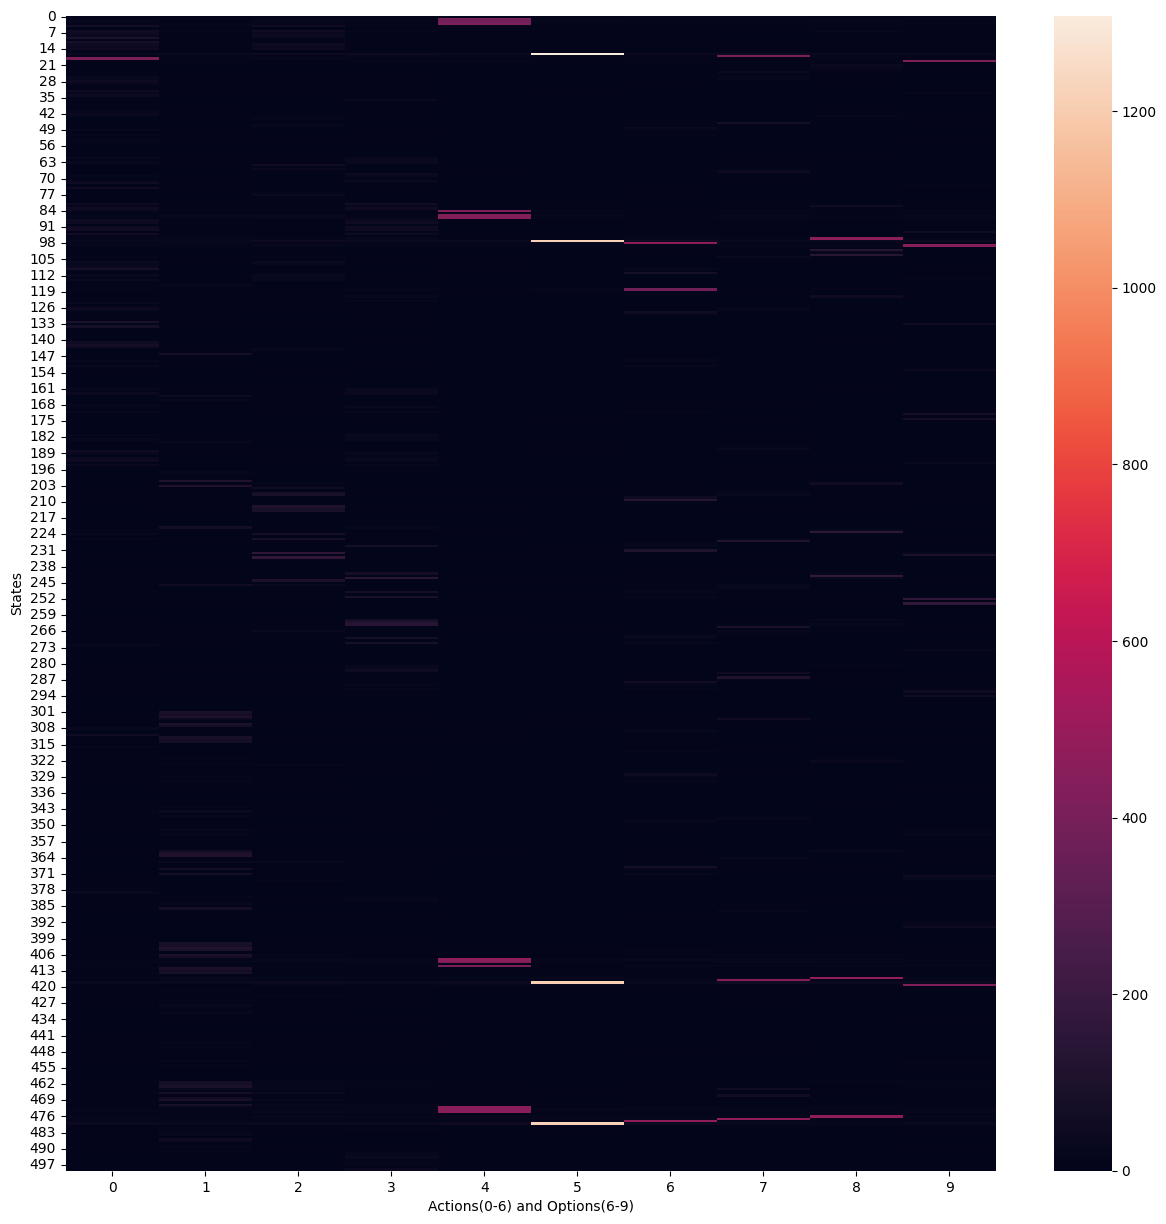

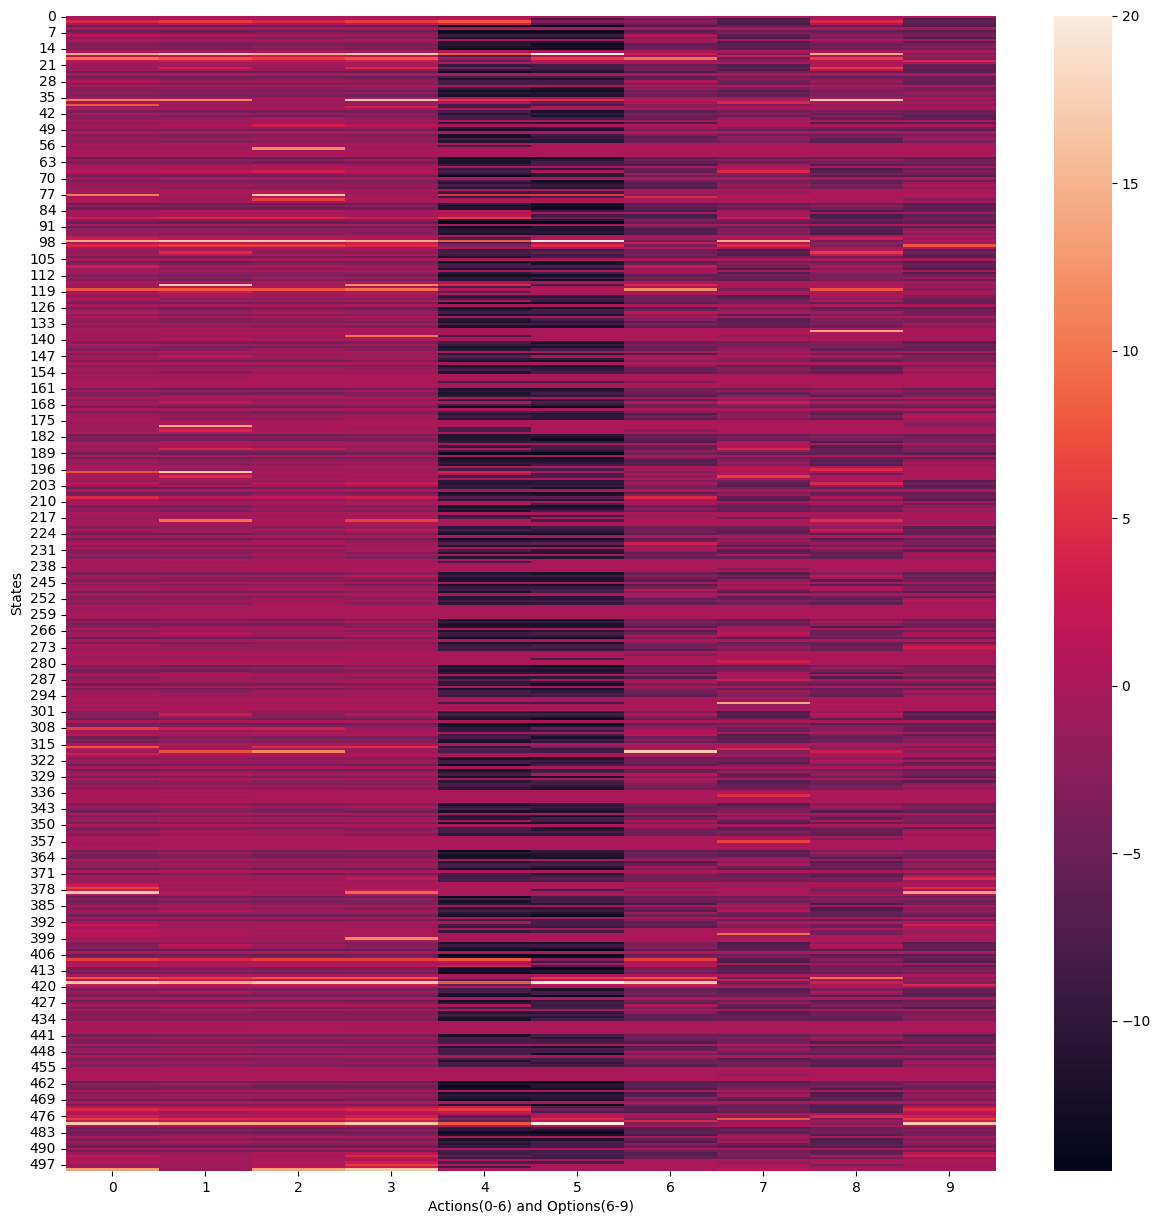

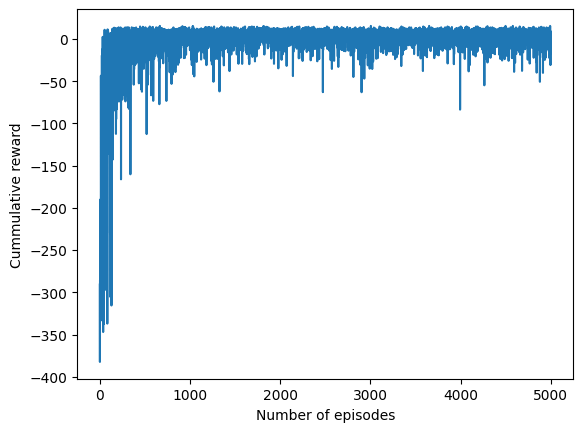

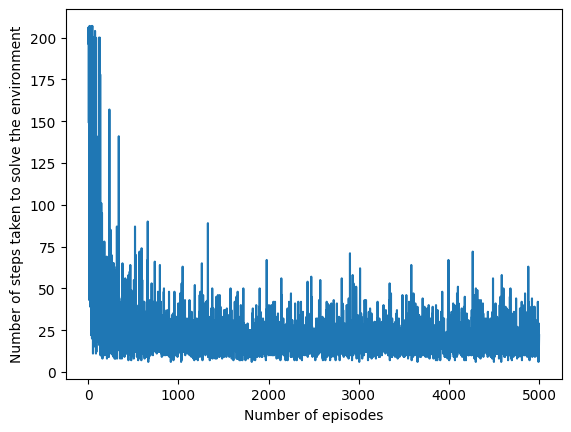

Avergae reward the agent earned on an average of 1000 episodes:  7.788


wandb: Agent Starting Run: d6mmlg4g with config:
wandb: 	EPS: 0.28368555693843434
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


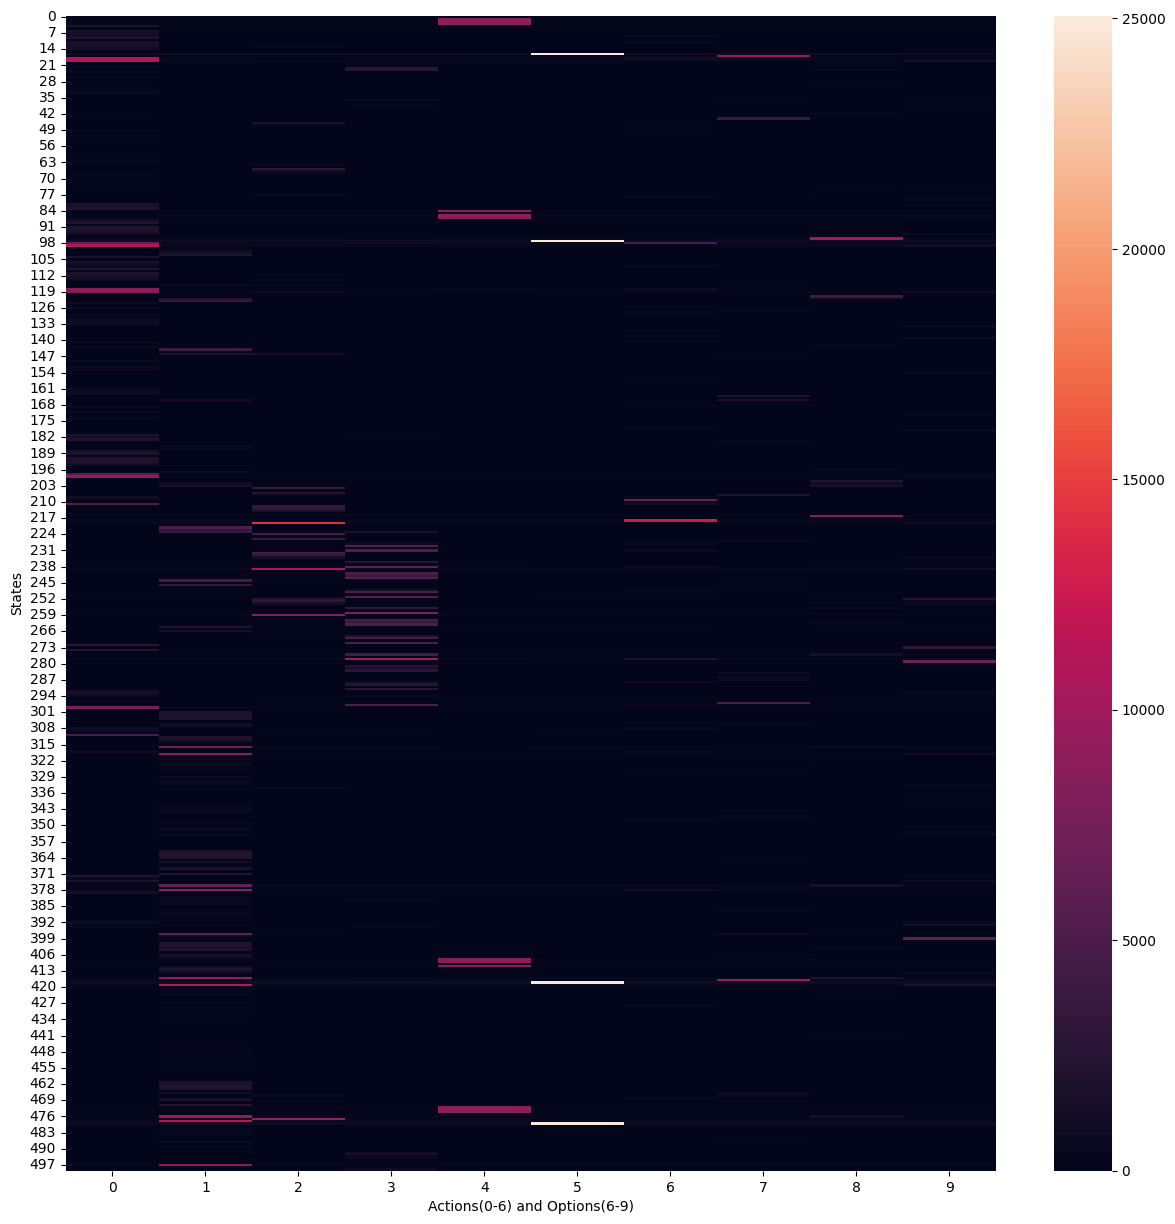

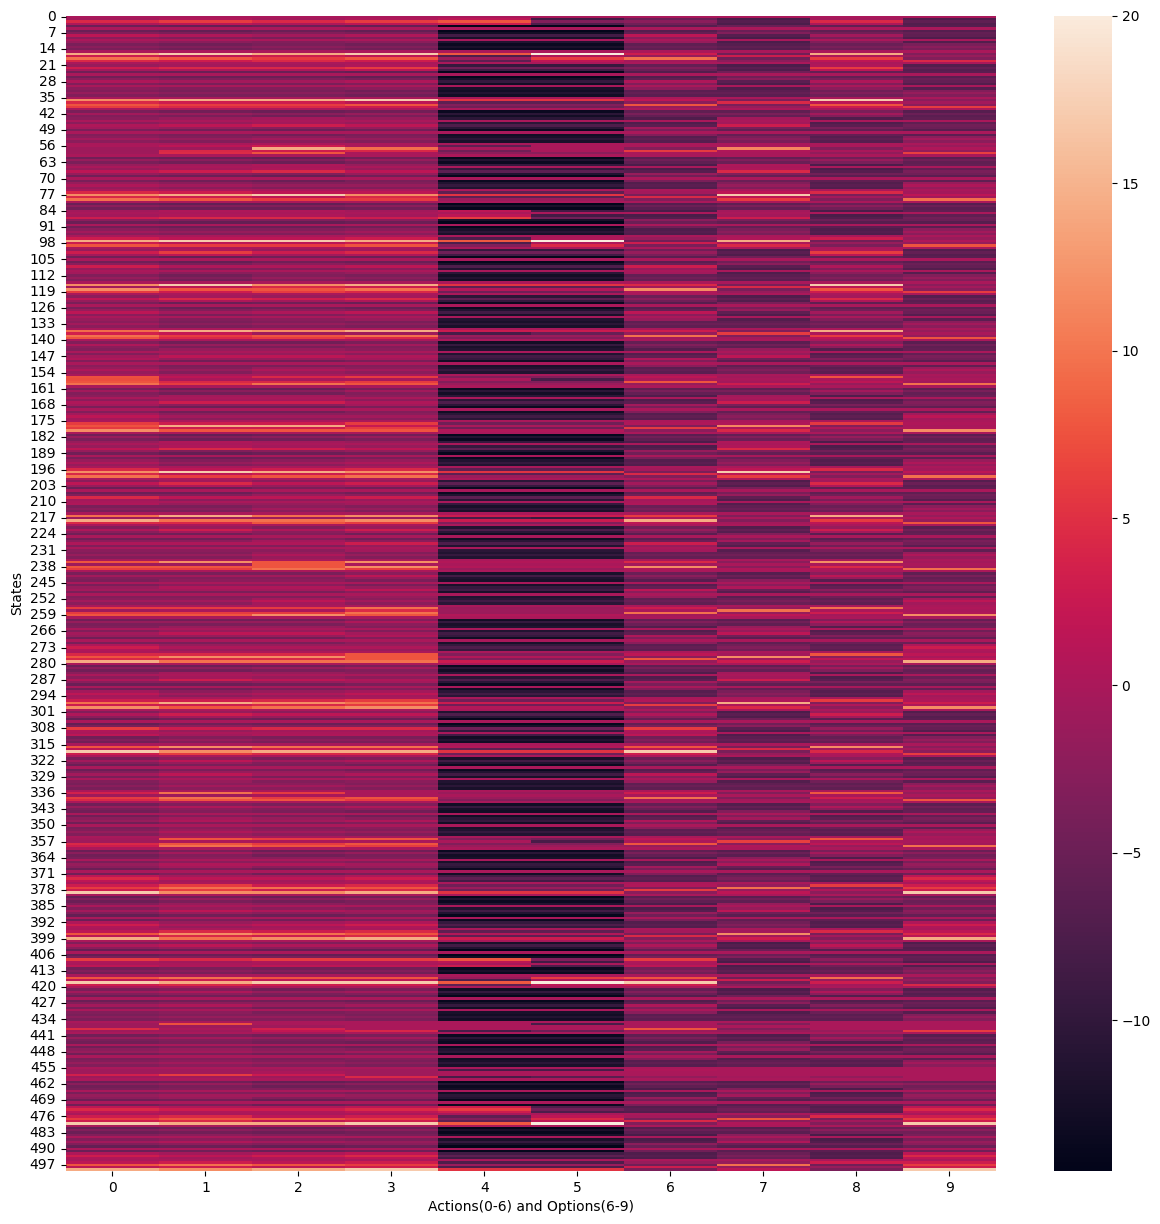

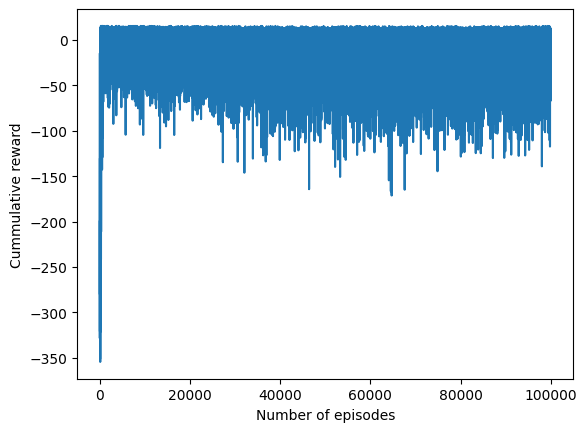

Avergae reward the agent earned on an average of 1000 episodes:  7.847


wandb: Agent Starting Run: 3mu2p1uq with config:
wandb: 	EPS: 0.2903902216526567
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 50000


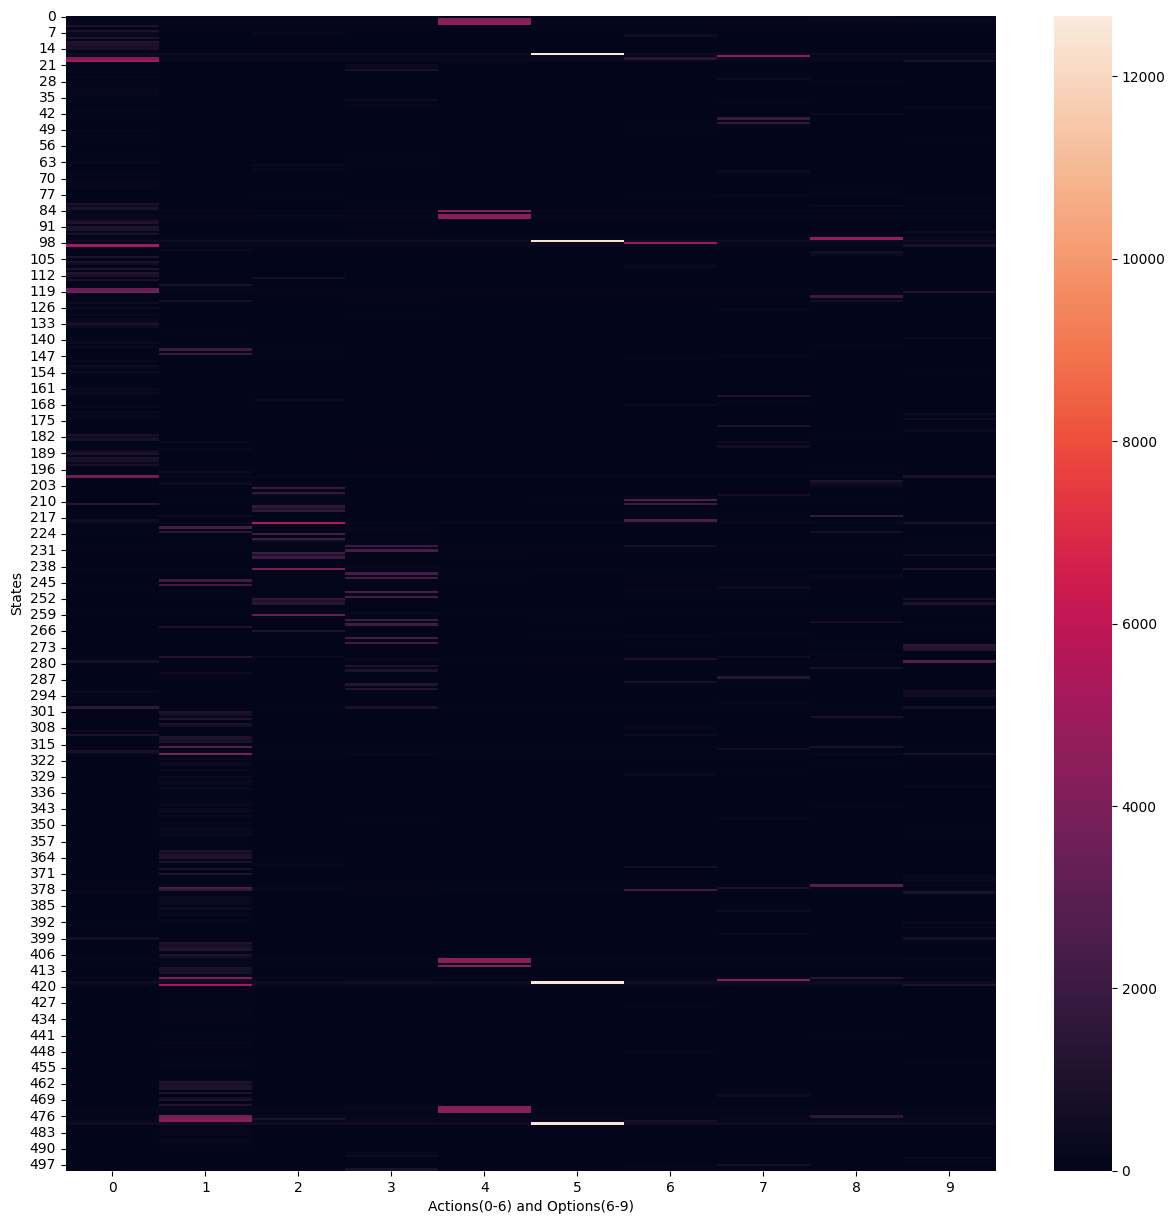

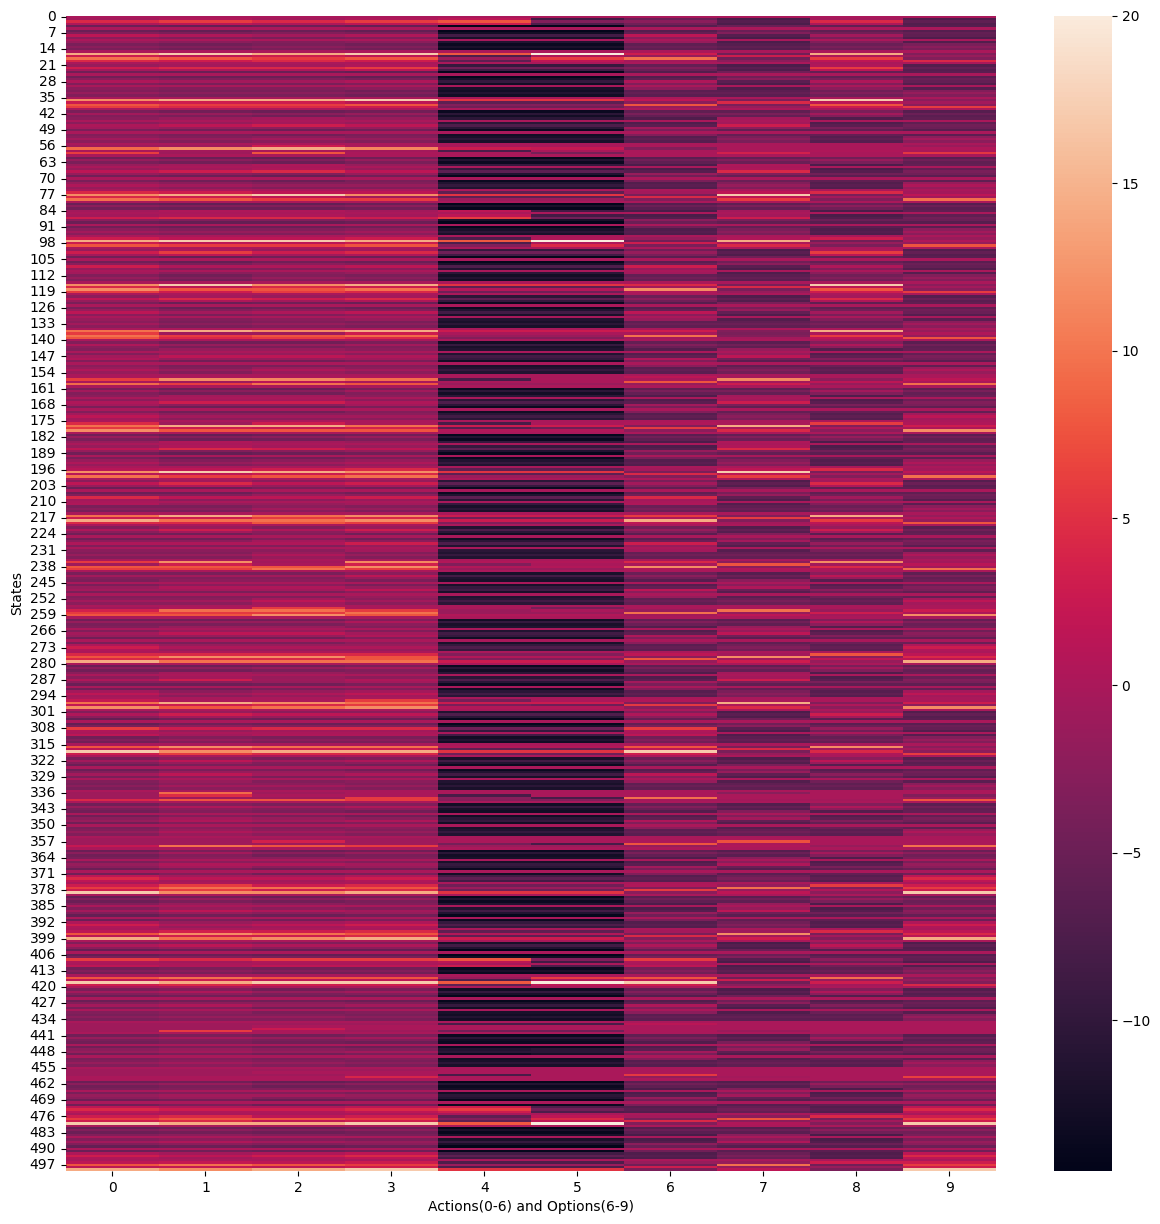

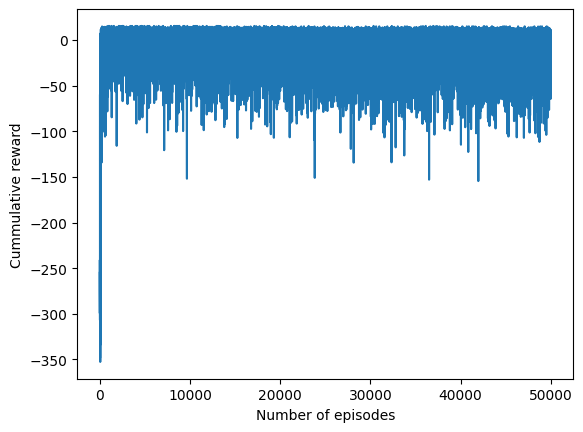

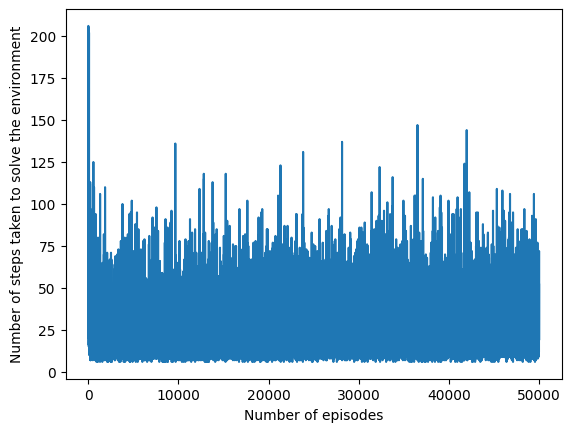

Avergae reward the agent earned on an average of 1000 episodes:  8.031


wandb: Agent Starting Run: fwtu3ls0 with config:
wandb: 	EPS: 0.29697636892534657
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 1000


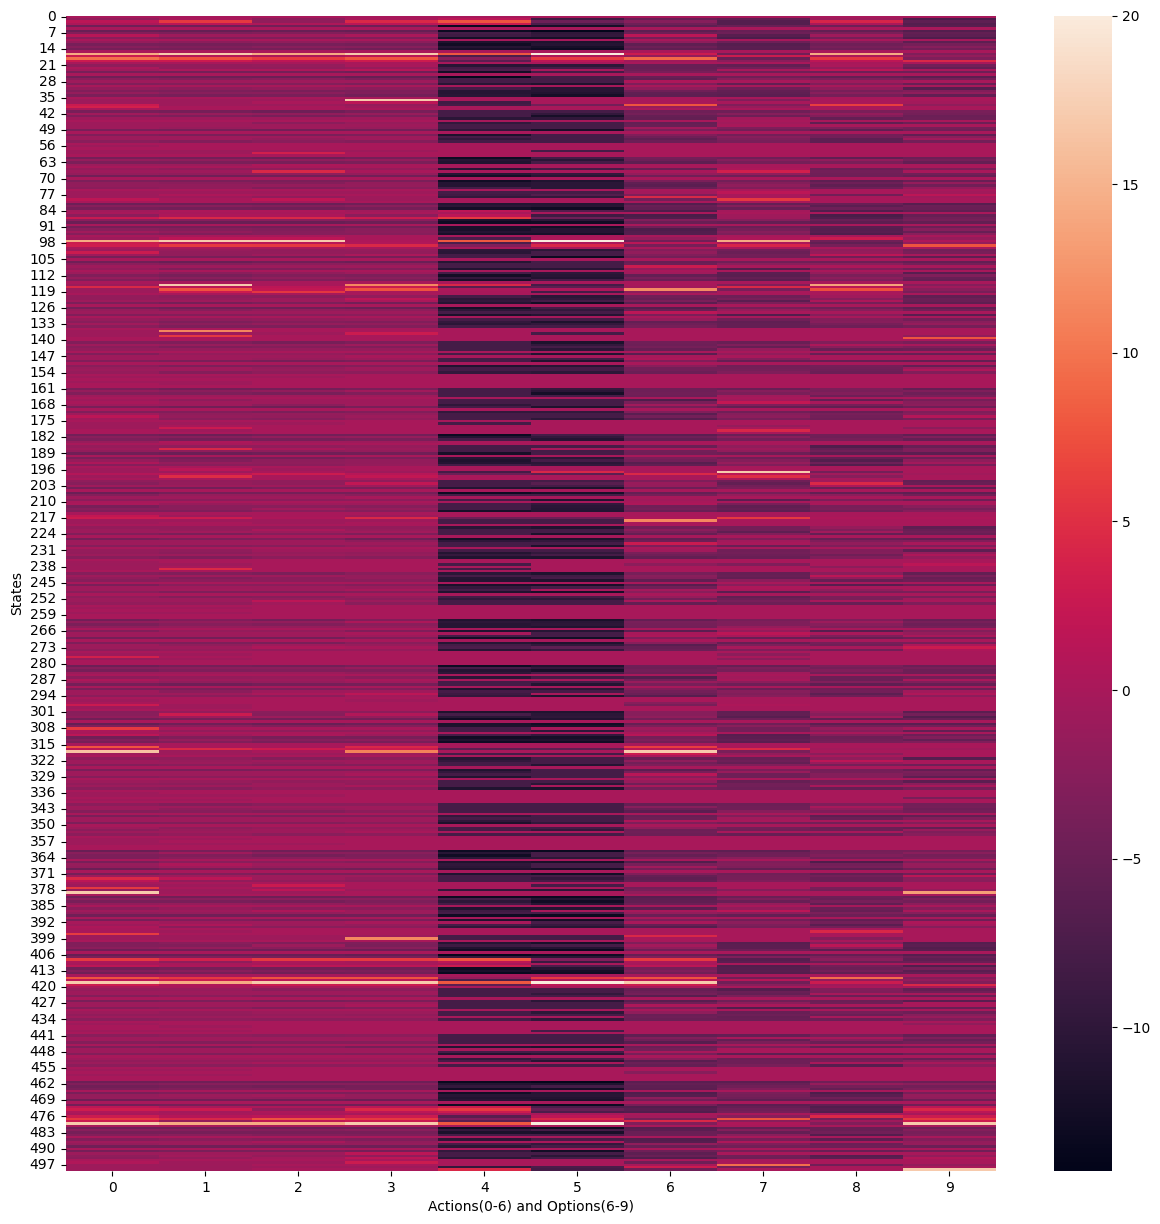

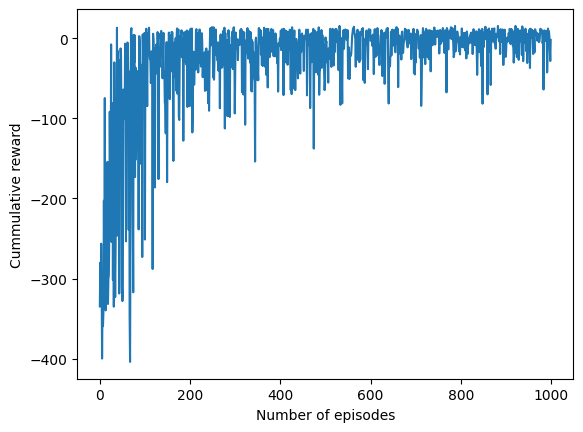

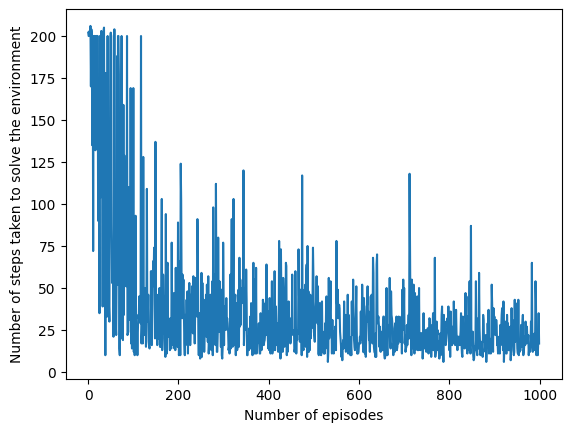

Avergae reward the agent earned on an average of 1000 episodes:  -30.559


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w3plolxx with config:
wandb: 	EPS: 0.1946579788452216
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


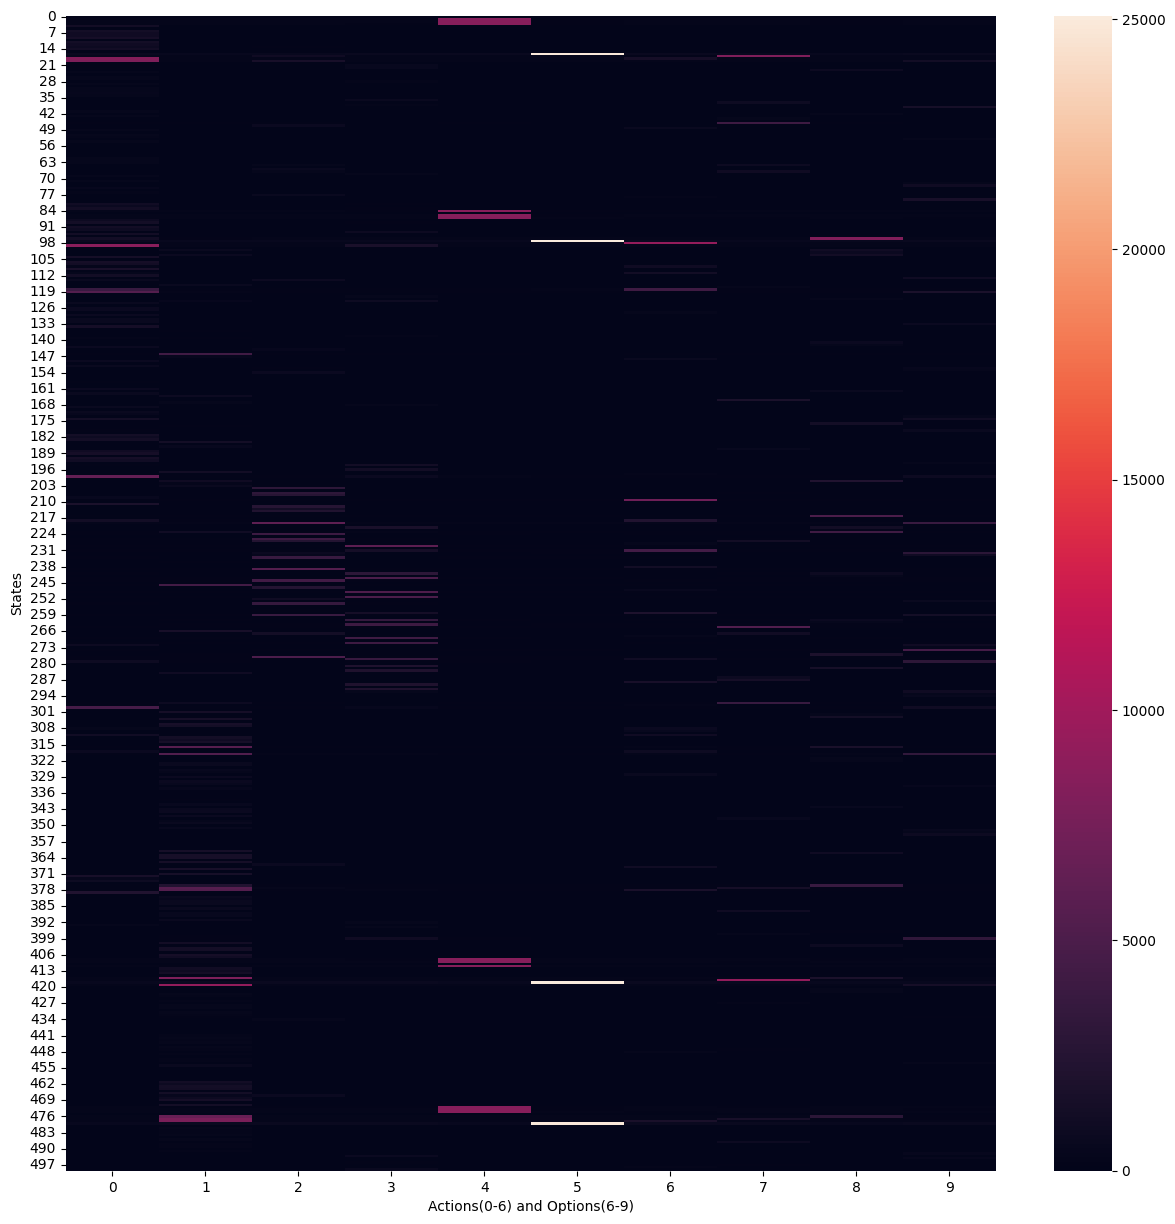

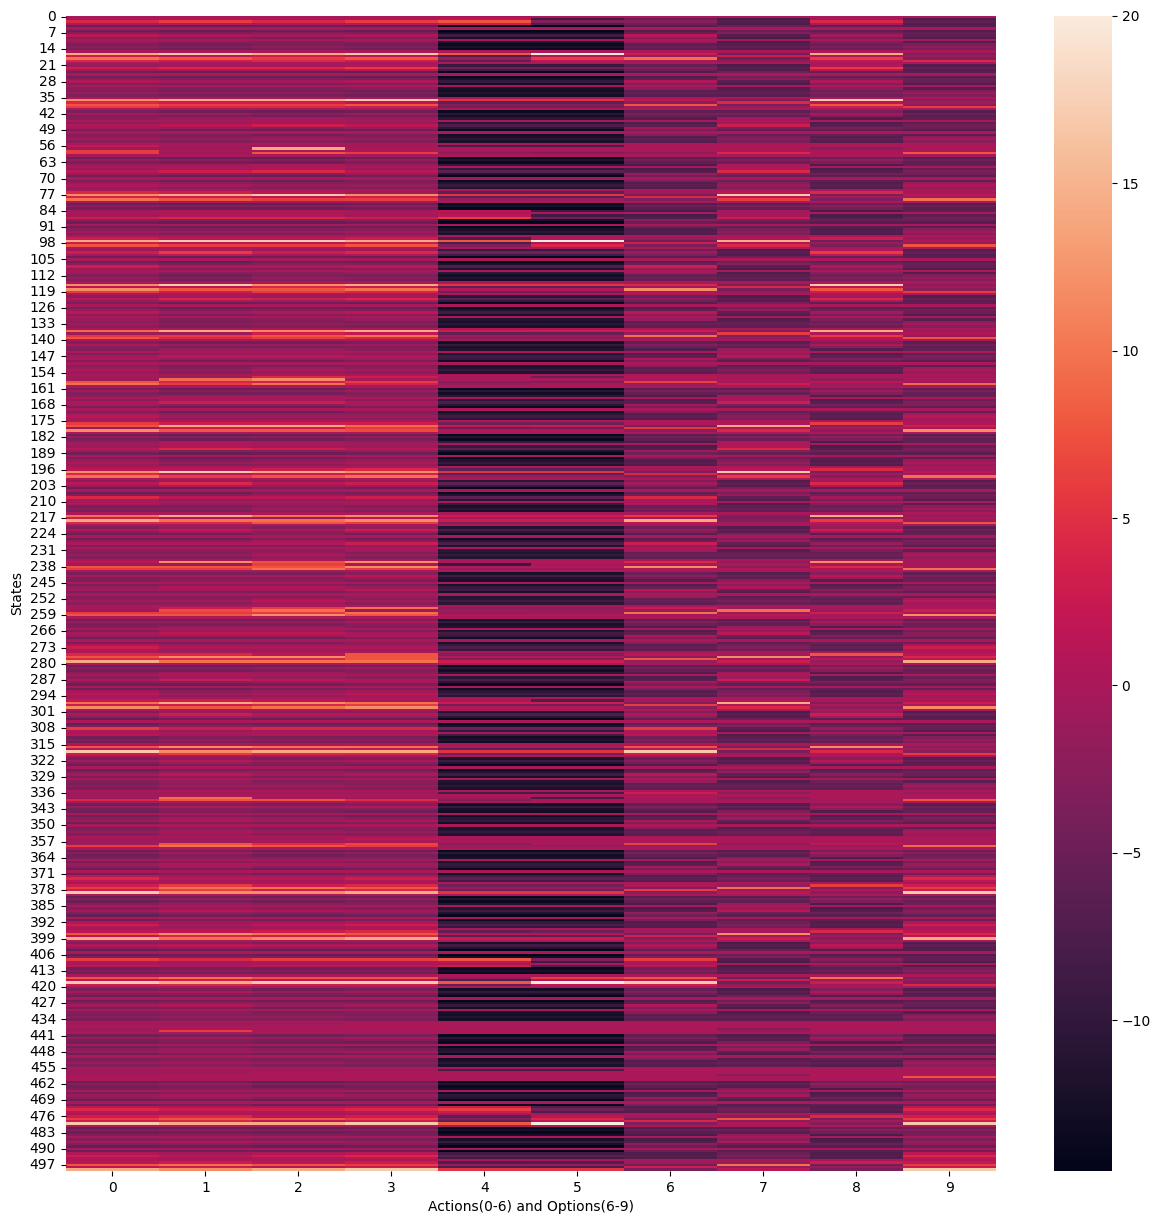

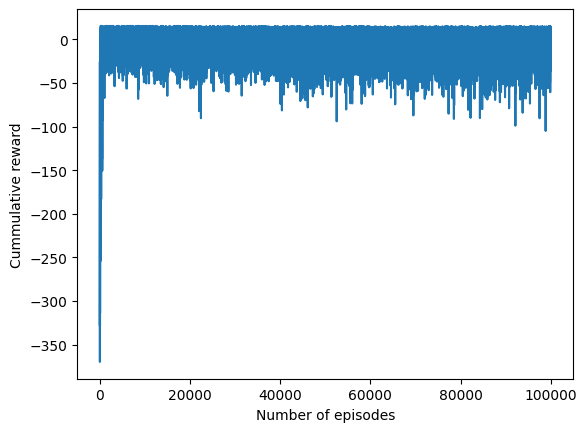

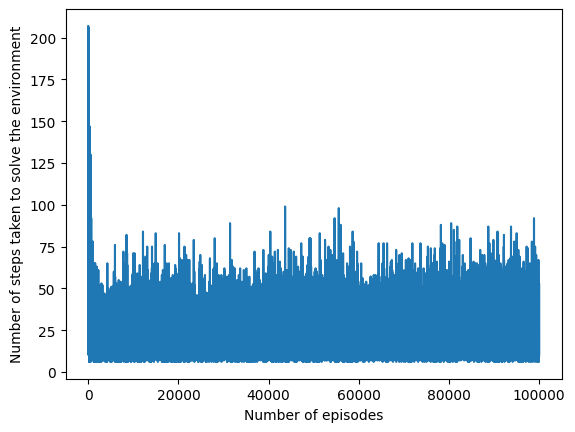

Avergae reward the agent earned on an average of 1000 episodes:  7.8


wandb: Agent Starting Run: jl1p4tgg with config:
wandb: 	EPS: 0.23677827791724948
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


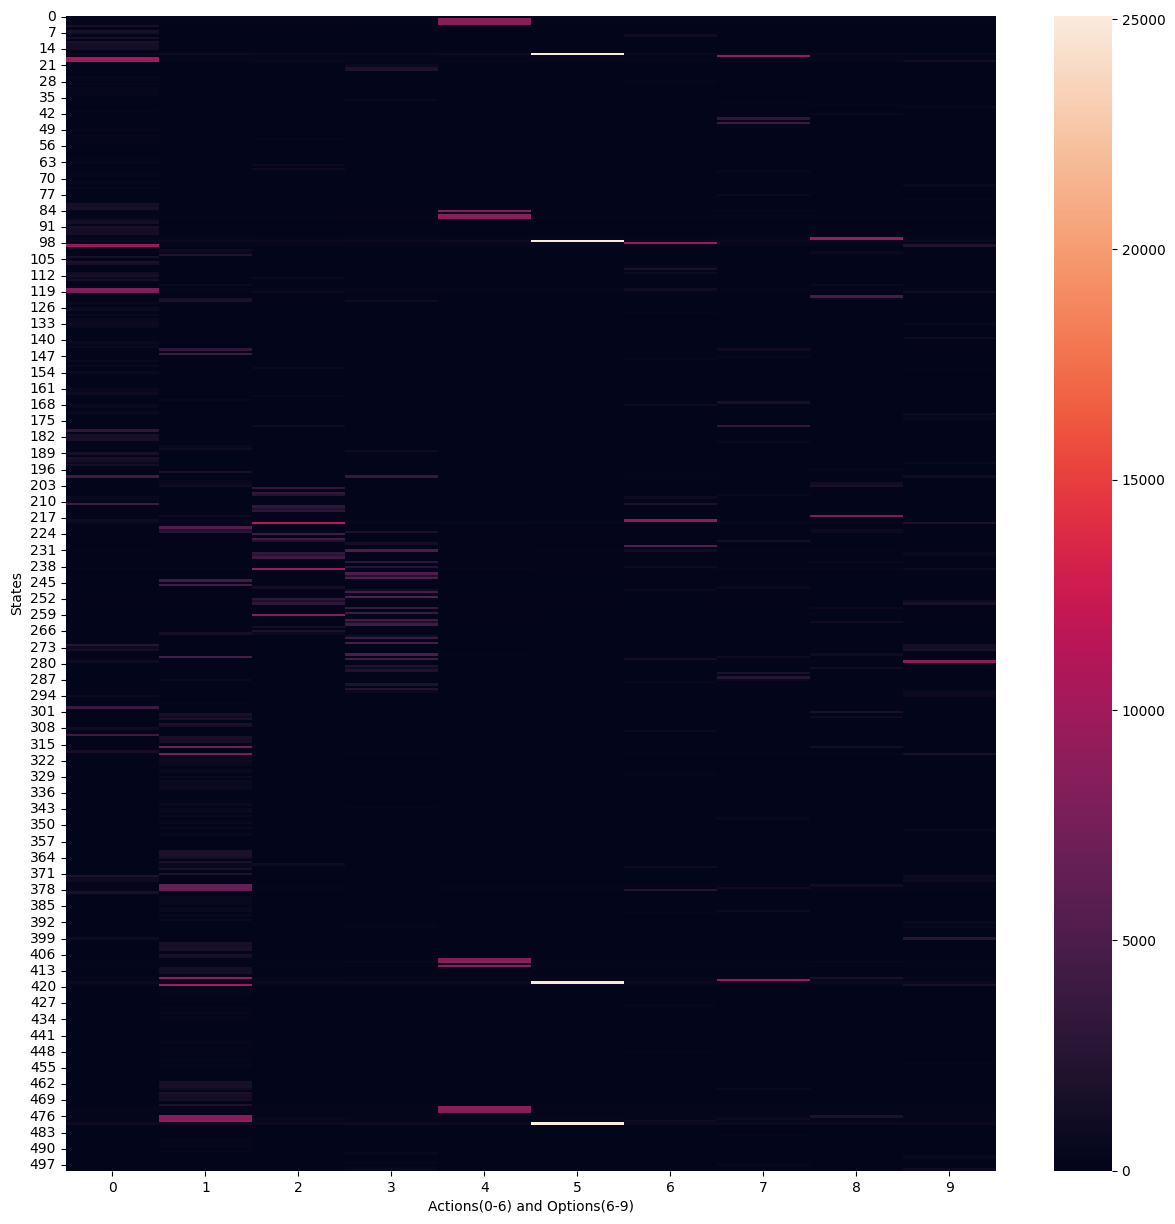

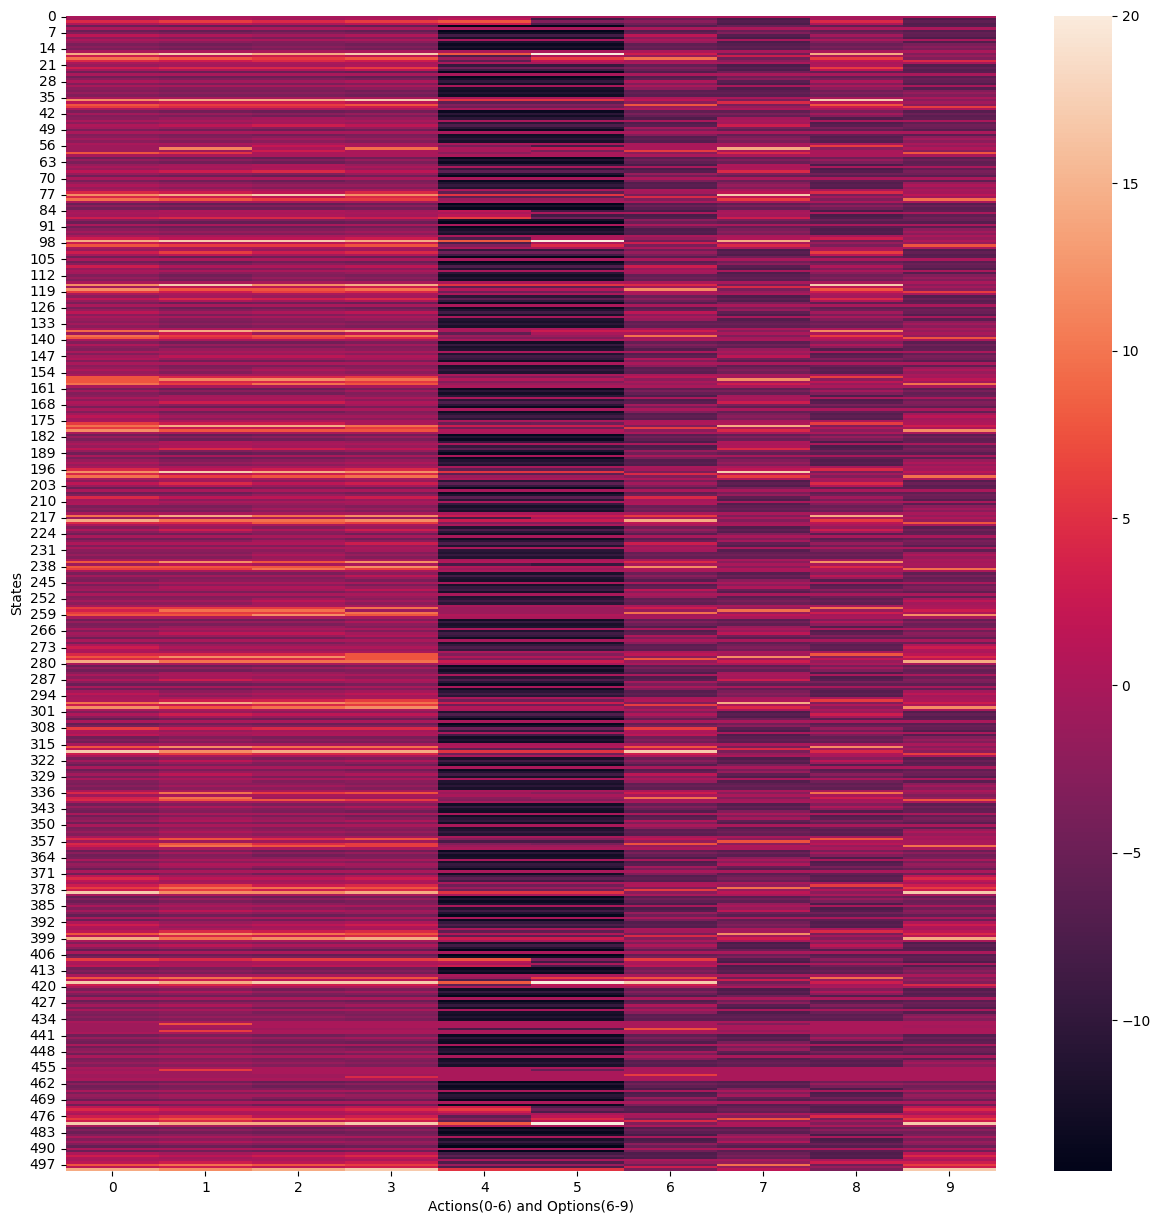

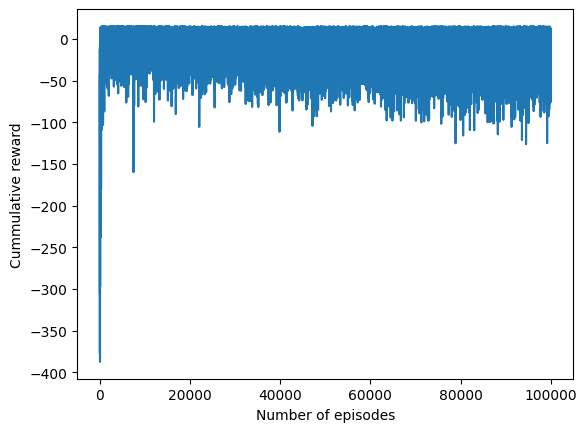

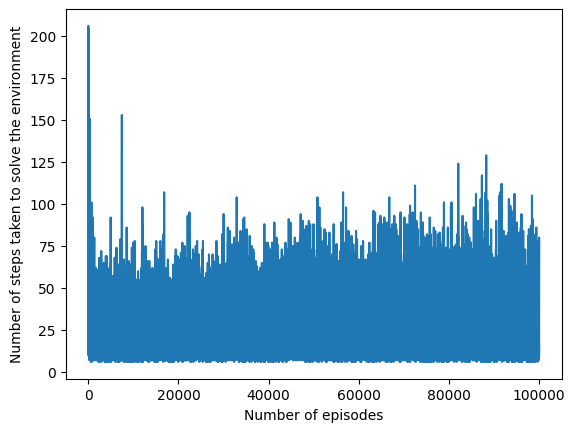

Avergae reward the agent earned on an average of 1000 episodes:  7.913


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tin4tyow with config:
wandb: 	EPS: 0.2963492831767156
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 100000


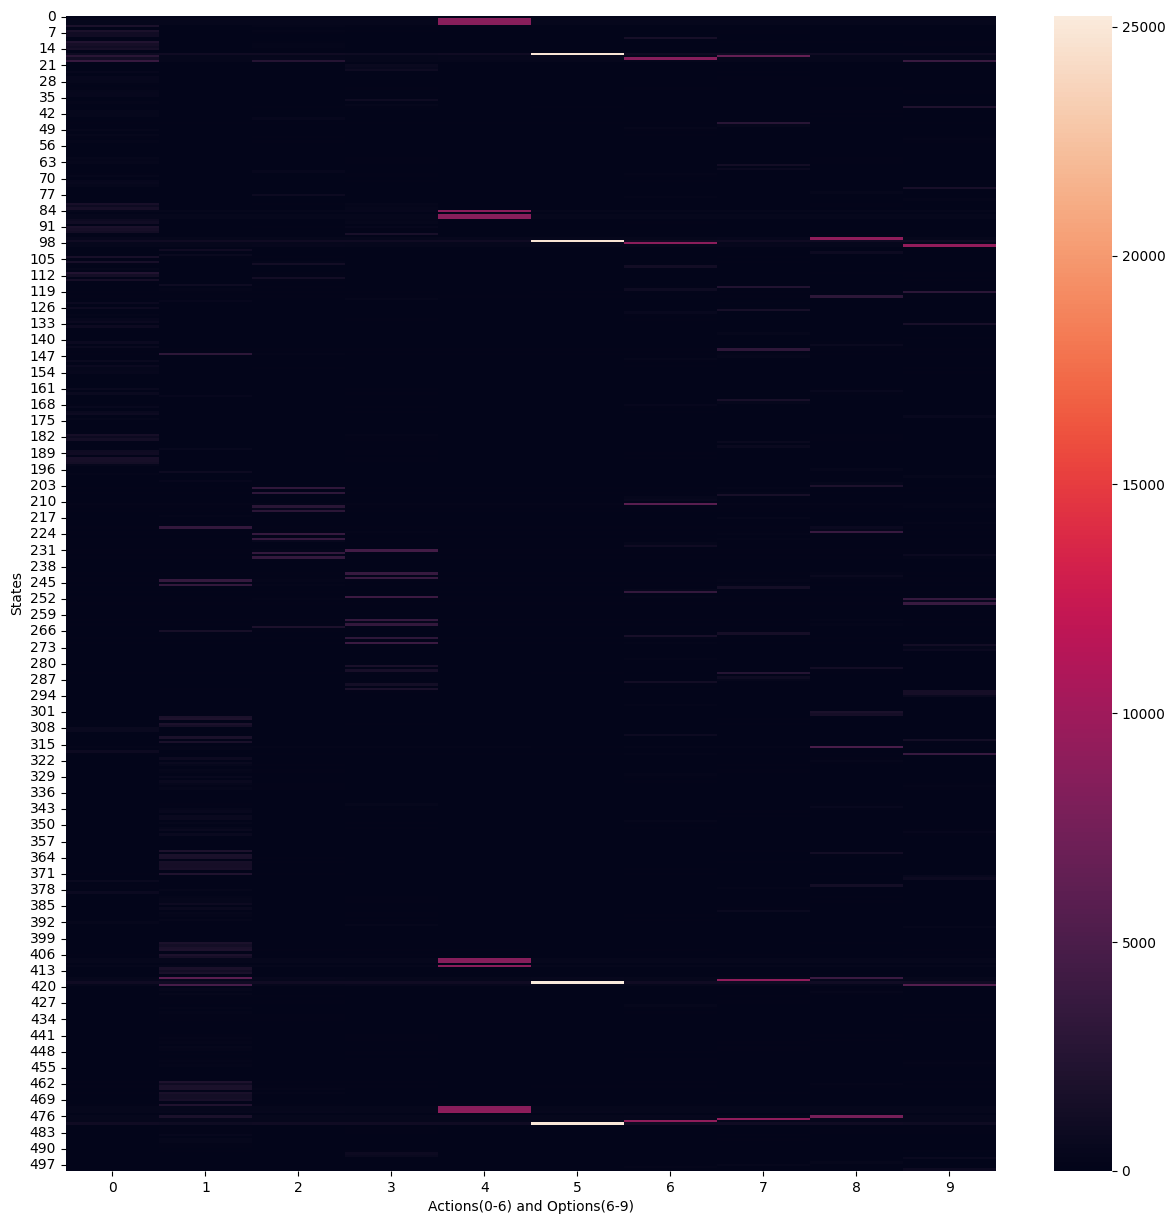

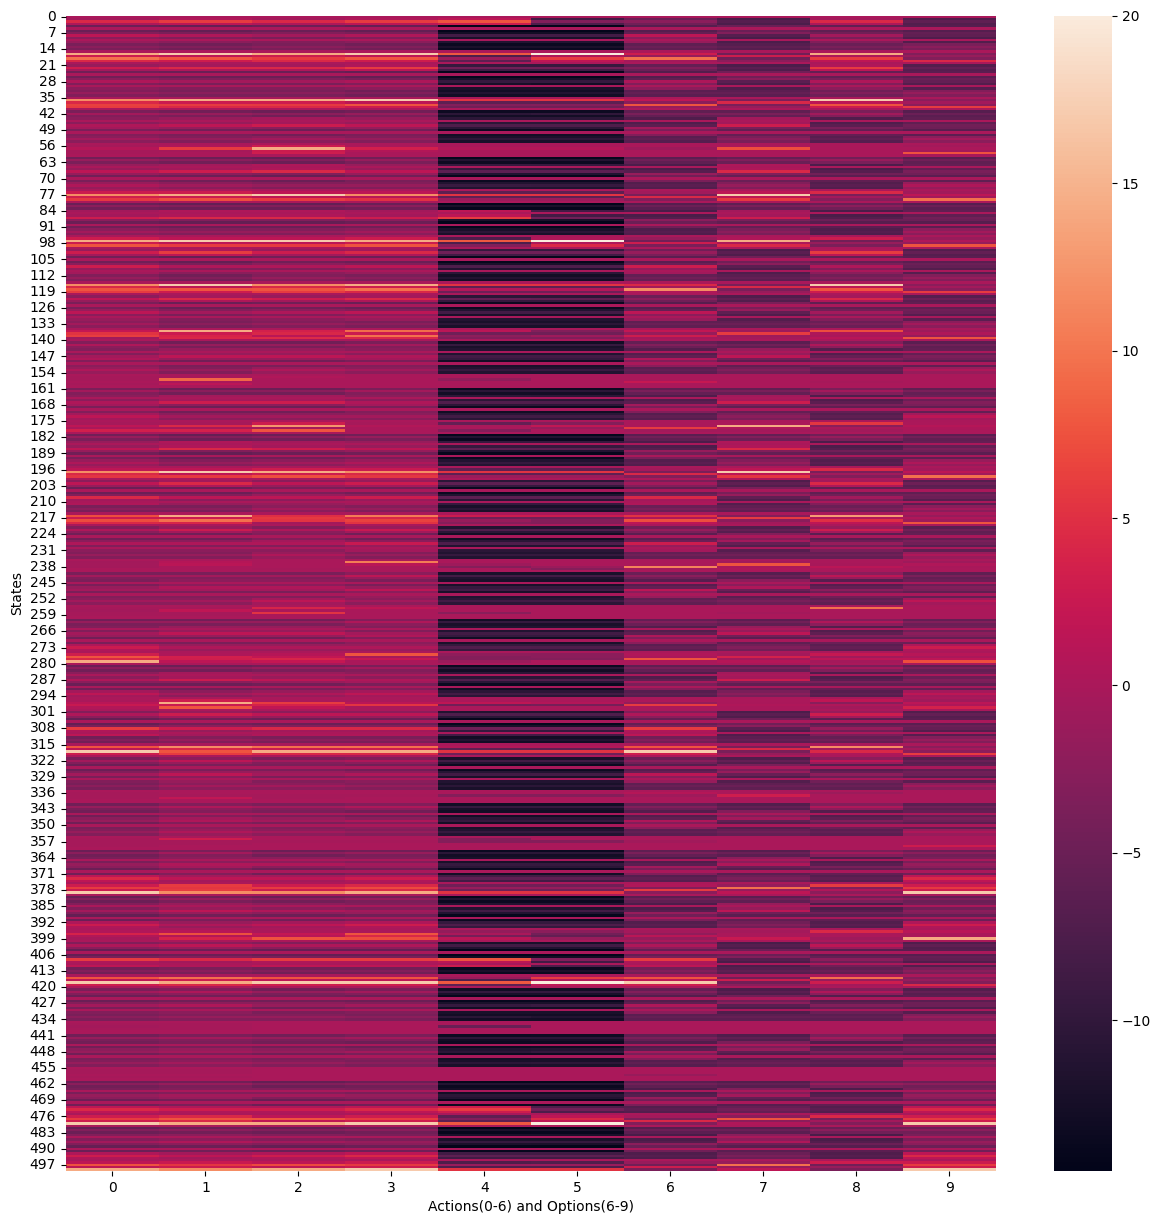

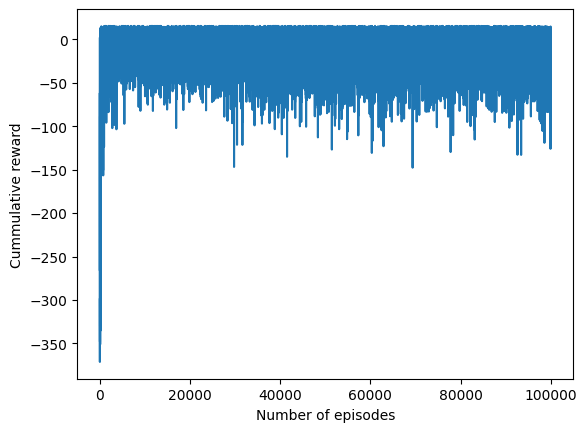

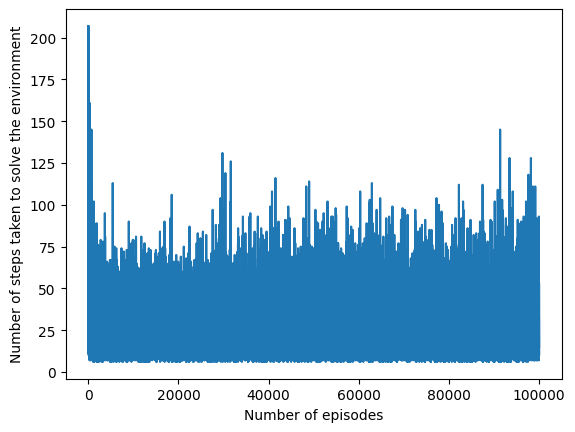

Avergae reward the agent earned on an average of 1000 episodes:  8.029


wandb: Agent Starting Run: s11awu2r with config:
wandb: 	EPS: 0.17893708108977718
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 10000


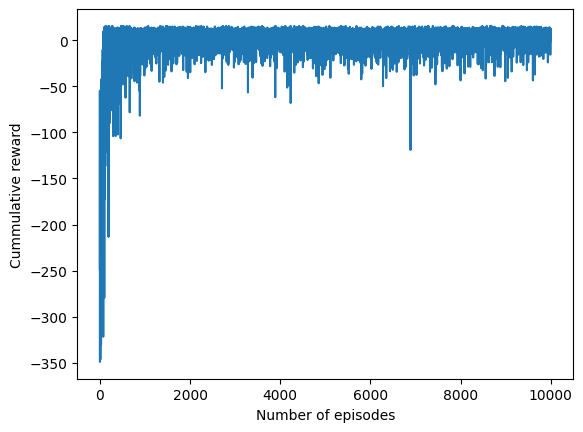

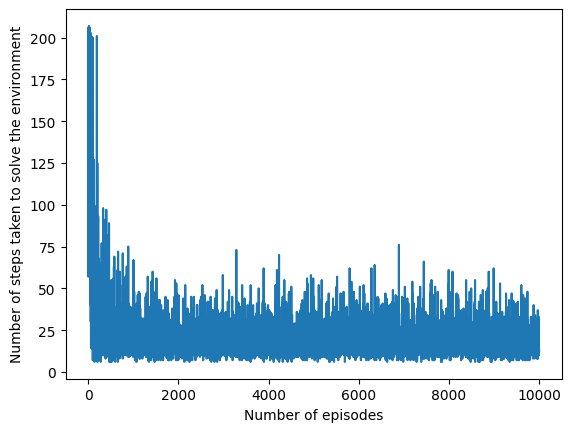

Avergae reward the agent earned on an average of 1000 episodes:  7.923


wandb: Agent Starting Run: rvfd2oft with config:
wandb: 	EPS: 0.15878138256321145
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 10000


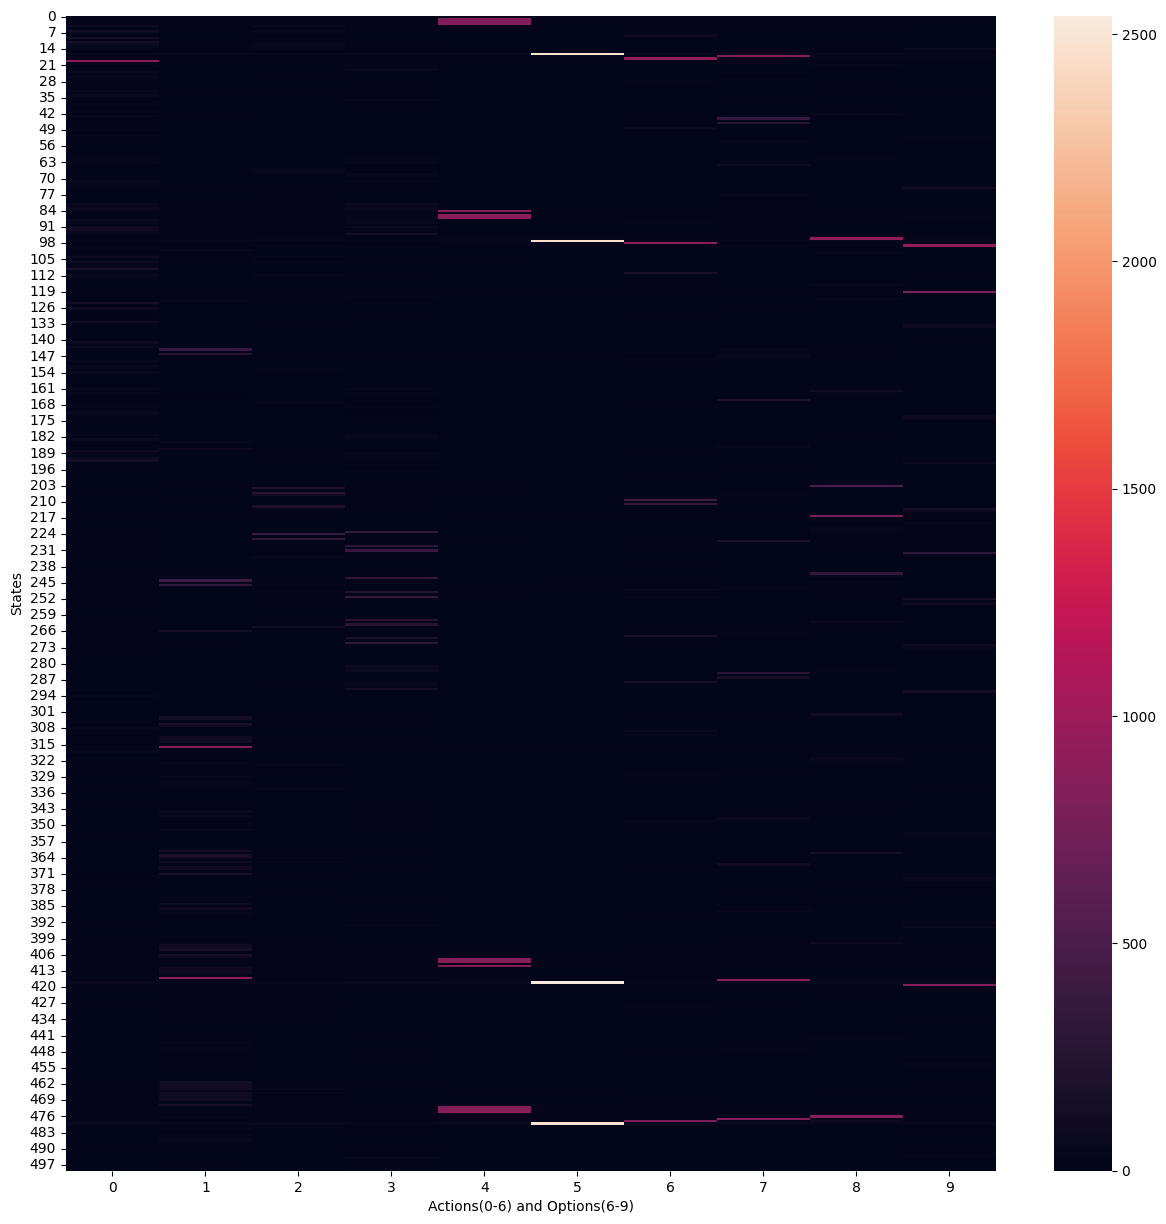

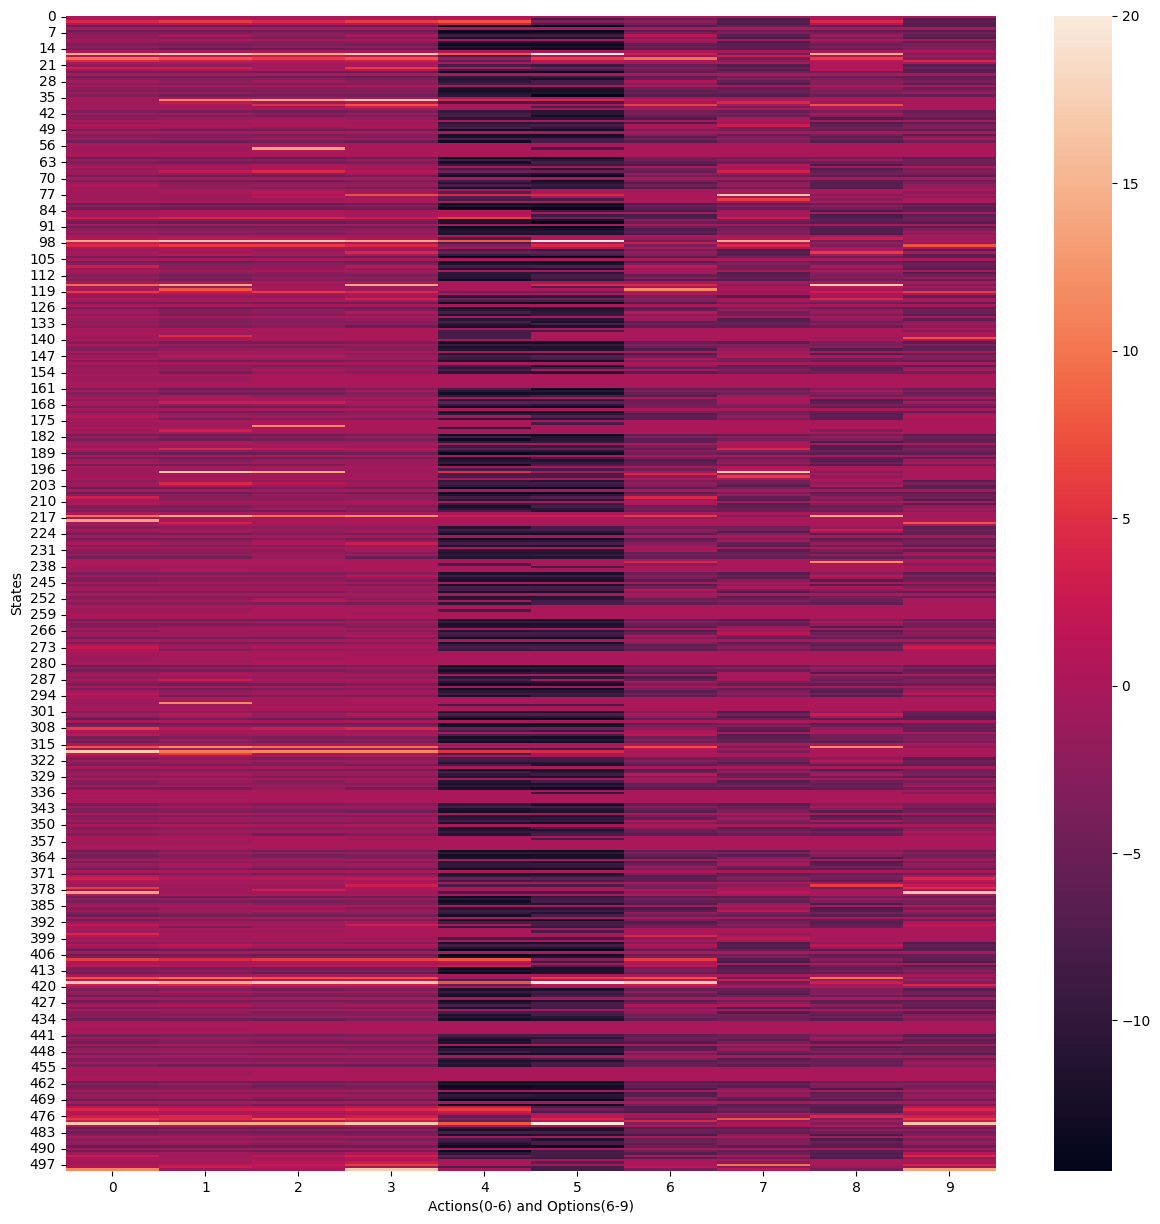

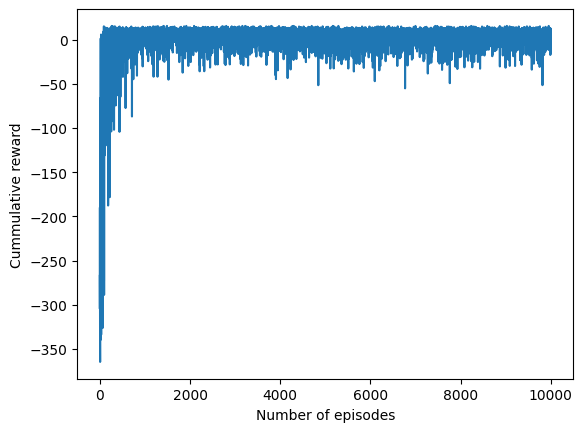

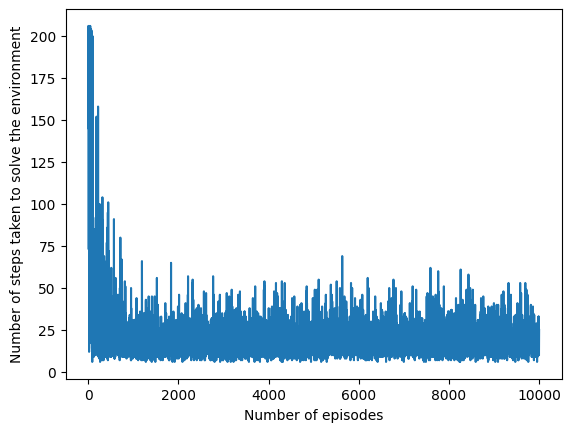

Avergae reward the agent earned on an average of 1000 episodes:  7.867


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xdyuz5iv with config:
wandb: 	EPS: 0.16774344046527367
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 5000


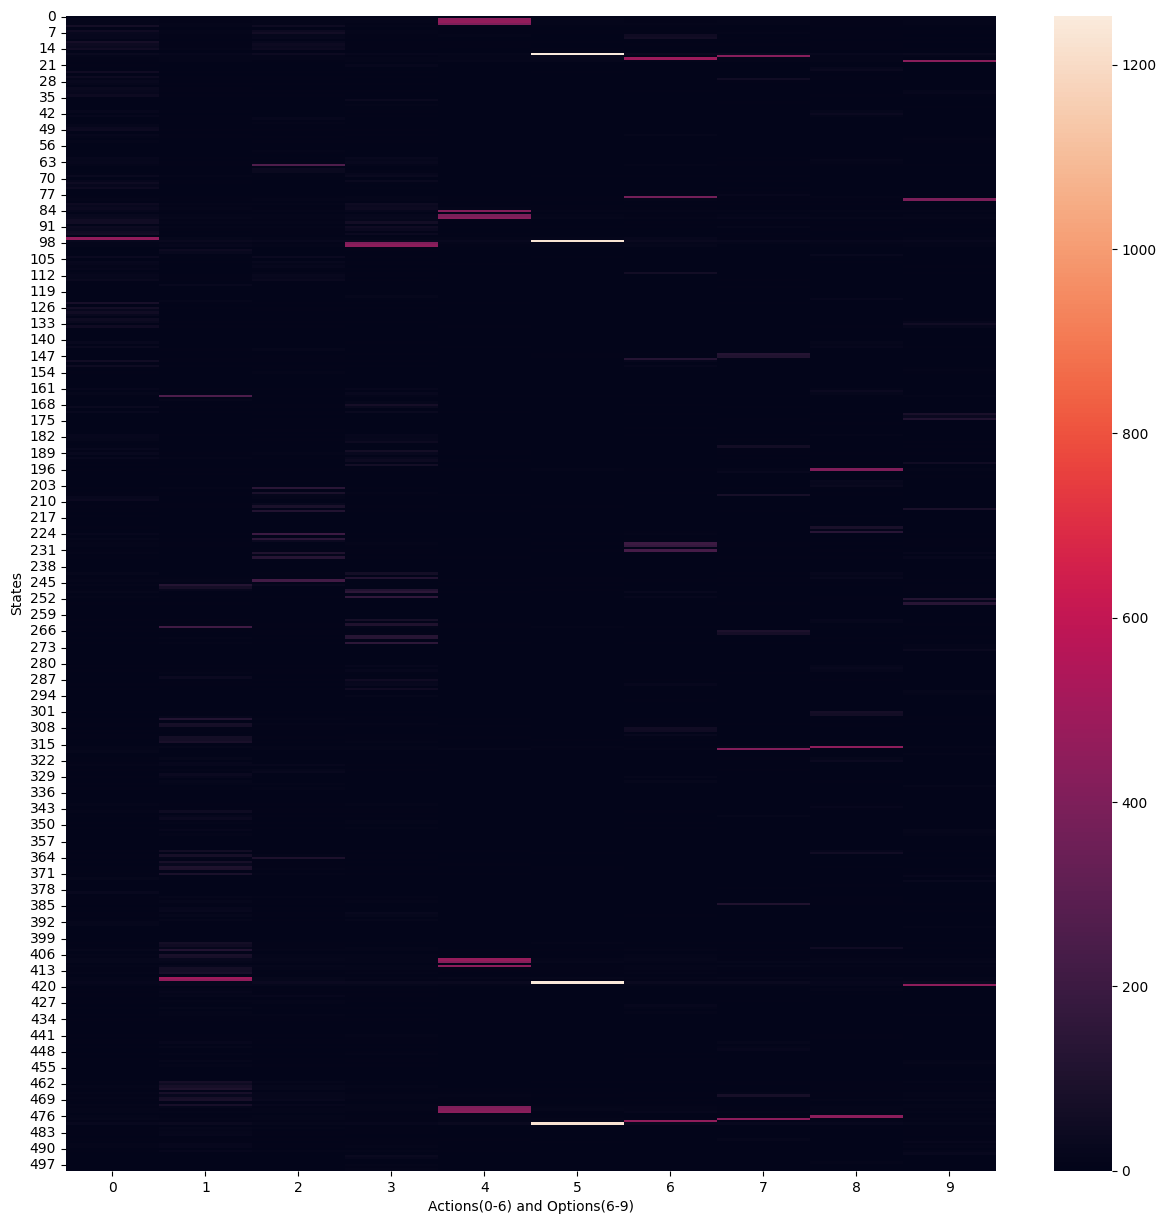

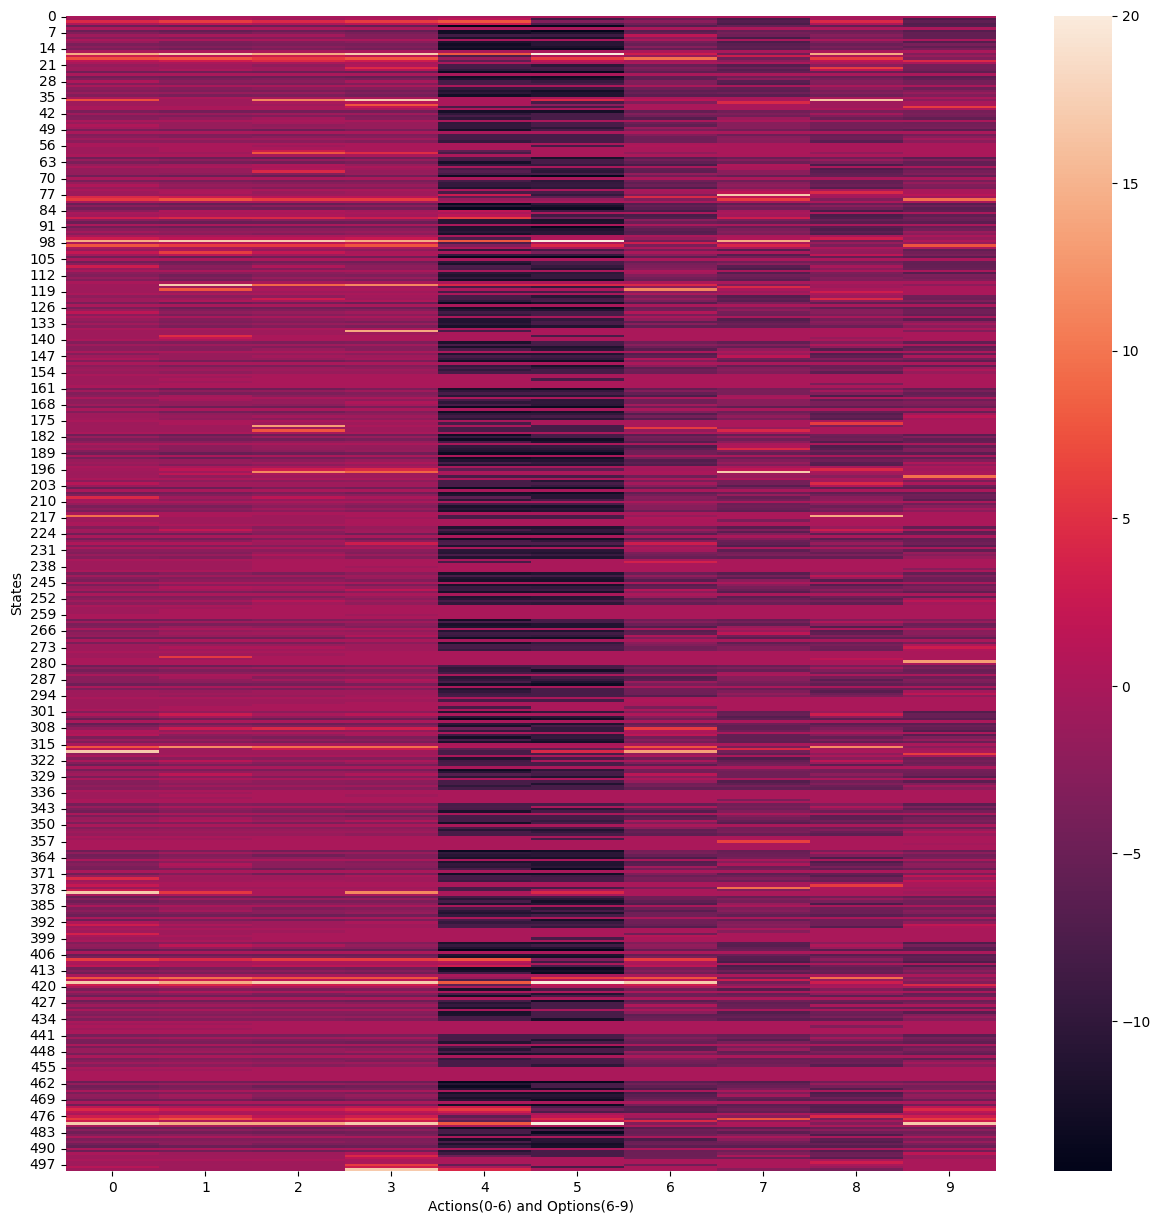

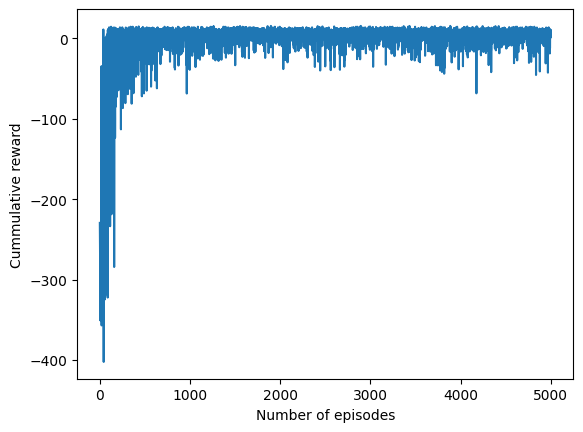

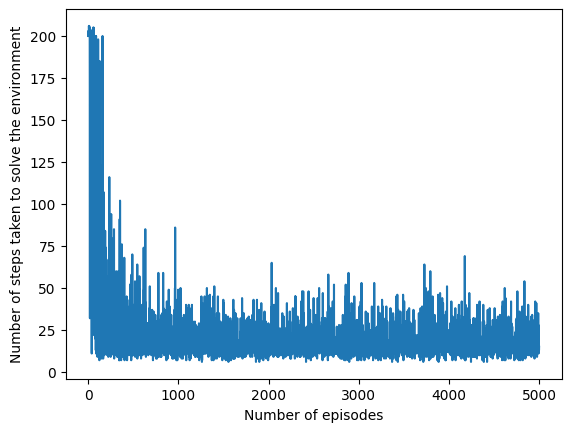

Avergae reward the agent earned on an average of 1000 episodes:  7.925


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: uyftsjgv with config:
wandb: 	EPS: 0.23369278288001105
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 50000


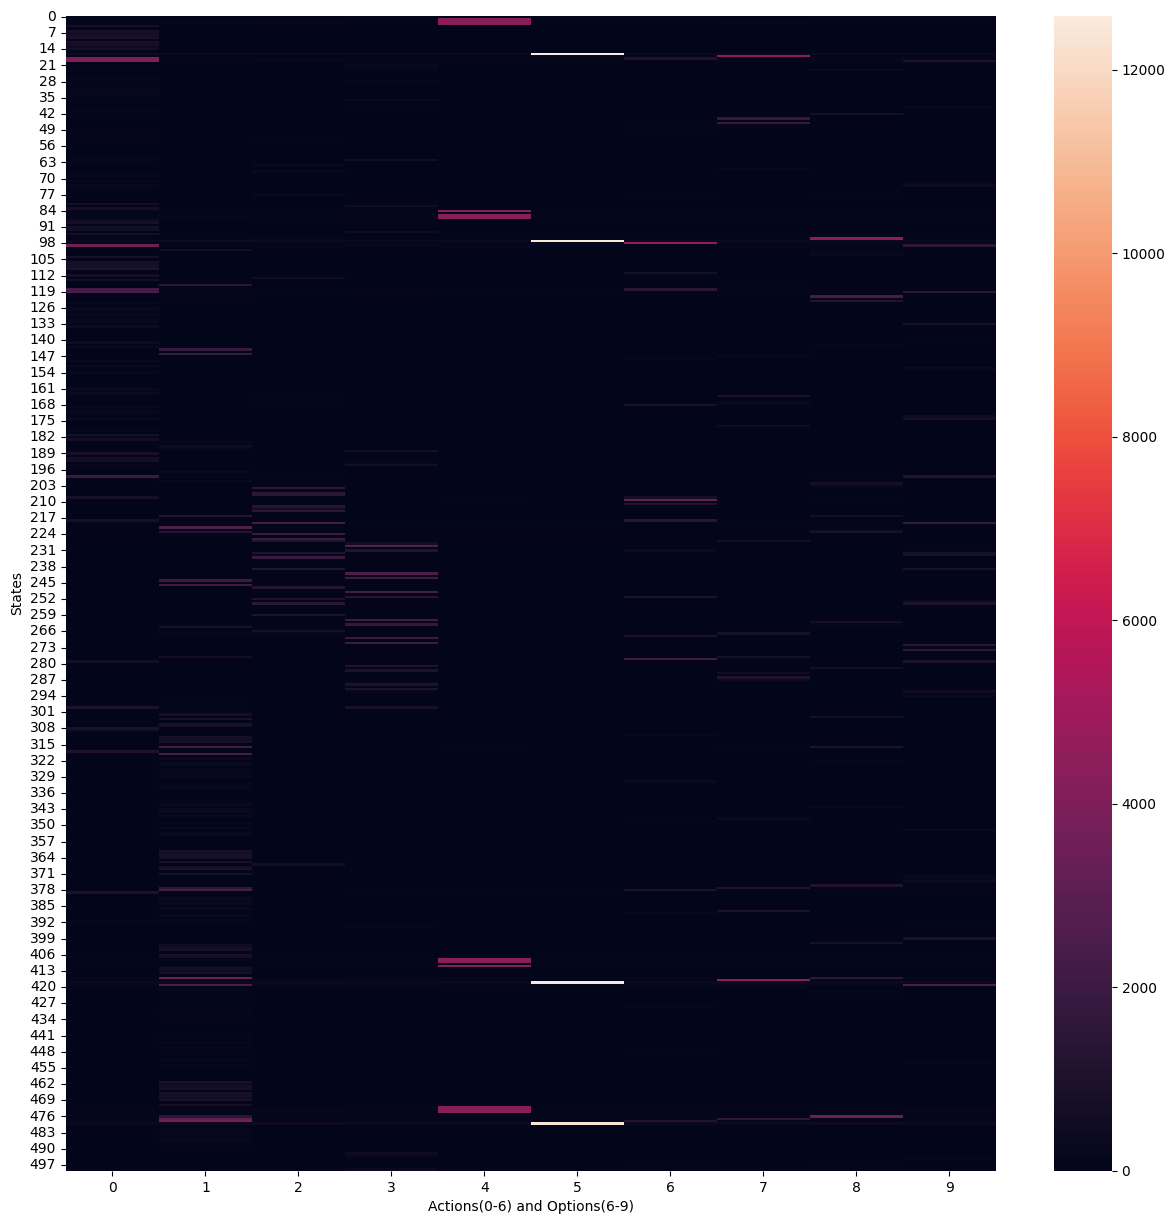

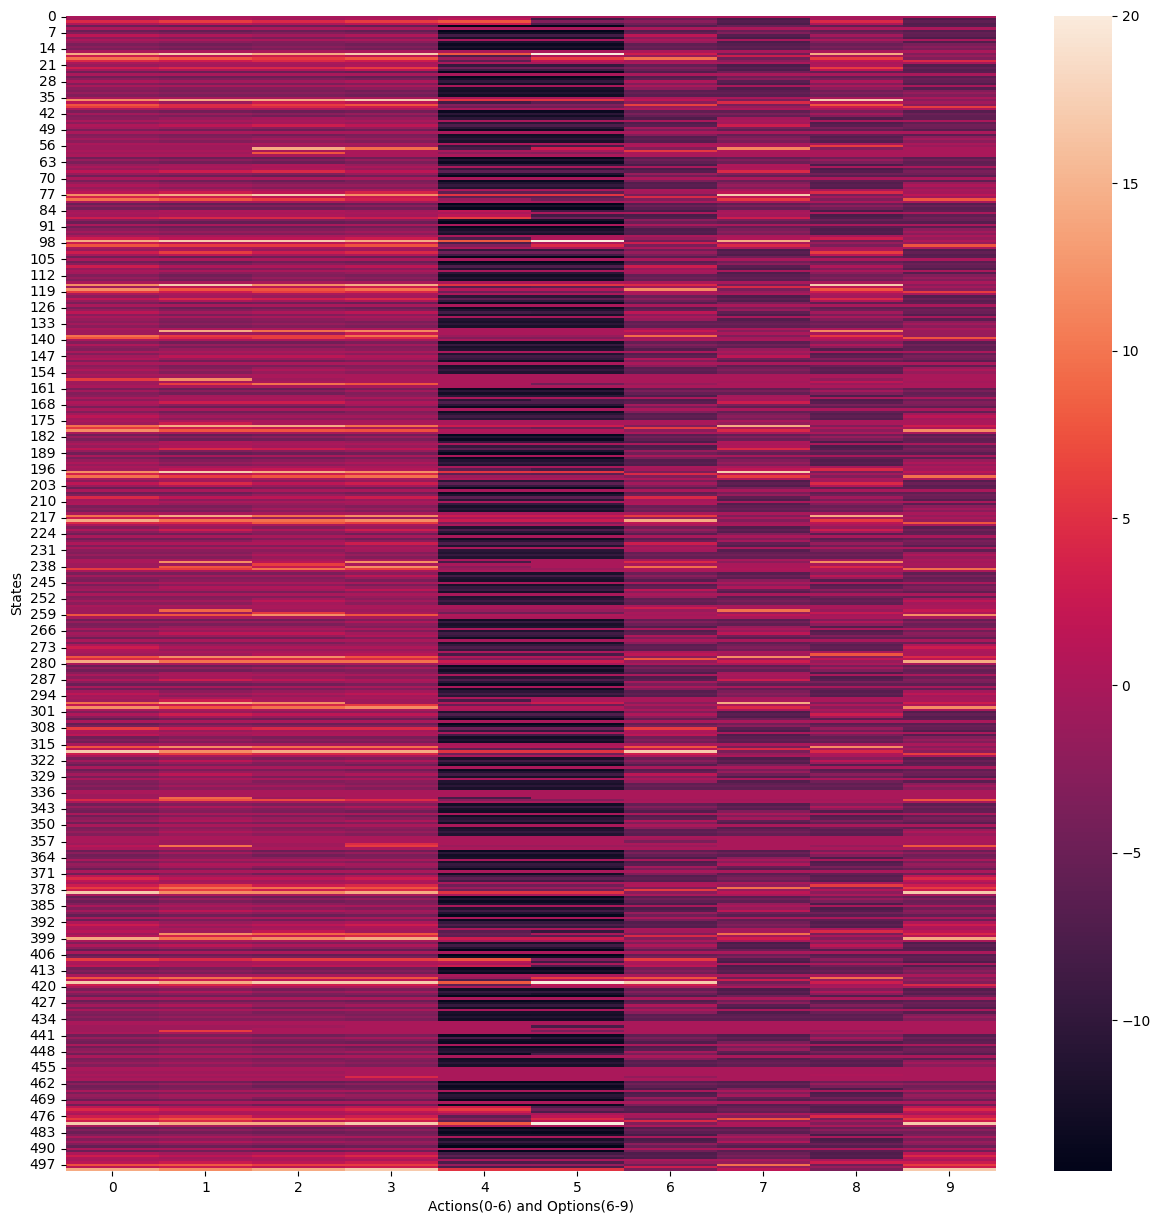

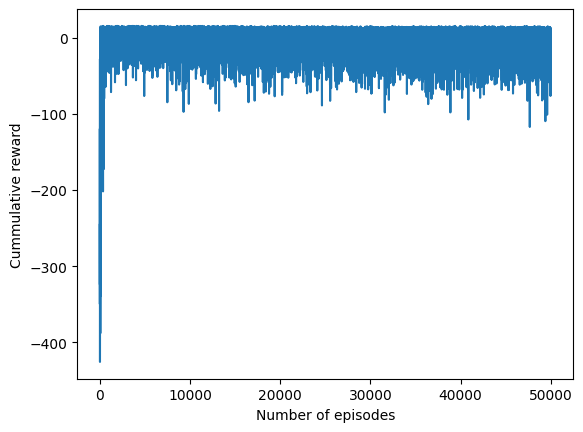

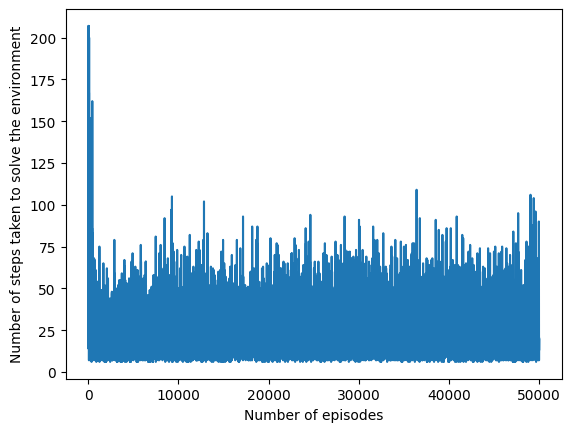

Avergae reward the agent earned on an average of 1000 episodes:  7.836


wandb: Agent Starting Run: 8dy7k1rf with config:
wandb: 	EPS: 0.2981043519980414
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


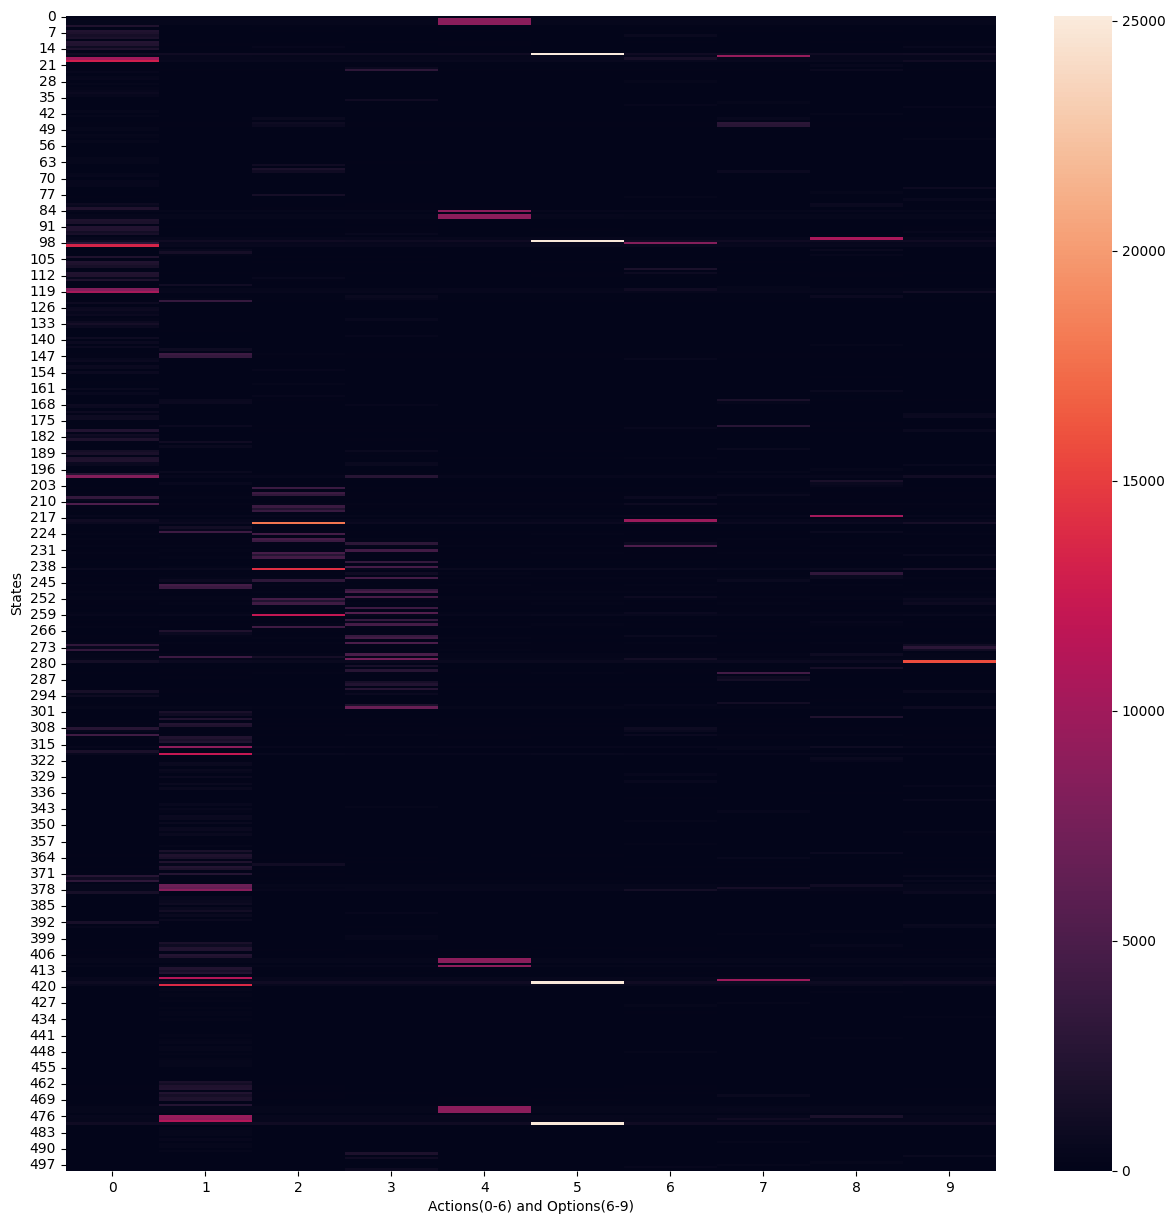

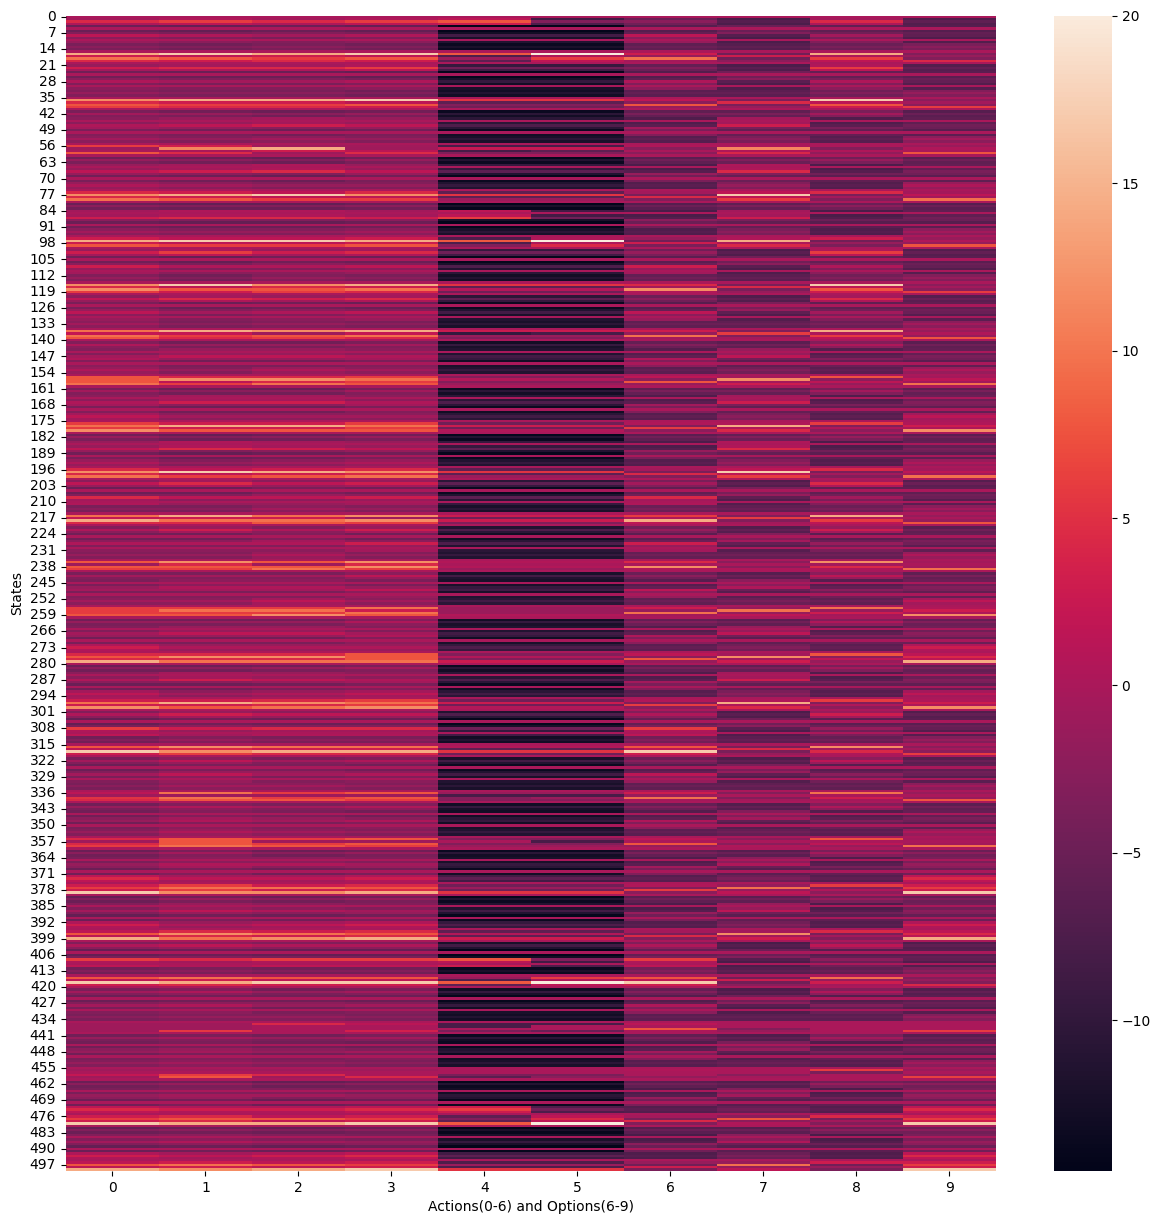

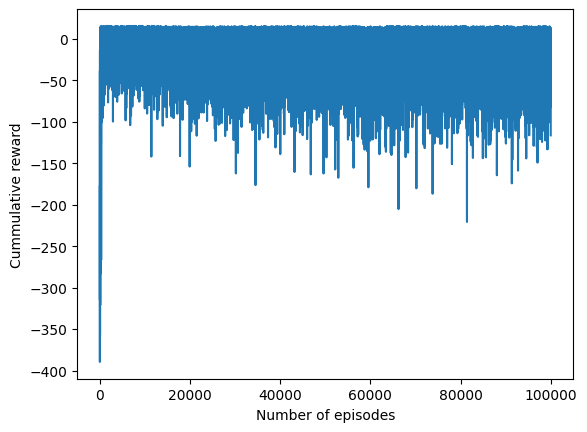

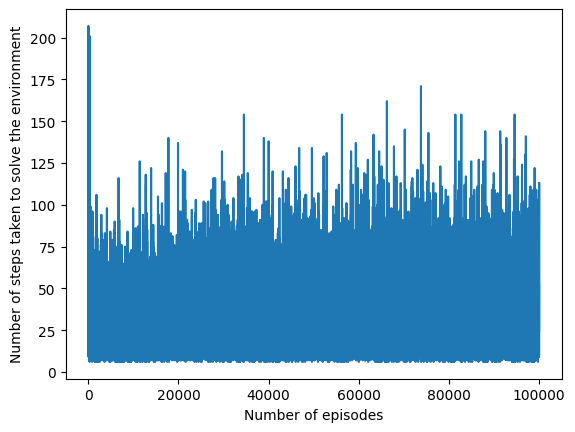

Avergae reward the agent earned on an average of 1000 episodes:  7.906


wandb: Agent Starting Run: t7xjosa6 with config:
wandb: 	EPS: 0.28432545655923036
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


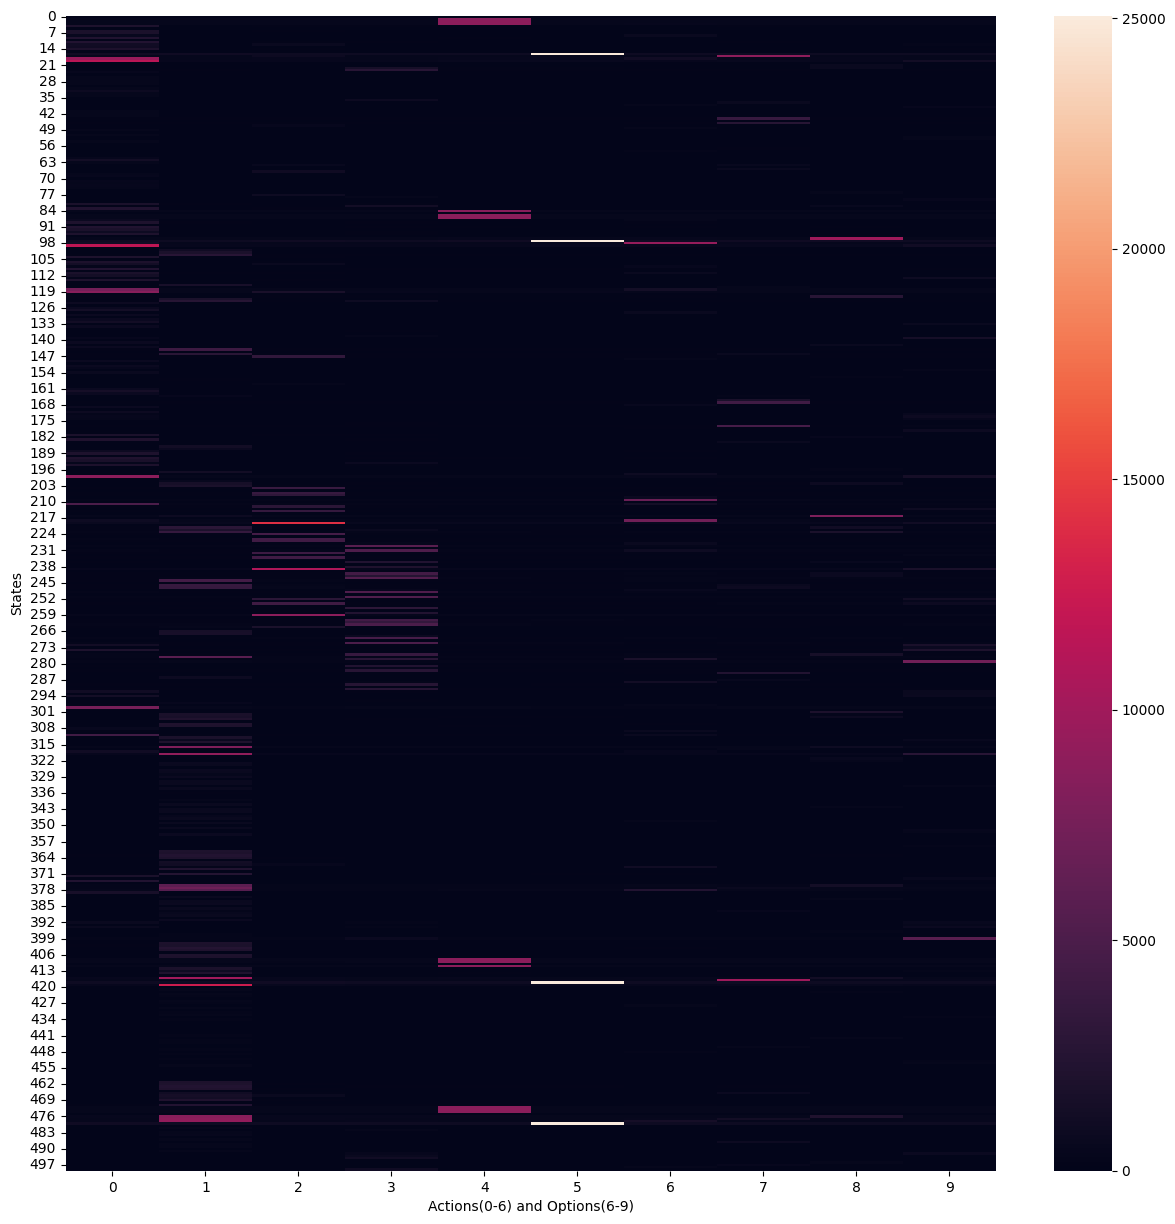

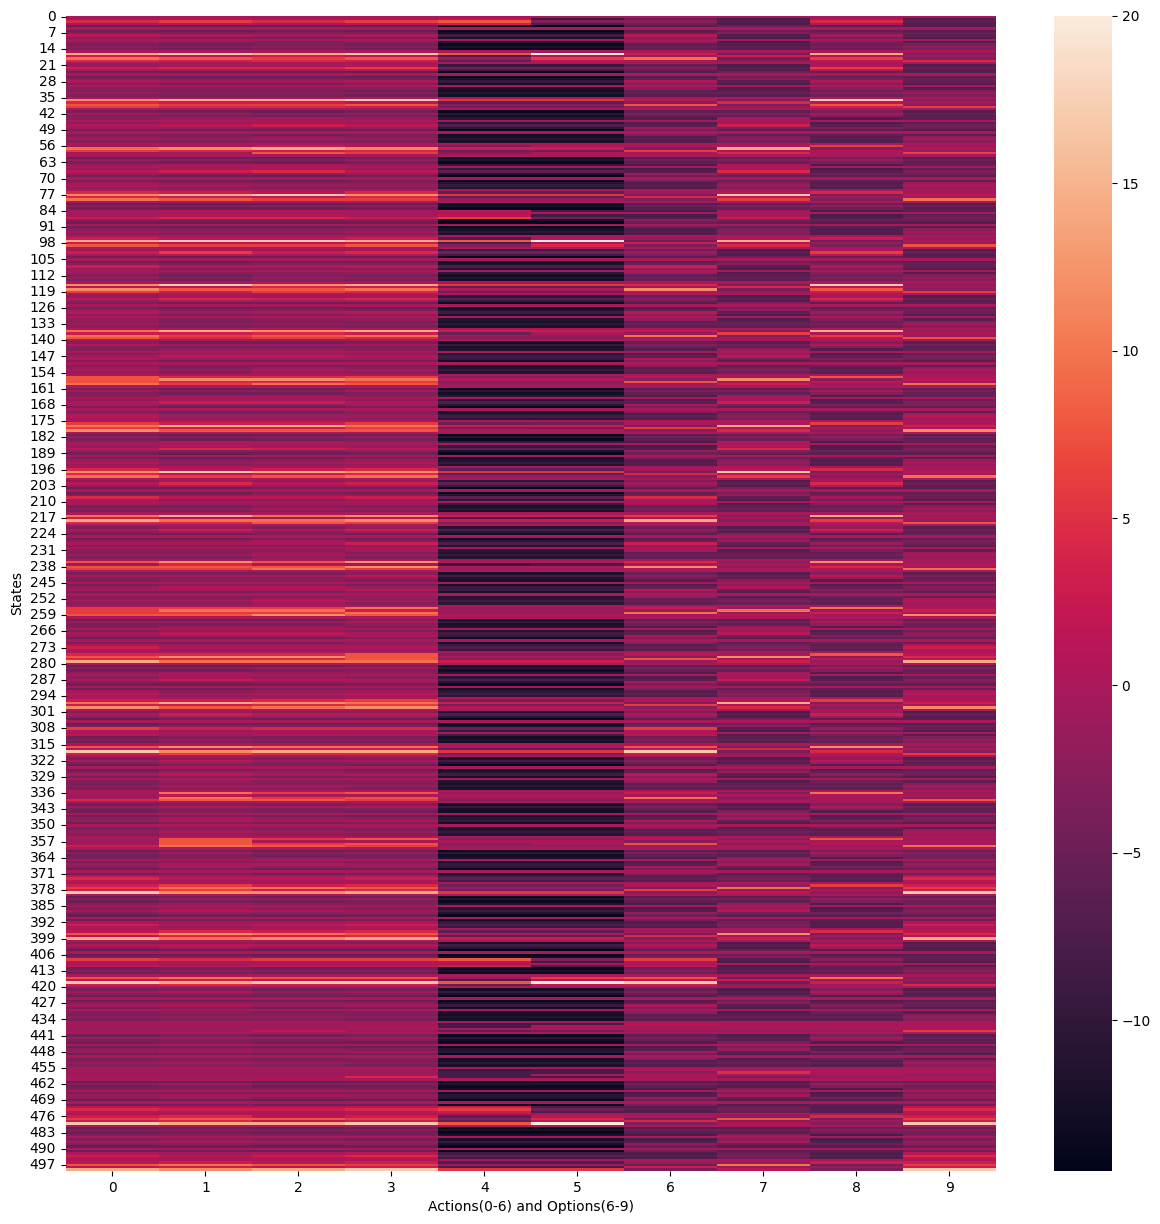

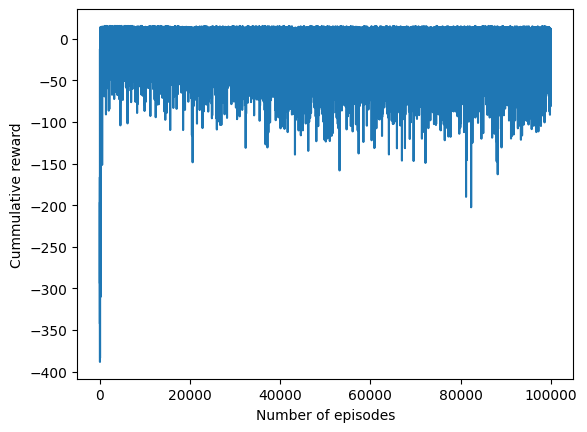

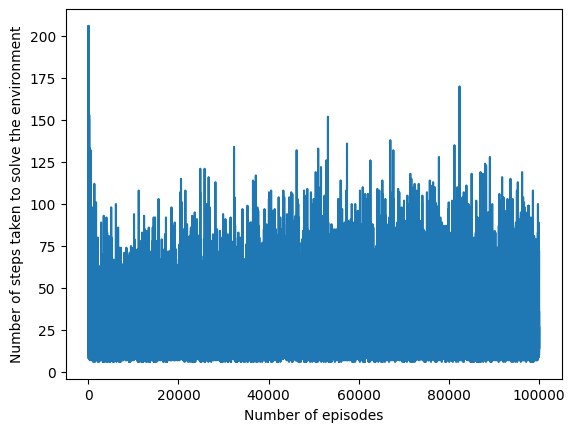

Avergae reward the agent earned on an average of 1000 episodes:  8.048


wandb: Agent Starting Run: 2vavjss4 with config:
wandb: 	EPS: 0.07764108632512014
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


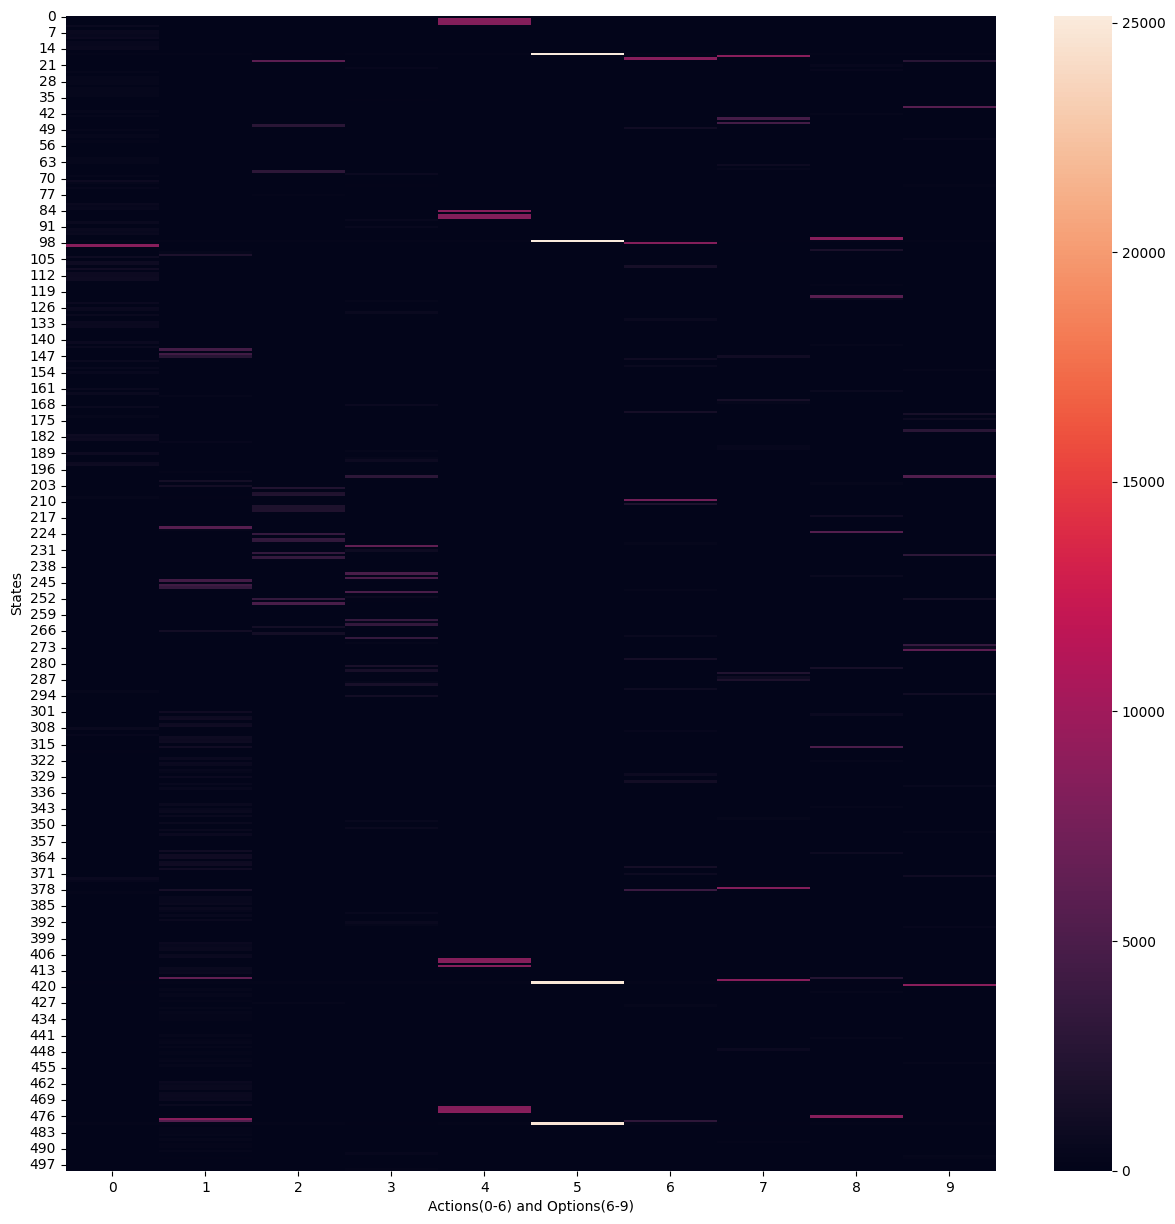

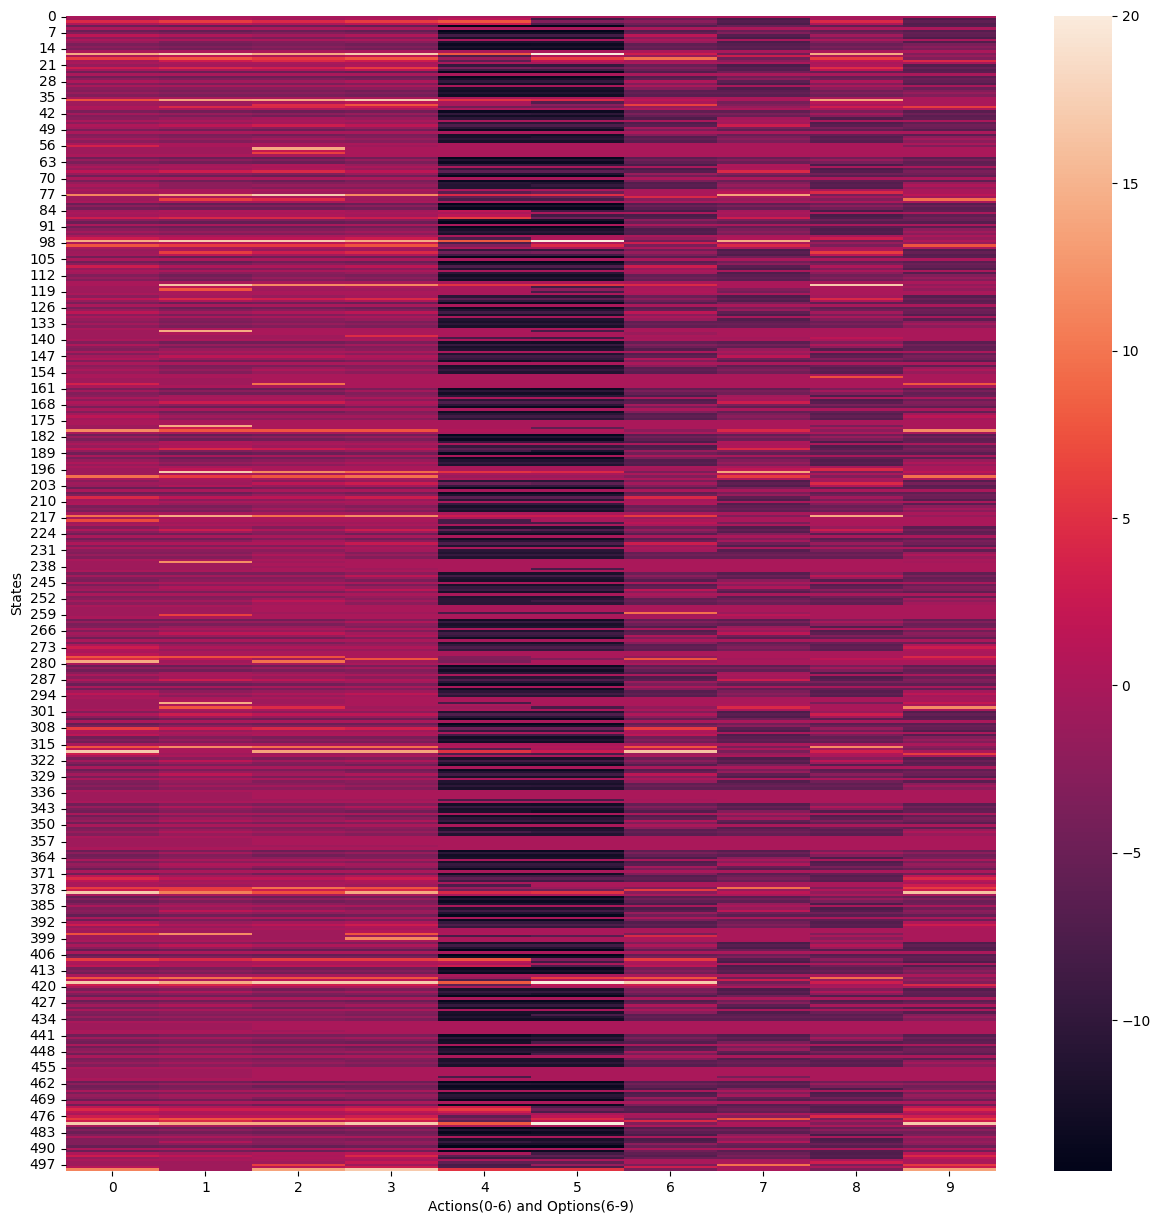

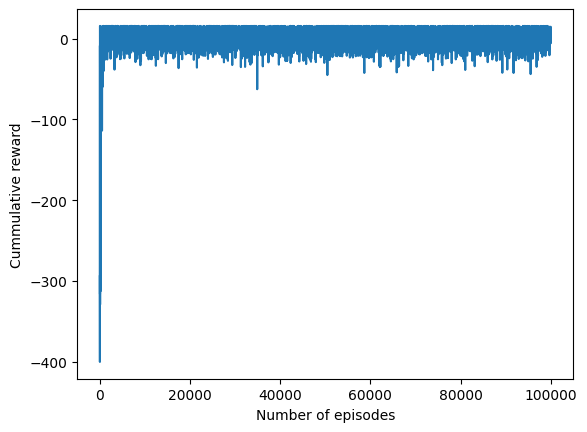

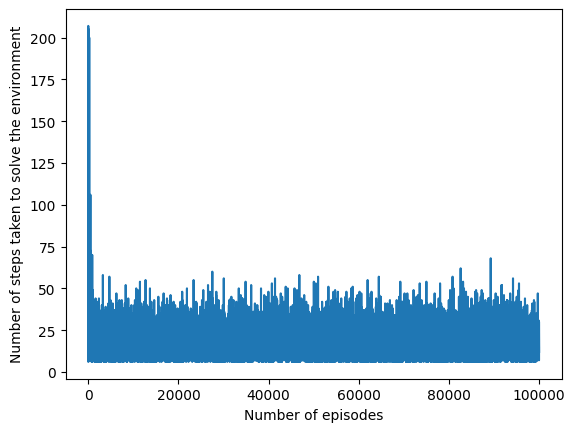

Avergae reward the agent earned on an average of 1000 episodes:  7.95


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6umc0w9g with config:
wandb: 	EPS: 0.2921839513431433
wandb: 	LR: 0.1
wandb: 	NUM_EPISODES: 100000


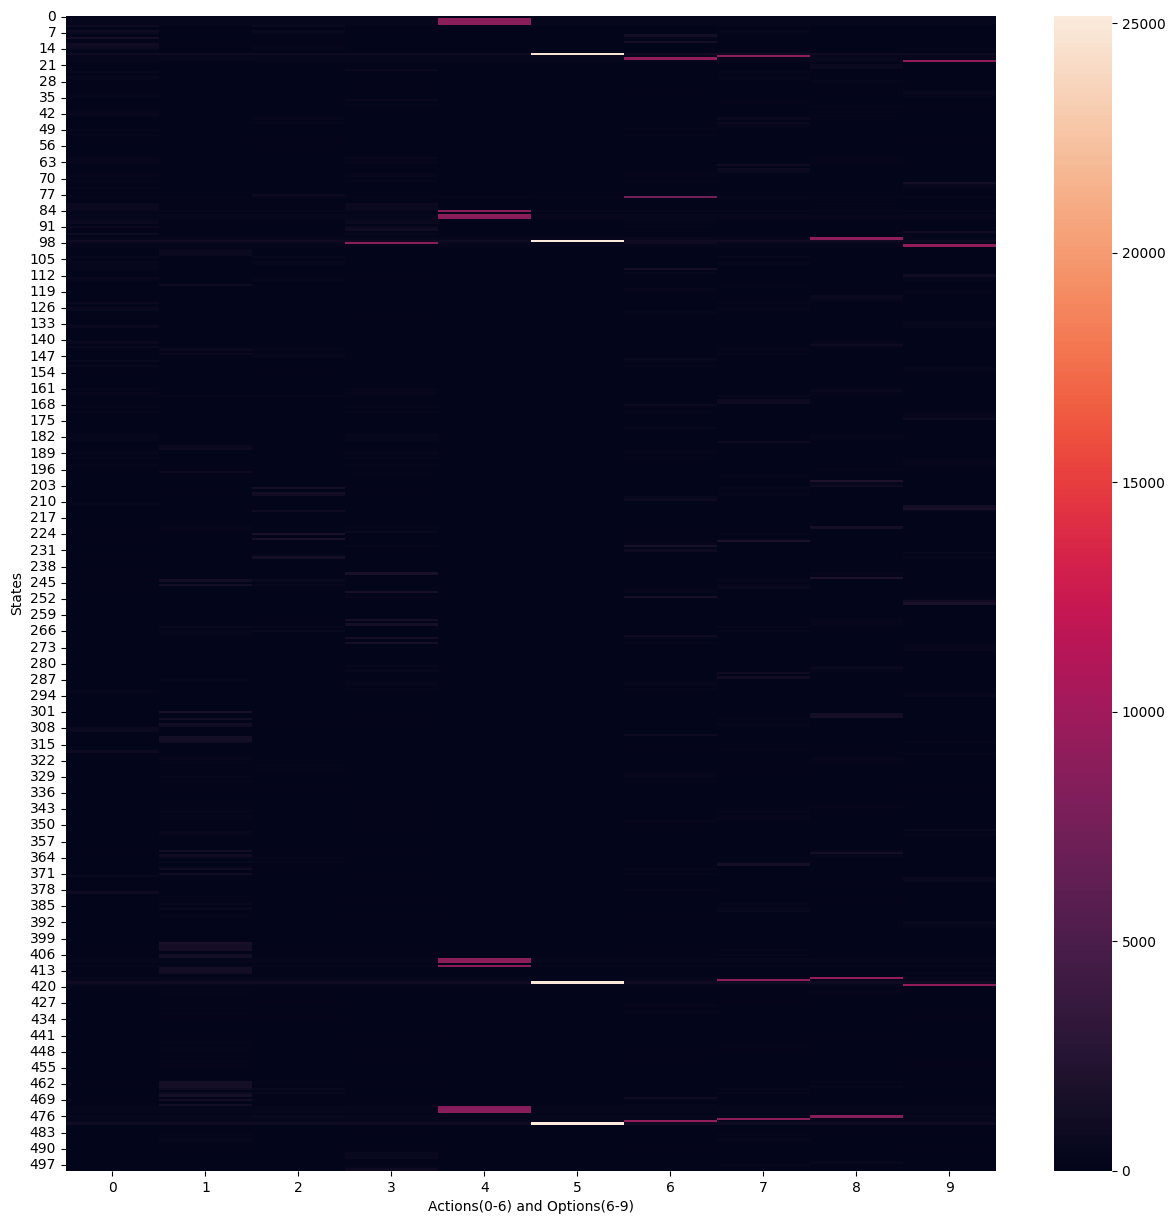

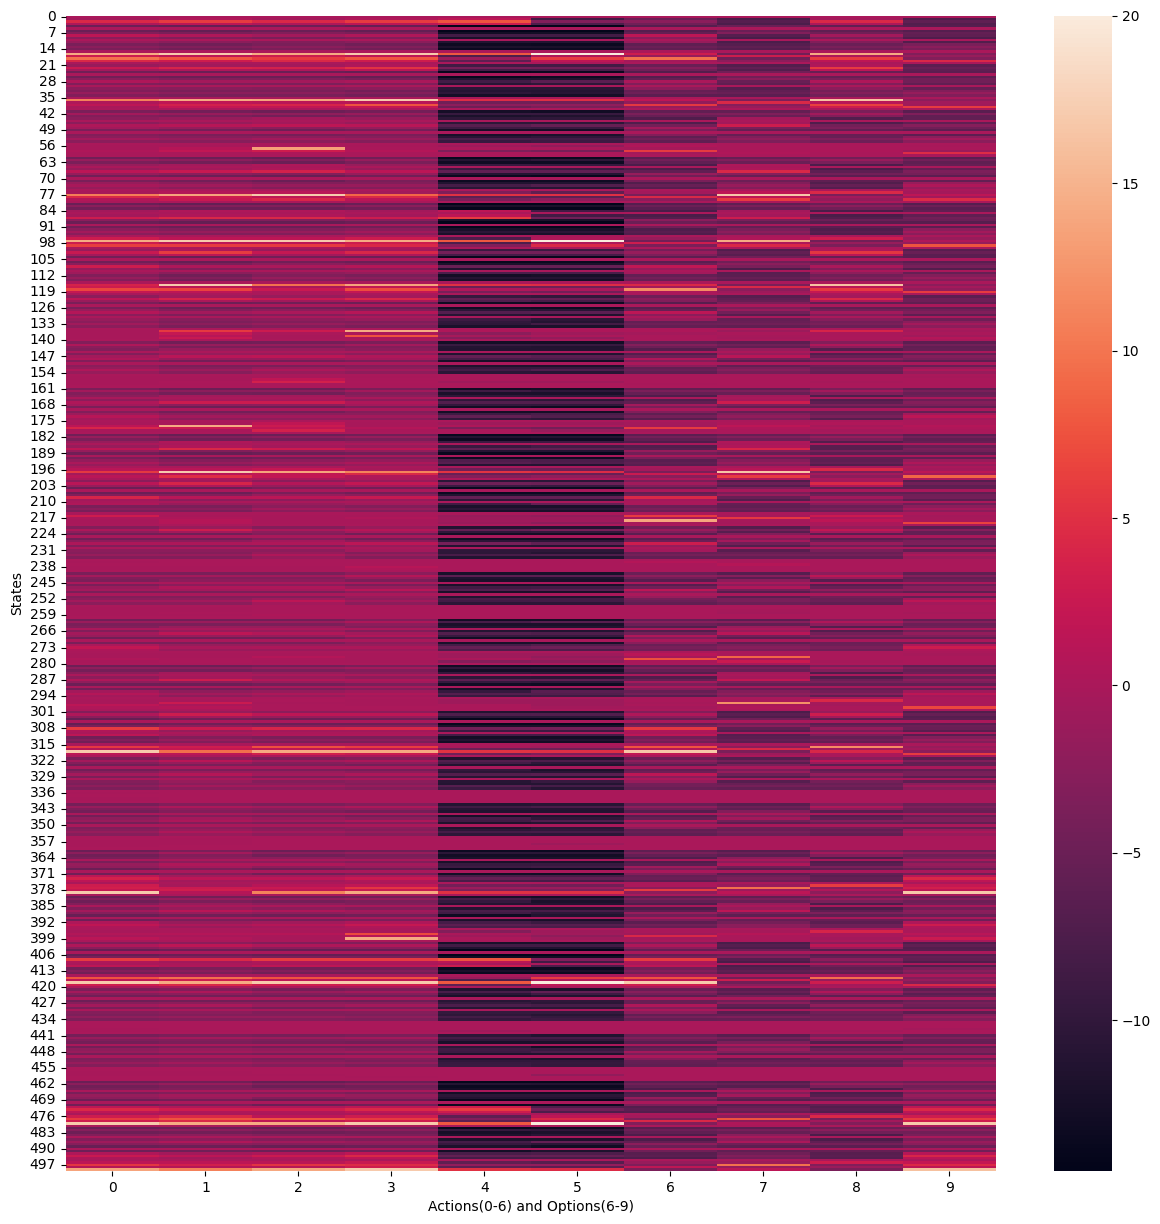

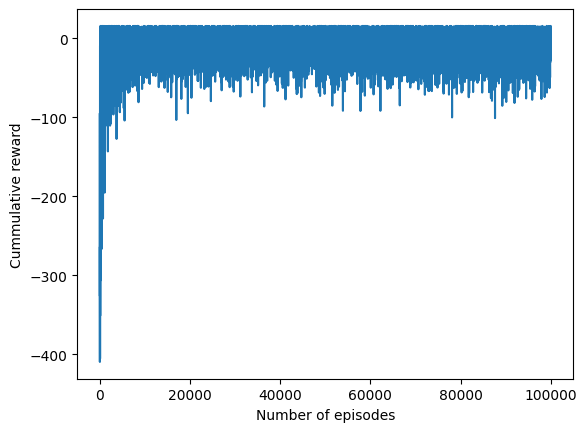

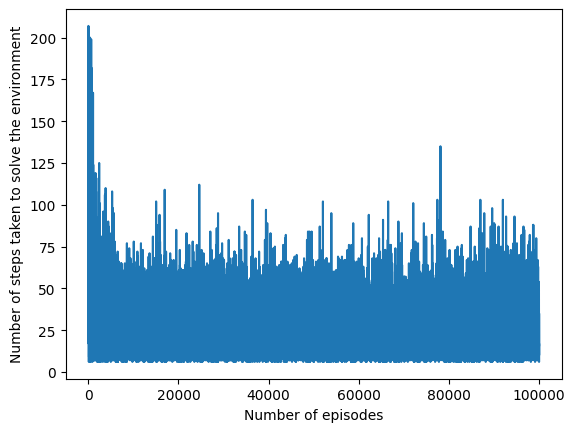

Avergae reward the agent earned on an average of 1000 episodes:  7.79


wandb: Agent Starting Run: np1pkmi1 with config:
wandb: 	EPS: 0.29815158860219293
wandb: 	LR: 0.01
wandb: 	NUM_EPISODES: 100000


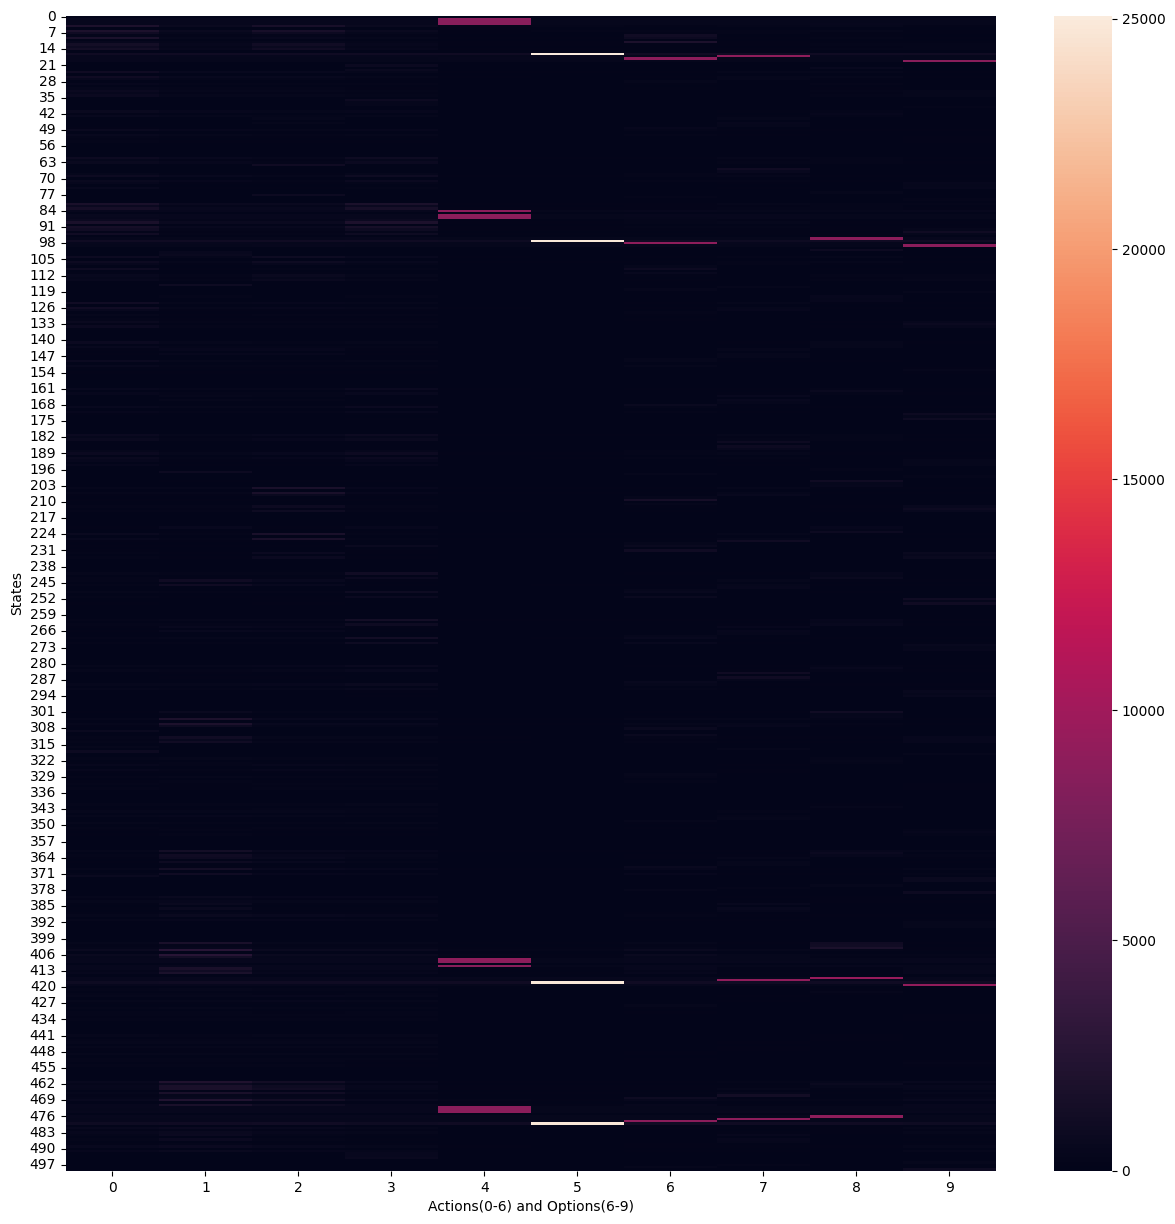

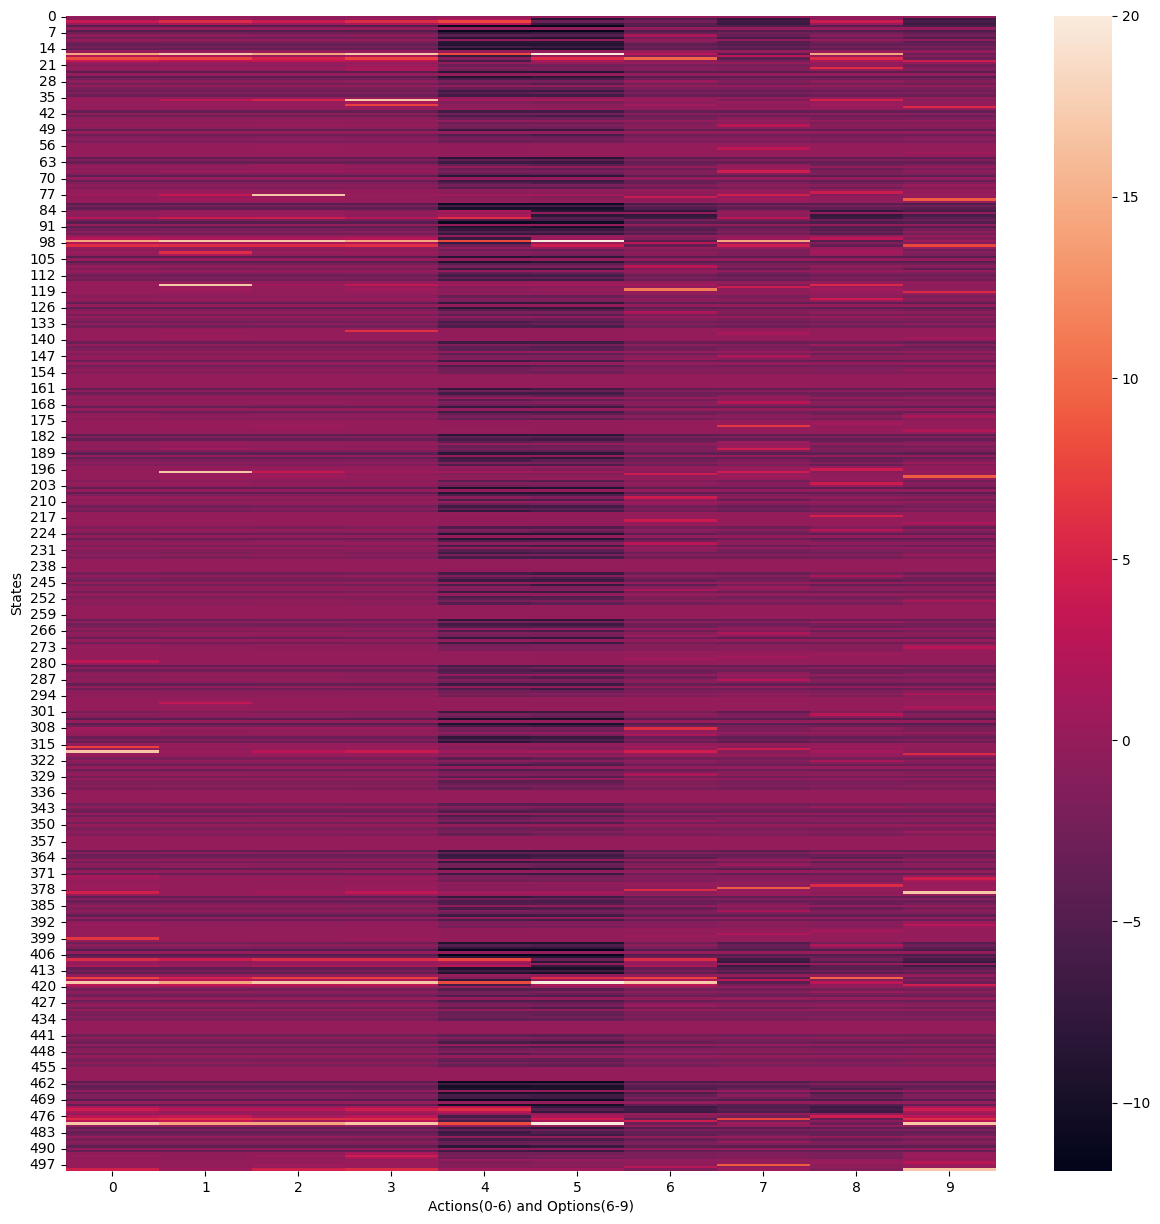

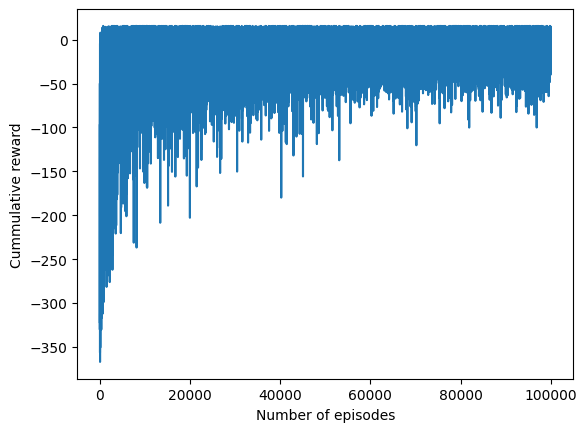

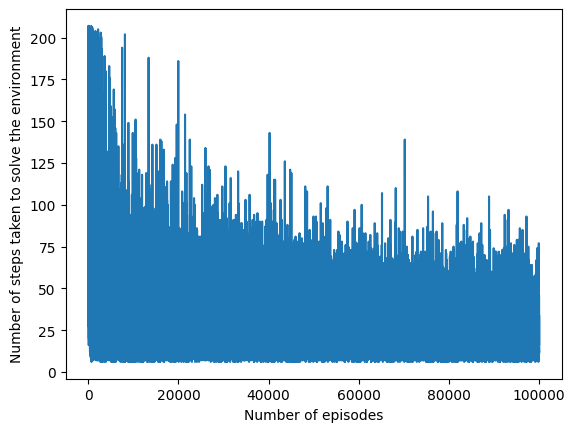

Avergae reward the agent earned on an average of 1000 episodes:  -8.53


wandb: Agent Starting Run: kpd3lqdm with config:
wandb: 	EPS: 0.2979008443974848
wandb: 	LR: 0.2
wandb: 	NUM_EPISODES: 100000


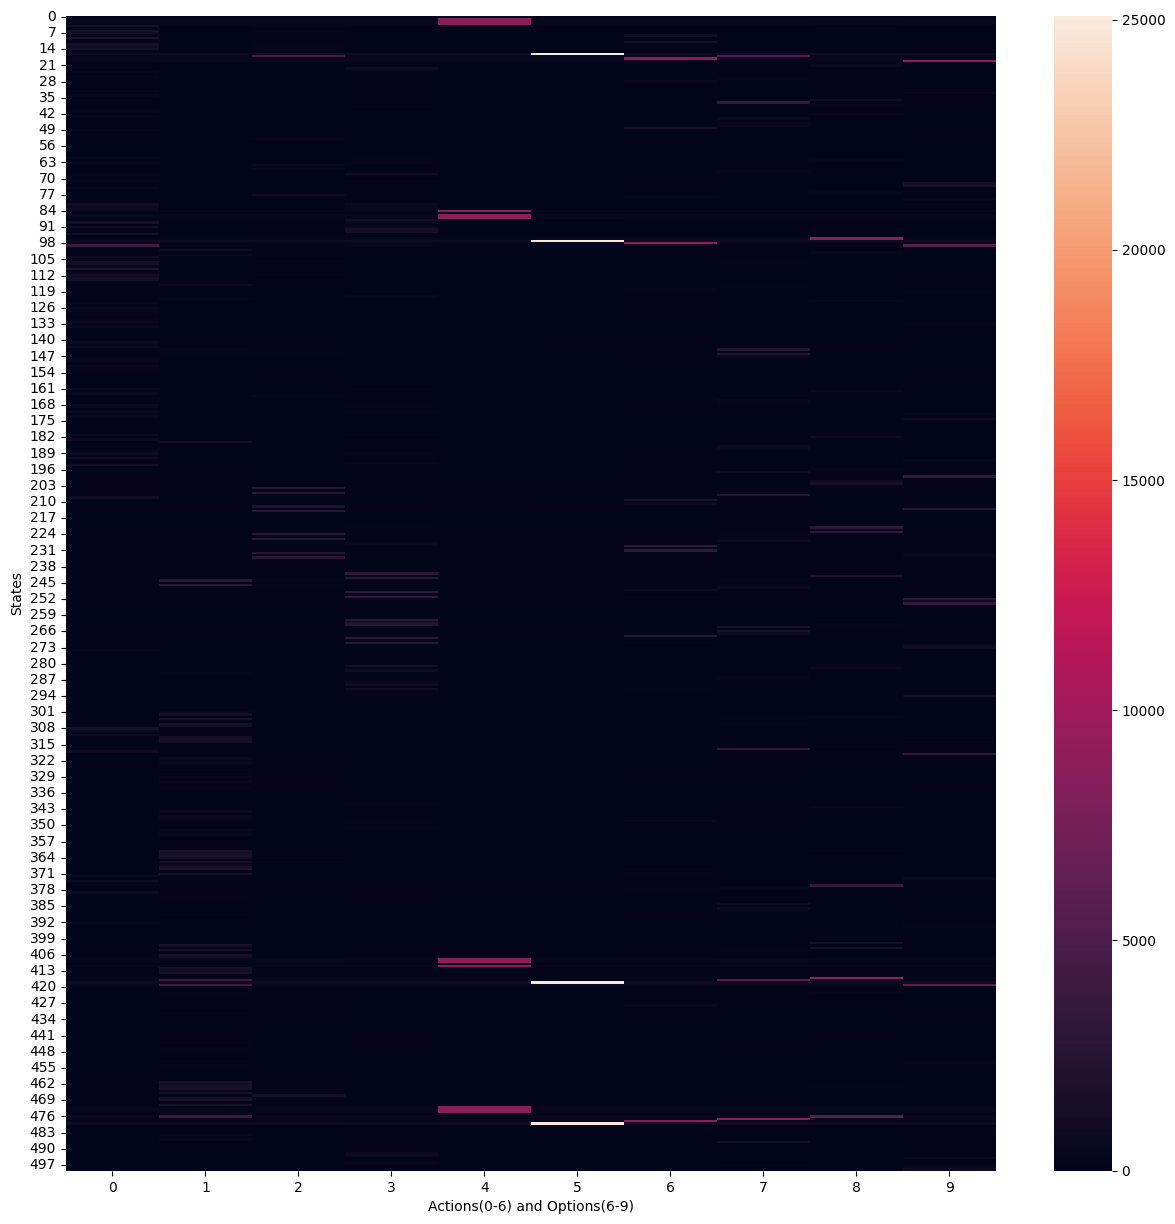

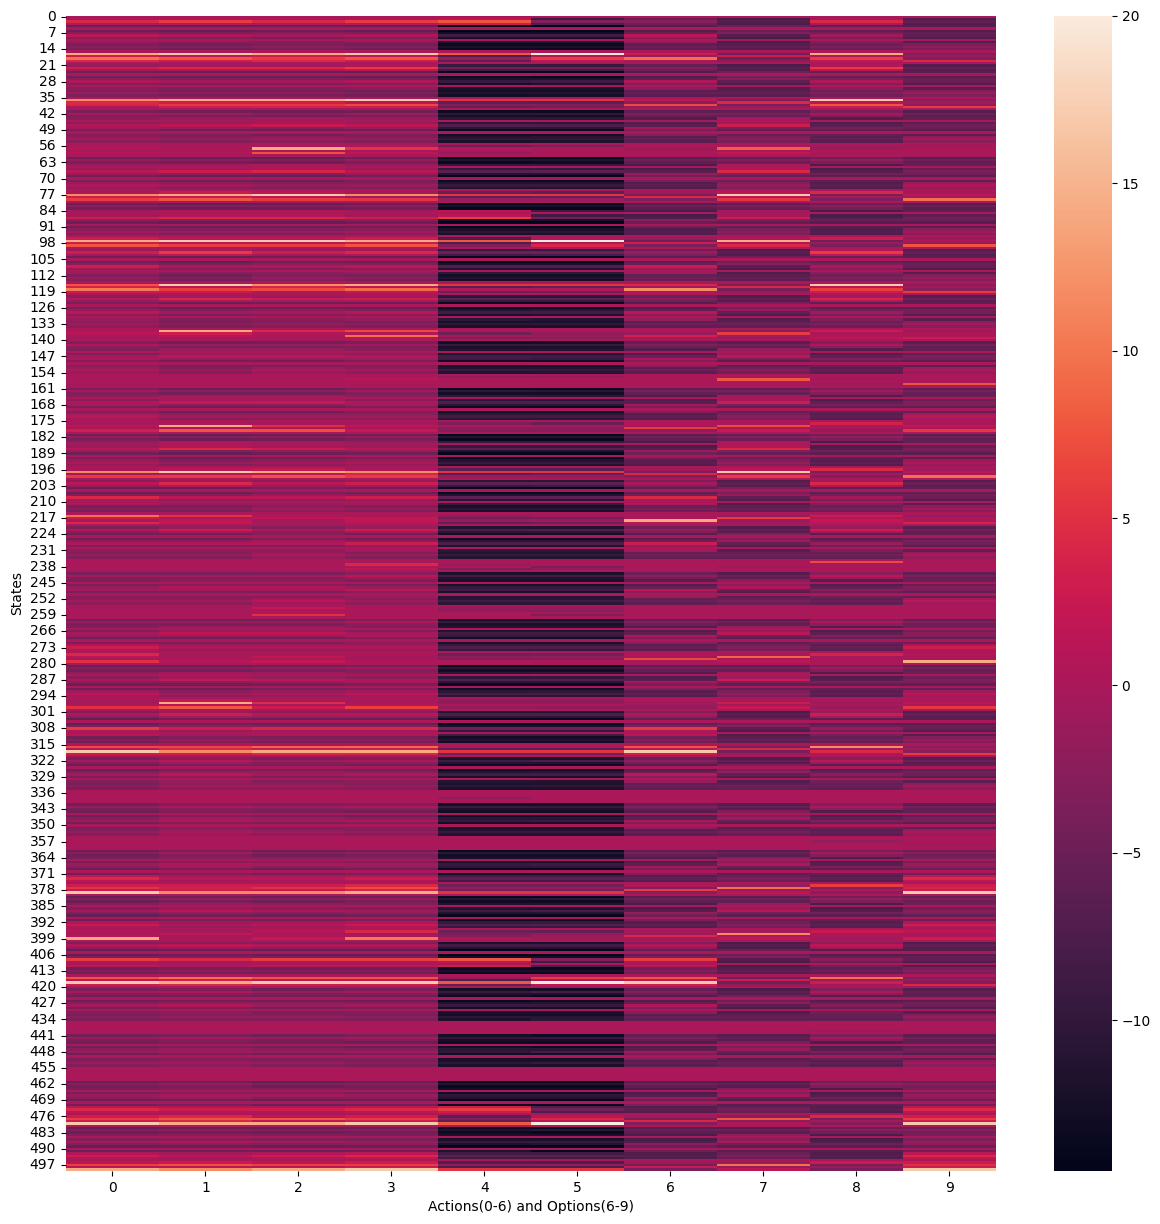

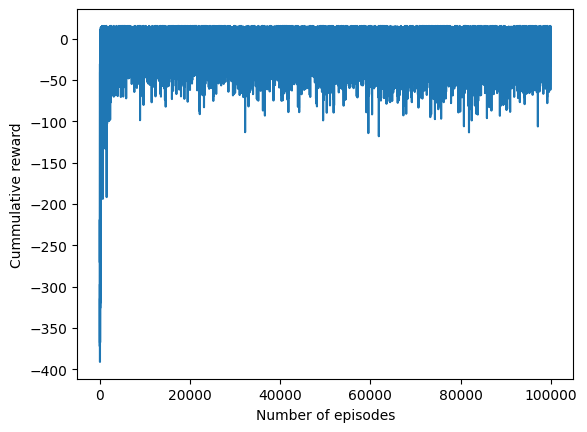

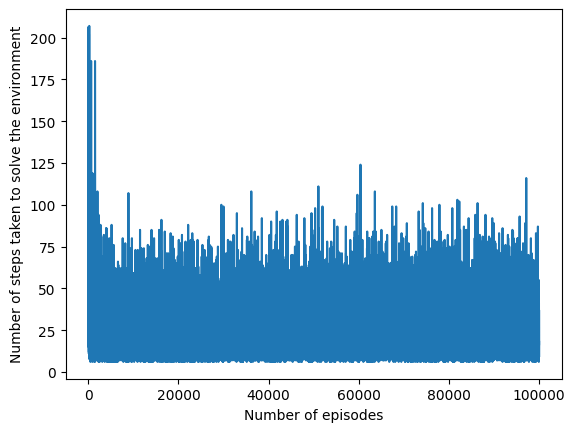

Avergae reward the agent earned on an average of 1000 episodes:  7.937


wandb: Agent Starting Run: ssz6ljjj with config:
wandb: 	EPS: 0.22870482588437543
wandb: 	LR: 0.3
wandb: 	NUM_EPISODES: 100000


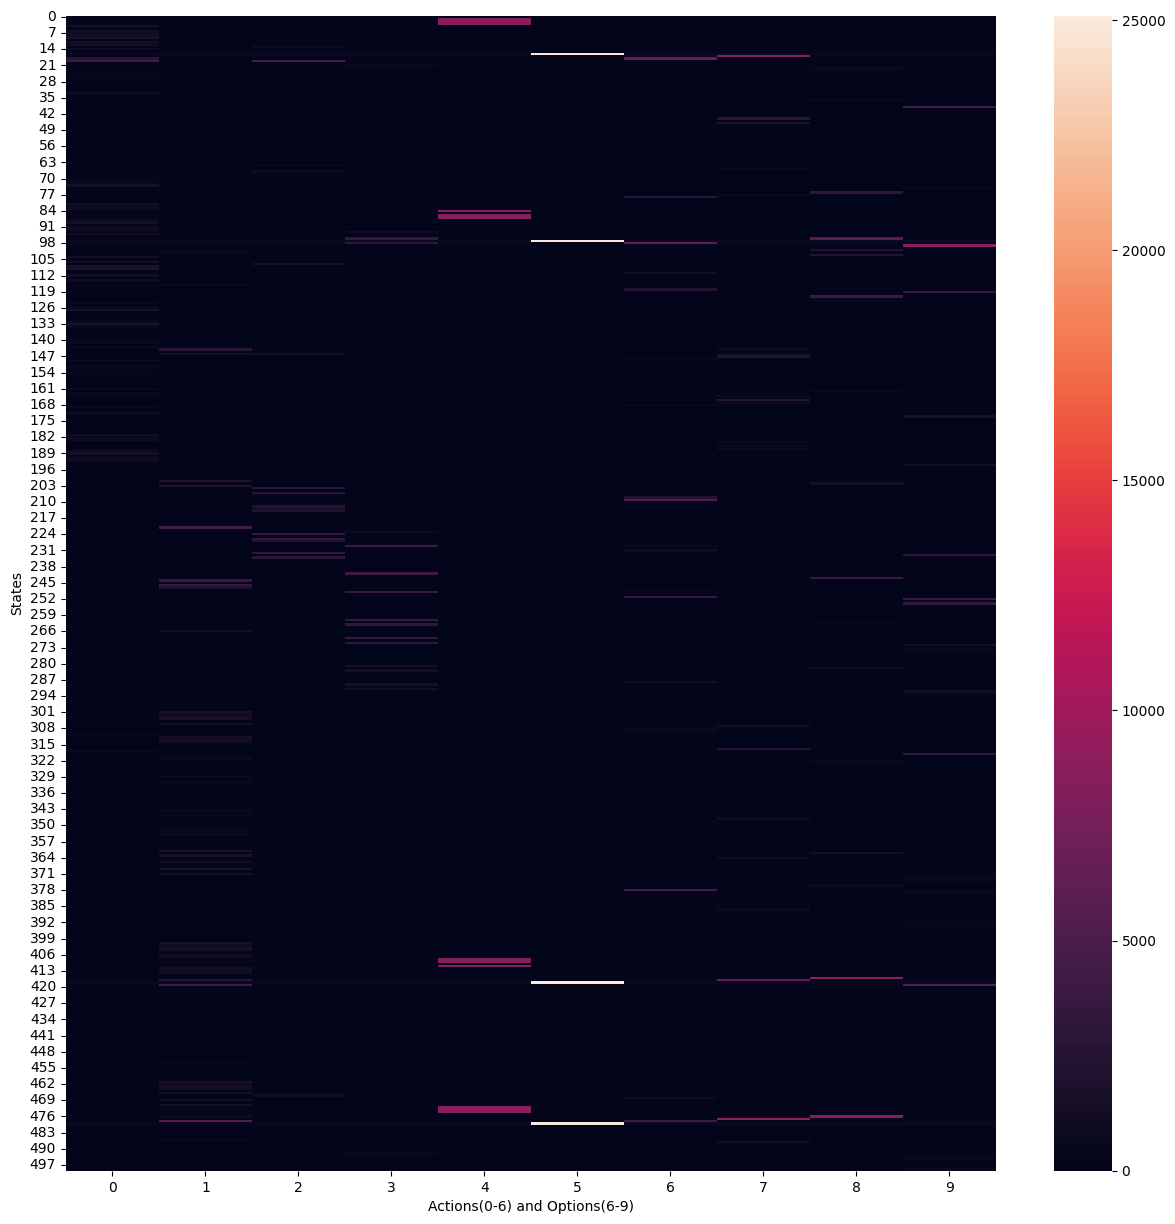

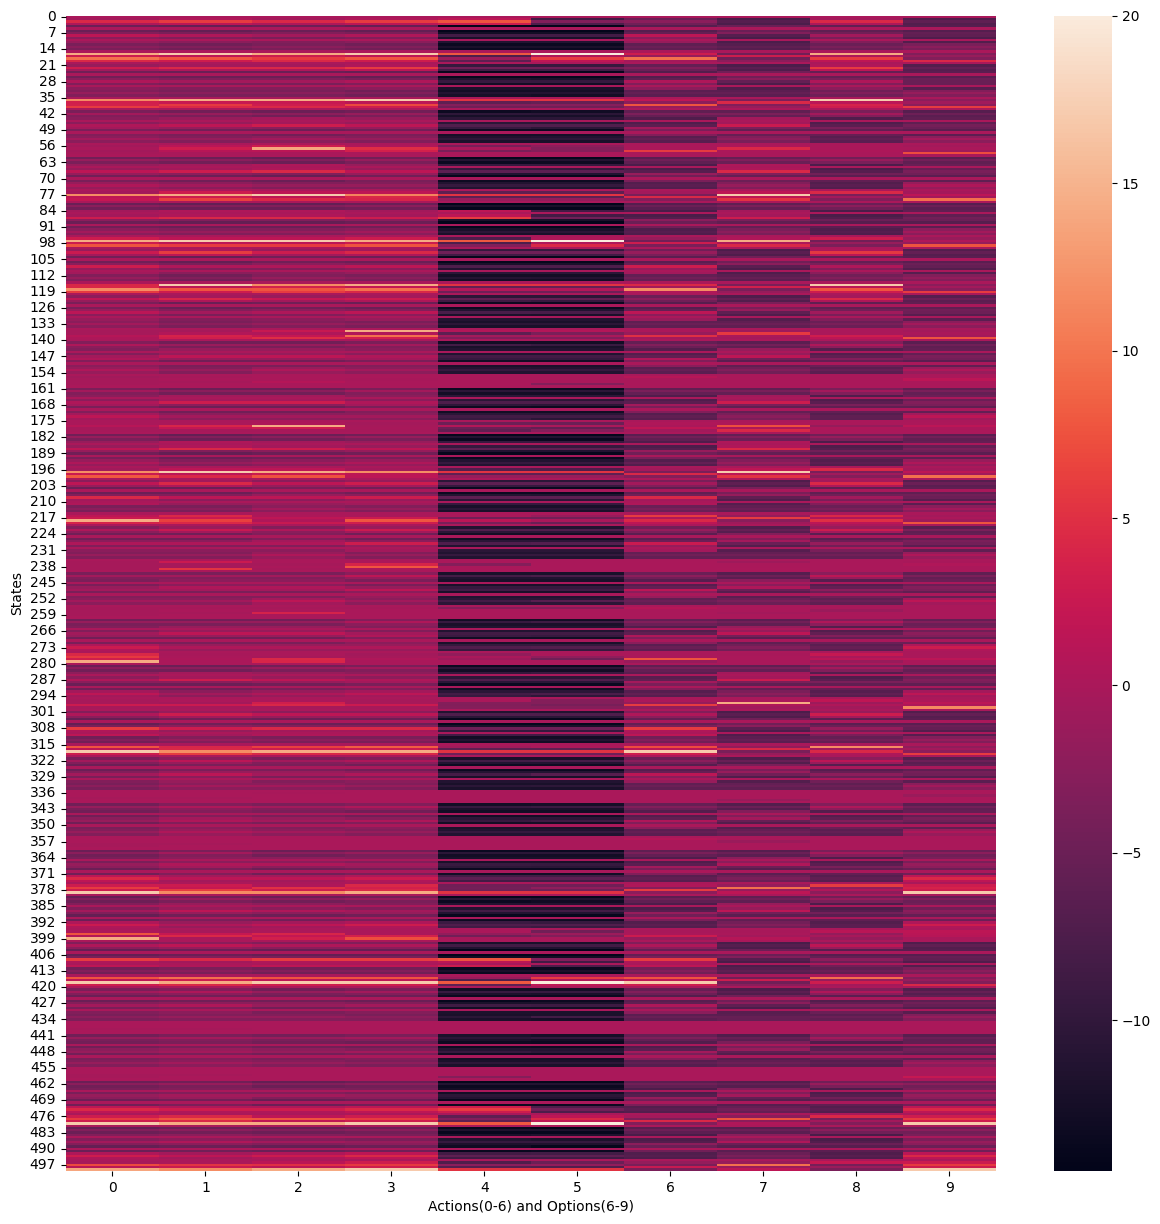

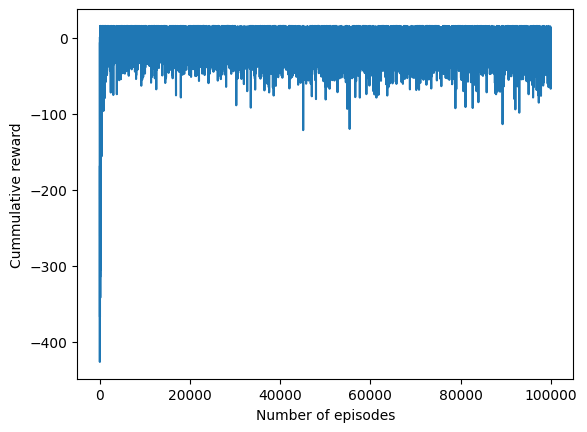

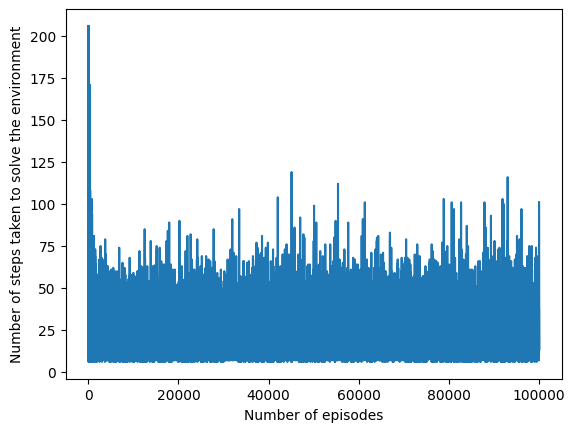

Avergae reward the agent earned on an average of 1000 episodes:  7.934


wandb: Agent Starting Run: 6ttulk1s with config:
wandb: 	EPS: 0.2899432682921267
wandb: 	LR: 0.5
wandb: 	NUM_EPISODES: 50000


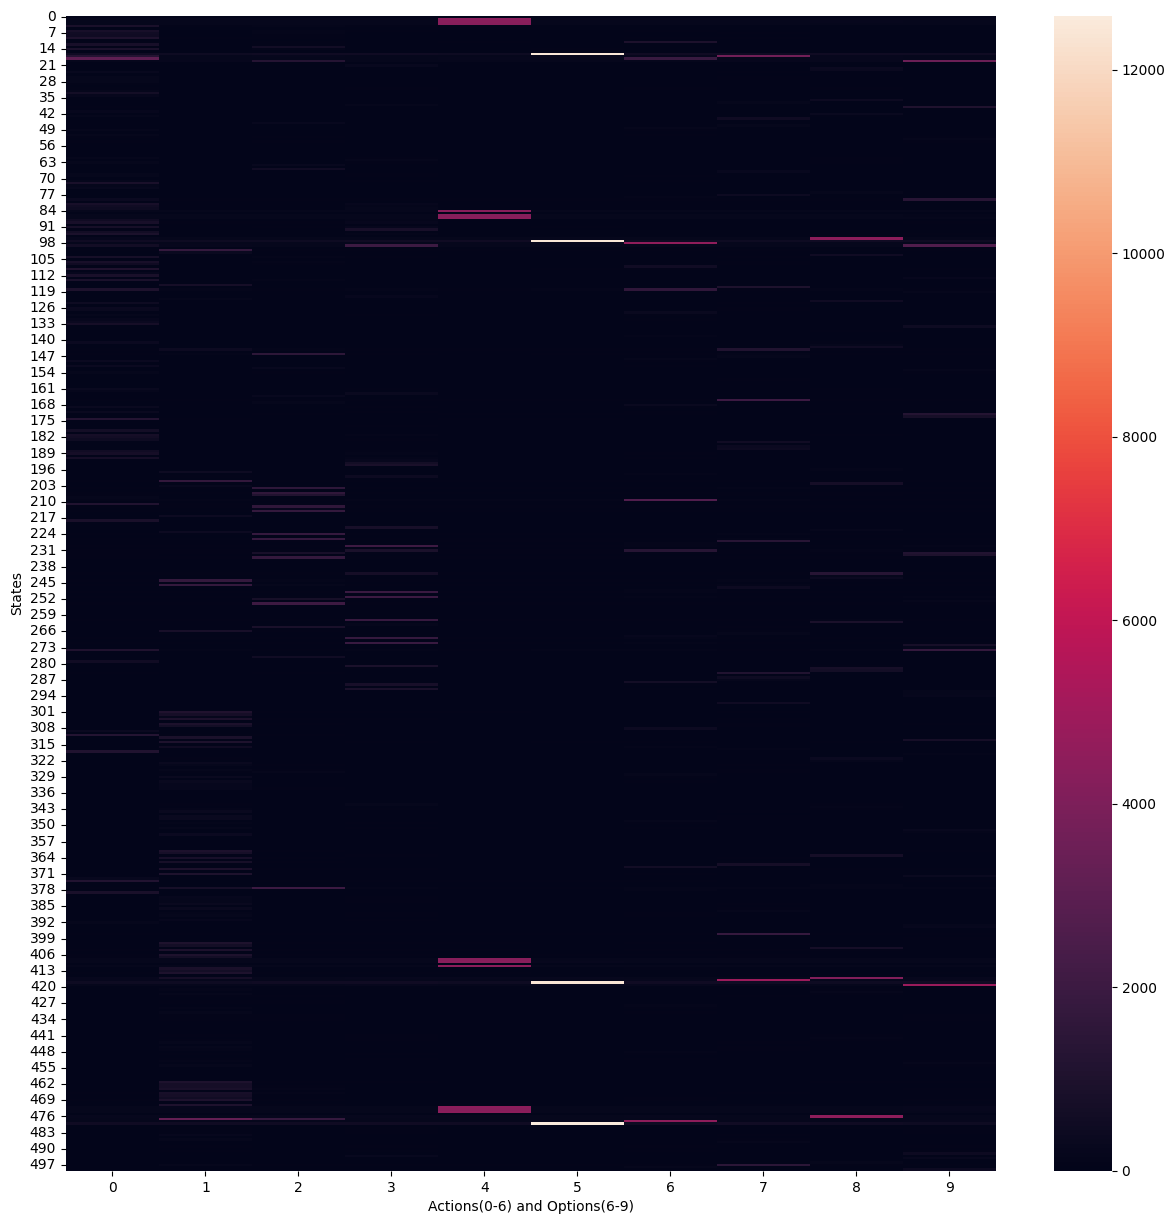

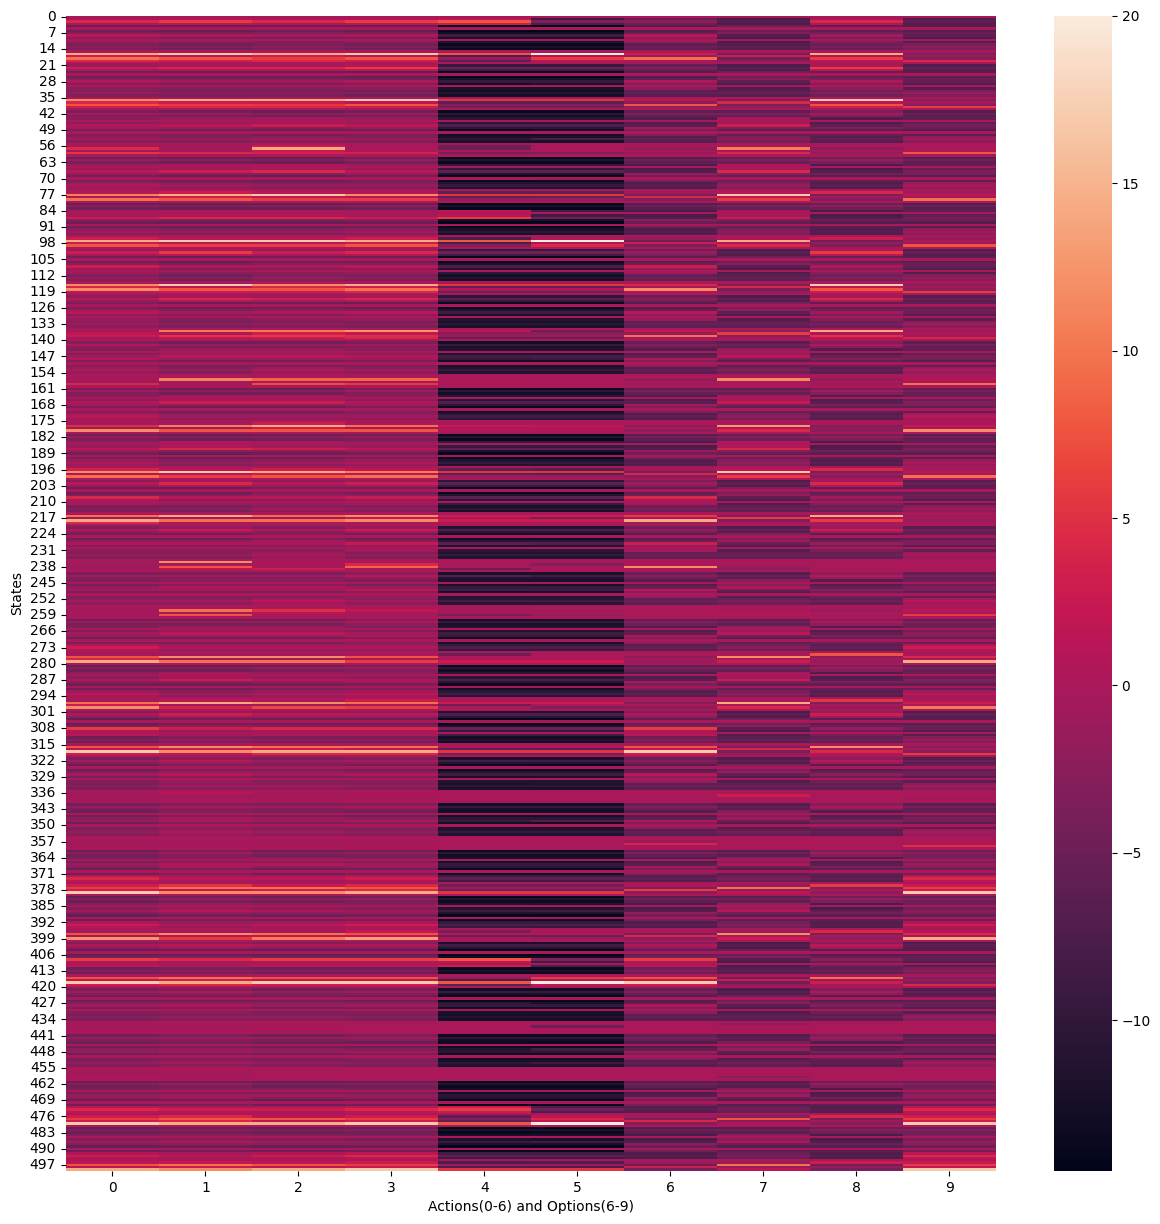

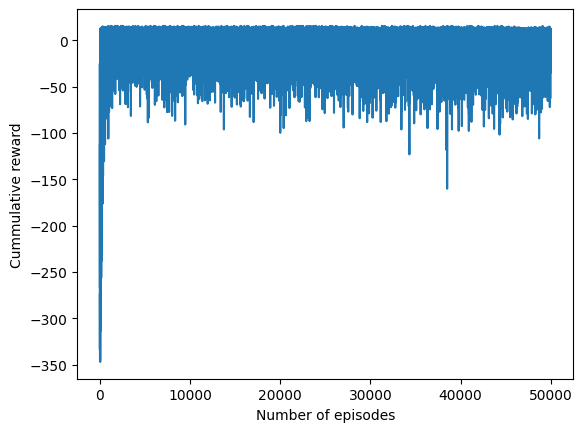

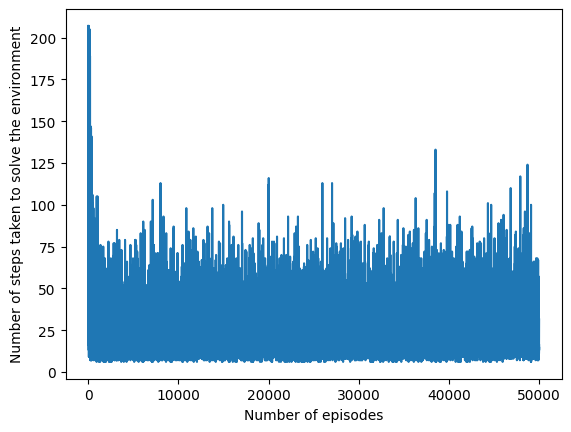

Avergae reward the agent earned on an average of 1000 episodes:  7.91


wandb: Agent Starting Run: w0lyec01 with config:
wandb: 	EPS: 0.12184677684924965
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


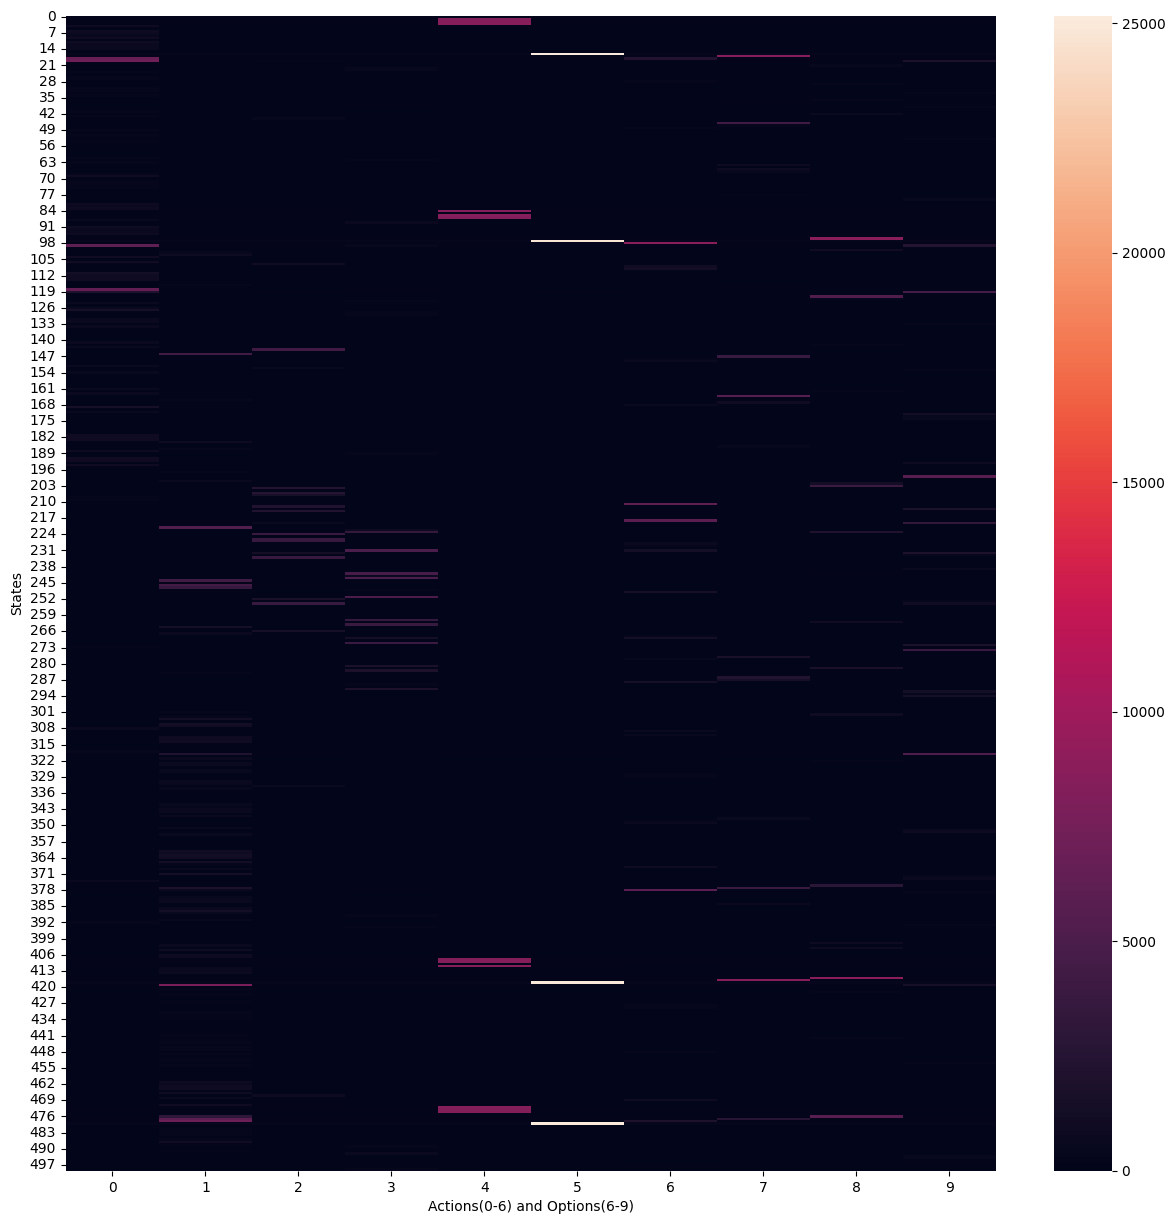

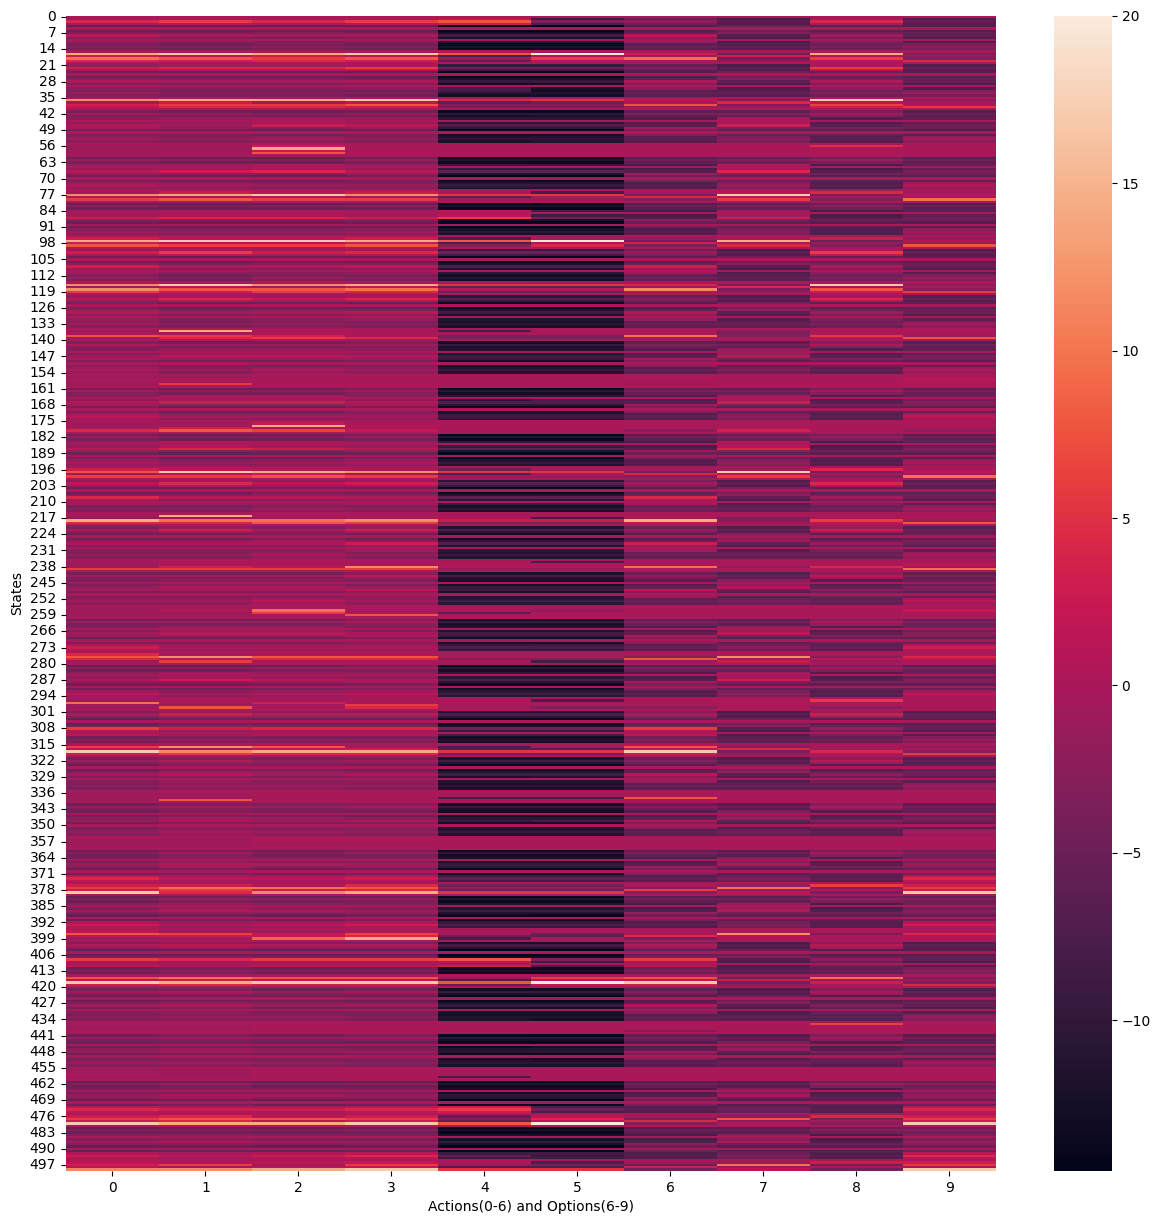

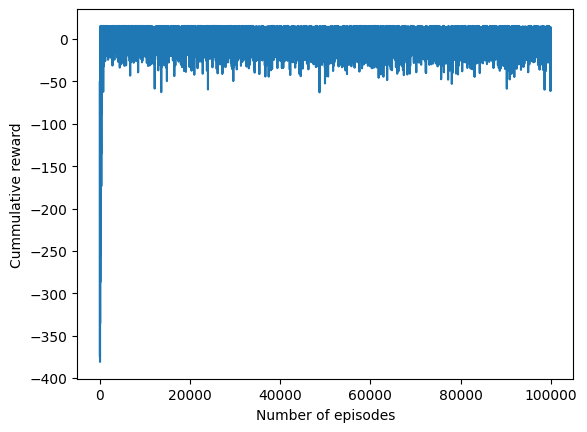

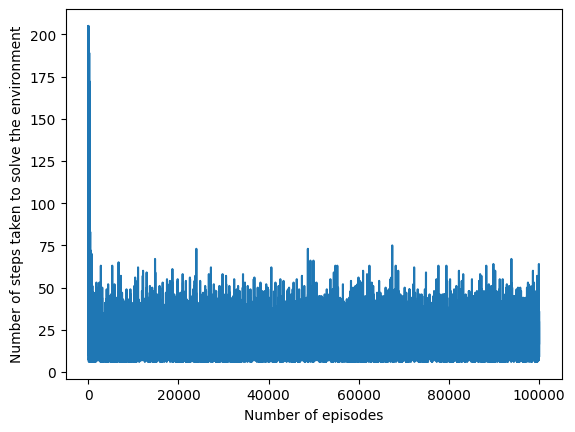

Avergae reward the agent earned on an average of 1000 episodes:  8.033


wandb: Agent Starting Run: wxqde46f with config:
wandb: 	EPS: 0.12184713848565766
wandb: 	LR: 0.8
wandb: 	NUM_EPISODES: 100000


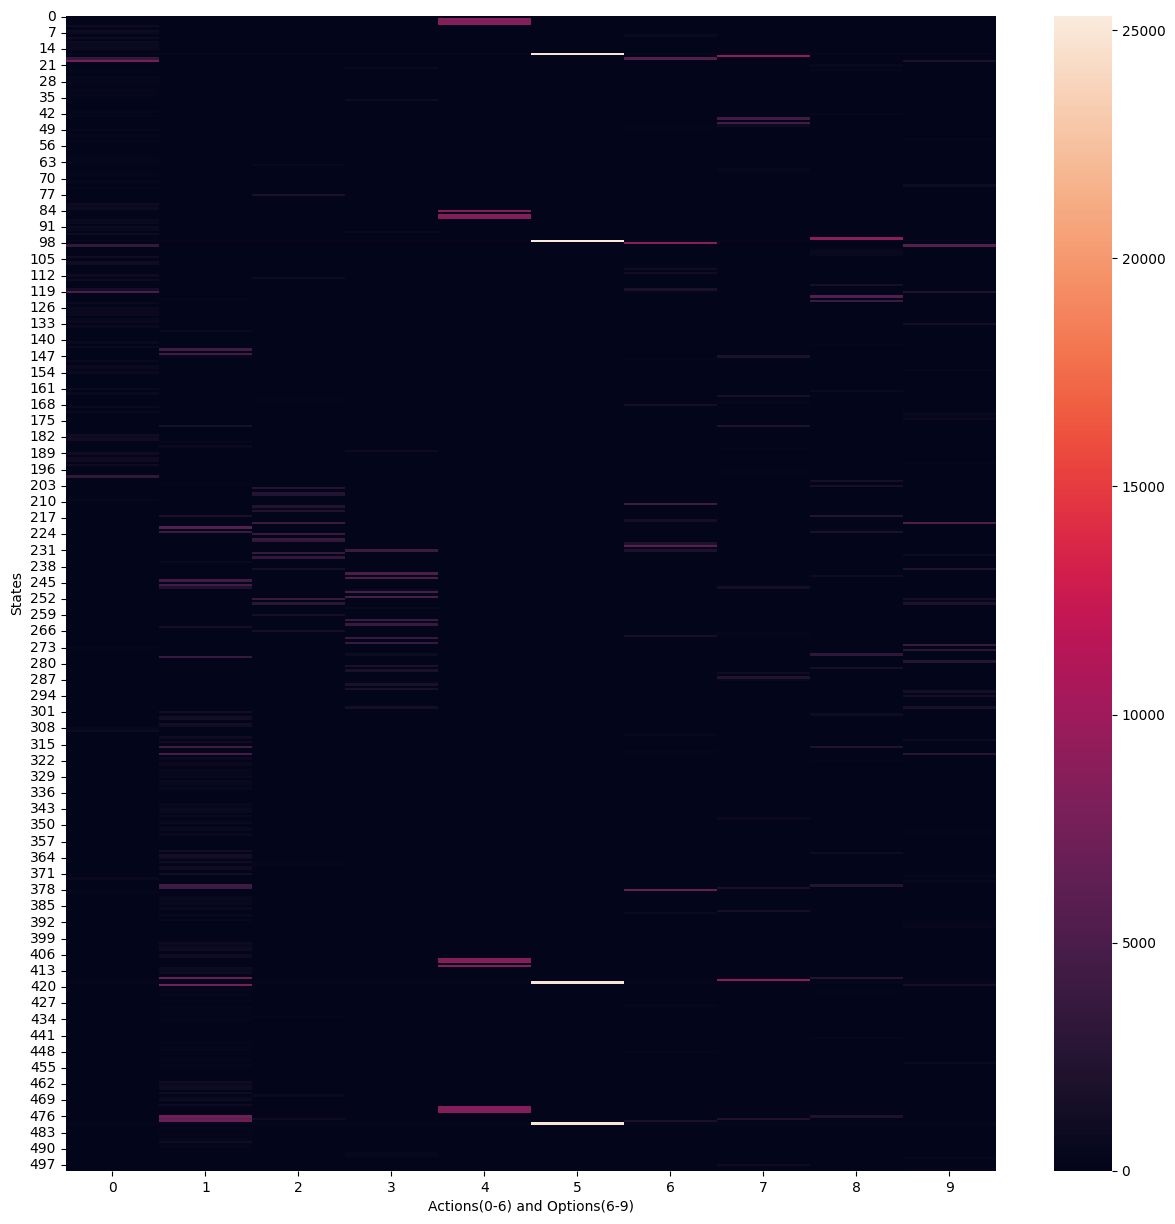

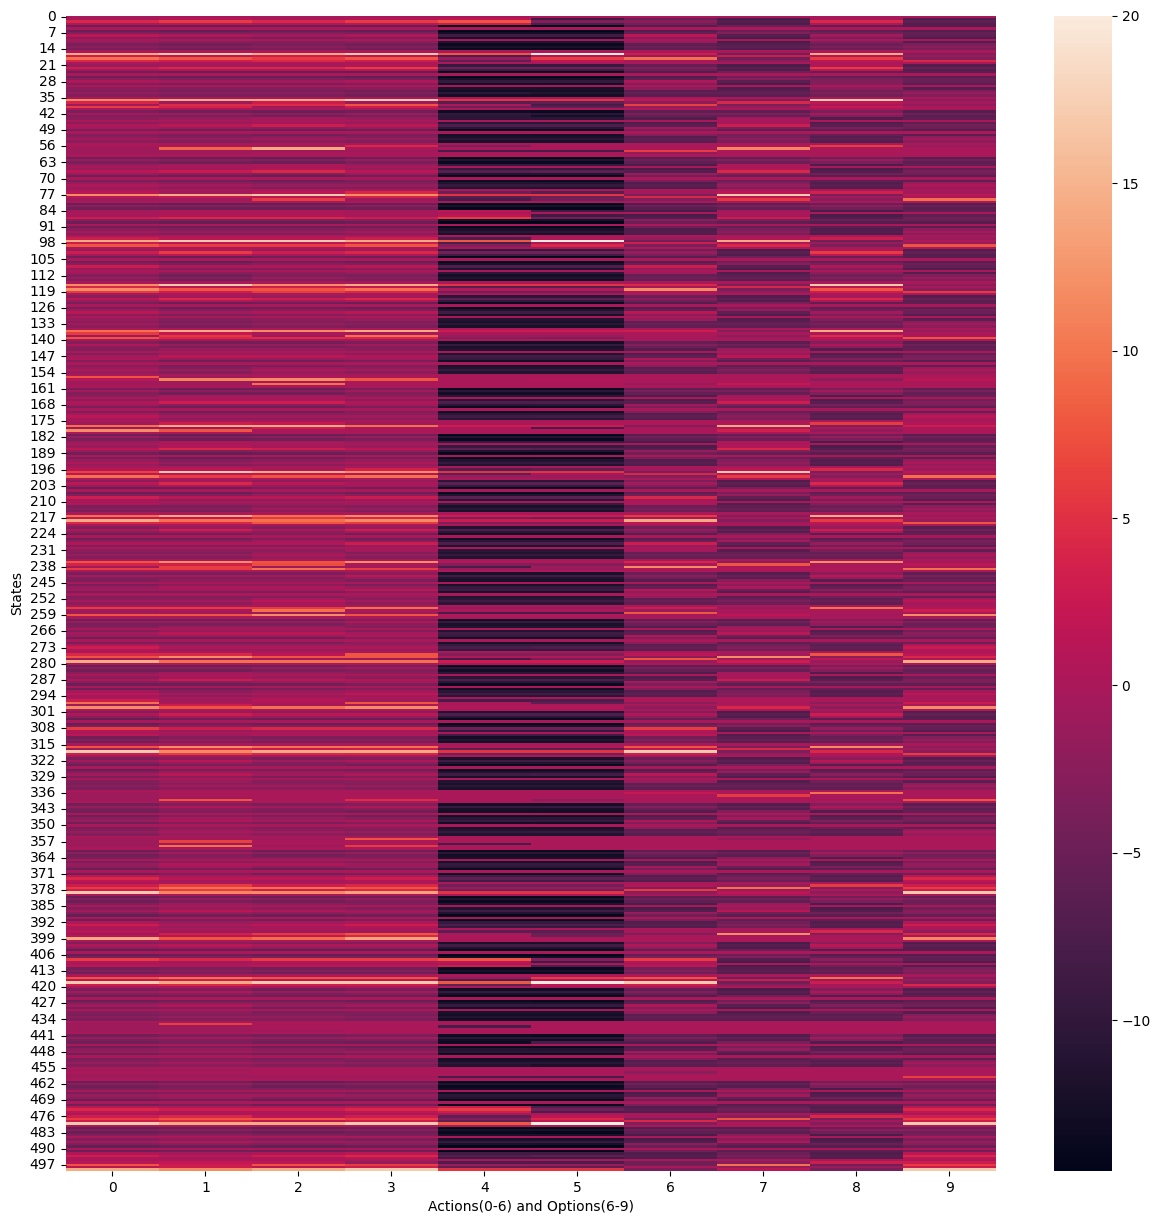

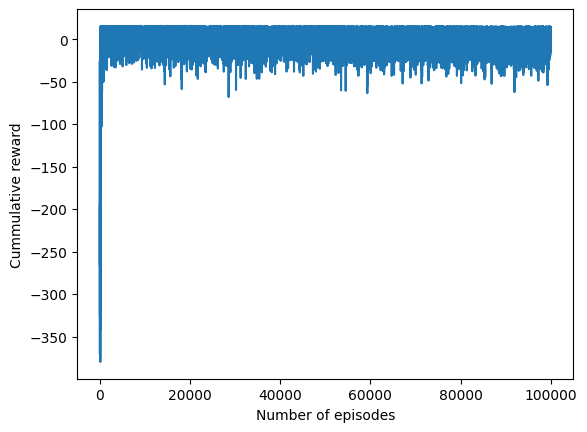

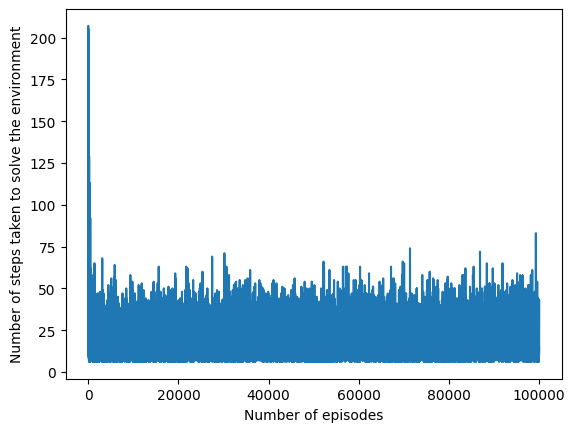

Avergae reward the agent earned on an average of 1000 episodes:  7.899


In [13]:
wandb.agent(sweep_id, train, count=25)

In [8]:
def SMDP_Learning_(ALPHA,GAMMA,EPS,NUM_EPS):
  
  actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
  termination_dict = {6:20,7:4,8:0,9:23}
  options             = [None,None,None,None,None,None,policy_y,policy_g,policy_r,policy_b]
  Q_SMDP = np.zeros((env.observation_space.n,len(actions))) 
  Update_Frequency_SMDP_q_learning = np.zeros((env.observation_space.n,len(actions)))
  alpha = ALPHA
  gamma = GAMMA
  cumul_reward_SMDP = []
  def average_episode_time(Q):
    steps = []
    trajectories_ep = []
    rewards = []
    for i in range(1000):
      state = env.reset()
      done = False
      t = 0
      r = 0
      trajectory = []
      while not done:
        action = np.argmax(Q[state])
        if action<6:
          next_state,reward,done,_ = env.step(action)
          r+=reward
          trajectory.append([state,action,next_state,reward,False])
          state = next_state
          t+=1
        if action>=6:
          optdone = False
          while not optdone:

            row_t,col_t,_,_ = env.decode(state)
            optaction = options[action][row_t][col_t] 
            next_state,reward,done,_ = env.step(optaction)
            r+=reward
            trajectory.append([state,optaction,next_state,reward,True])
            t+=1
            state= next_state
            row_t_1,col_t_1,_,_ = env.decode(next_state)
            next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
            if next_state_is_terminal:
              optdone = True
            state = next_state
      steps.append(t)
      rewards.append(r)
      trajectories_ep.append(trajectory)


    #print("Average number of steps taken for given hyperparameters is: ",np.array(steps).mean())
    return(np.array(steps).mean()),(np.array(rewards).mean()),steps,trajectories_ep
  def return_action(state,epsilon,Q):
    if np.random.rand()>eps:
      return np.argmax(Q[state])
    else:
      return np.random.choice(np.arange((len(actions))),1)[0]
  # While episode is not over
  # Iterate over 1000 episodes
  ep_steps = []
  for ep in range(int(NUM_EPS)):
      #print(ep)
      state = env.reset()    
      done = False
      r = 0
      t = 0
      # While episode is not over
      while not done:
      
          eps = max((0.99**ep)*0.9,EPS)
          # Choose action        
          action = return_action(state,eps,Q_SMDP)
          
          # Checking if primitive action
          if action < 6:
              # Perform regular Q-Learning update for state-action pair
              next_state, reward, done,_ = env.step(action)
              #r+= gamma**(tmax-1) * reward
              r+=reward
              t +=1
              update = reward + gamma * max(Q_SMDP[next_state]) - Q_SMDP[state][action]
              Q_SMDP[state][action] +=  alpha*(update)
              Update_Frequency_SMDP_q_learning[state][action] += 1
              state = next_state
          
          # Checking if action chosen is an option
          
          if action>=6:
            reward_bar = 0
            current_state = state
            optdone = False
            tau = 0
            done_ = False
            while (optdone==False):
              taxi_row,taxi_col,_,_  = env.decode(state)
              optaction = options[action][taxi_row][taxi_col]
              next_state,reward,done,_ = env.step(optaction)
              tau +=1
              t+=1
              reward_bar = reward_bar + (gamma**(tau-1))*reward
              state = next_state
              row_t_1,col_t_1,_,_ = env.decode(next_state)
              next_state_is_terminal = True if (5*(row_t_1) + col_t_1) == termination_dict[action] else False 
              if next_state_is_terminal:
                optdone = True
            update = reward_bar + (gamma**(tau) * max(Q_SMDP[state])) - Q_SMDP[current_state][action]
            Q_SMDP[current_state][action] +=  alpha * update
            #r+= gamma**(tmax-1) * reward_bar
            r+=reward_bar
            Update_Frequency_SMDP_q_learning[current_state][action] += 1
      cumul_reward_SMDP.append(r)      
      ep_steps.append(t)    

  
  plt.figure(figsize = (15,15))
  sns.heatmap(Update_Frequency_SMDP_q_learning,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("Update_frequency ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  plt.figure(figsize = (15,15))
  sns.heatmap(Q_SMDP,annot = False)
  plt.xlabel("Actions(0-6) and Options(6-9)")
  plt.ylabel("States")
  plt.savefig(str("SMDP ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()
  
  plt.plot(cumul_reward_SMDP)
  plt.xlabel("Number of episodes")
  plt.ylabel("Cummulative reward")
  plt.savefig(str("Reward ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  plt.plot(ep_steps)
  plt.xlabel("Number of episodes")
  plt.ylabel("Number of steps taken to solve the environment")
  plt.savefig(str("time_steps ")+str(alpha)+str(EPS)+str(GAMMA)+".png")
  plt.show()

  
  mean_steps,mean_reward,_,_ =  average_episode_time(Q_SMDP)
  return mean_steps,mean_reward,Q_SMDP,Update_Frequency_SMDP_q_learning
  


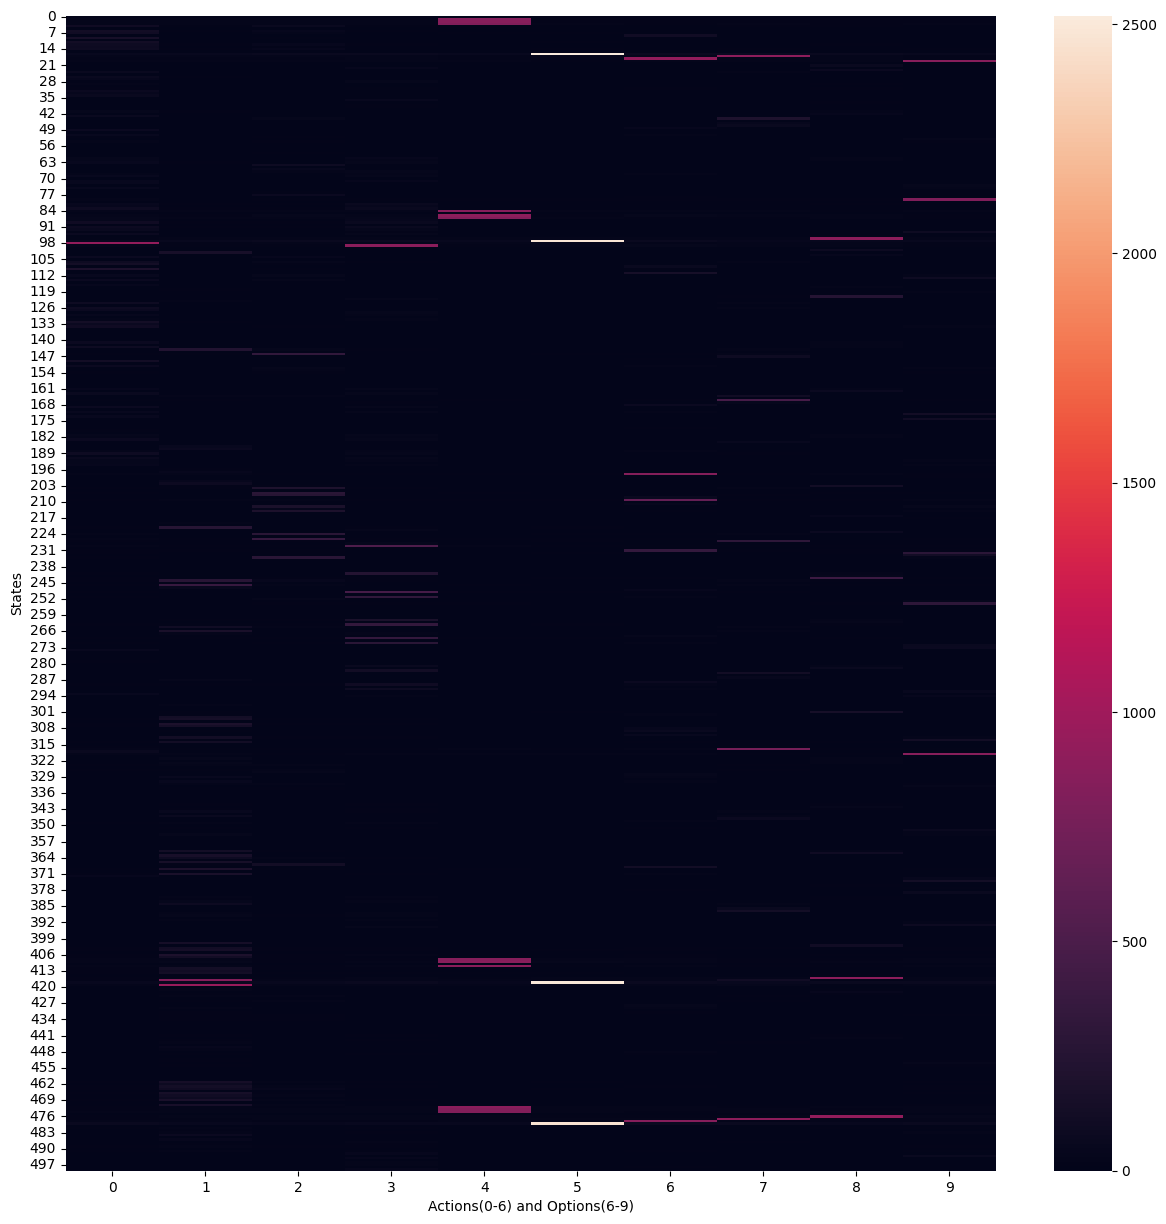

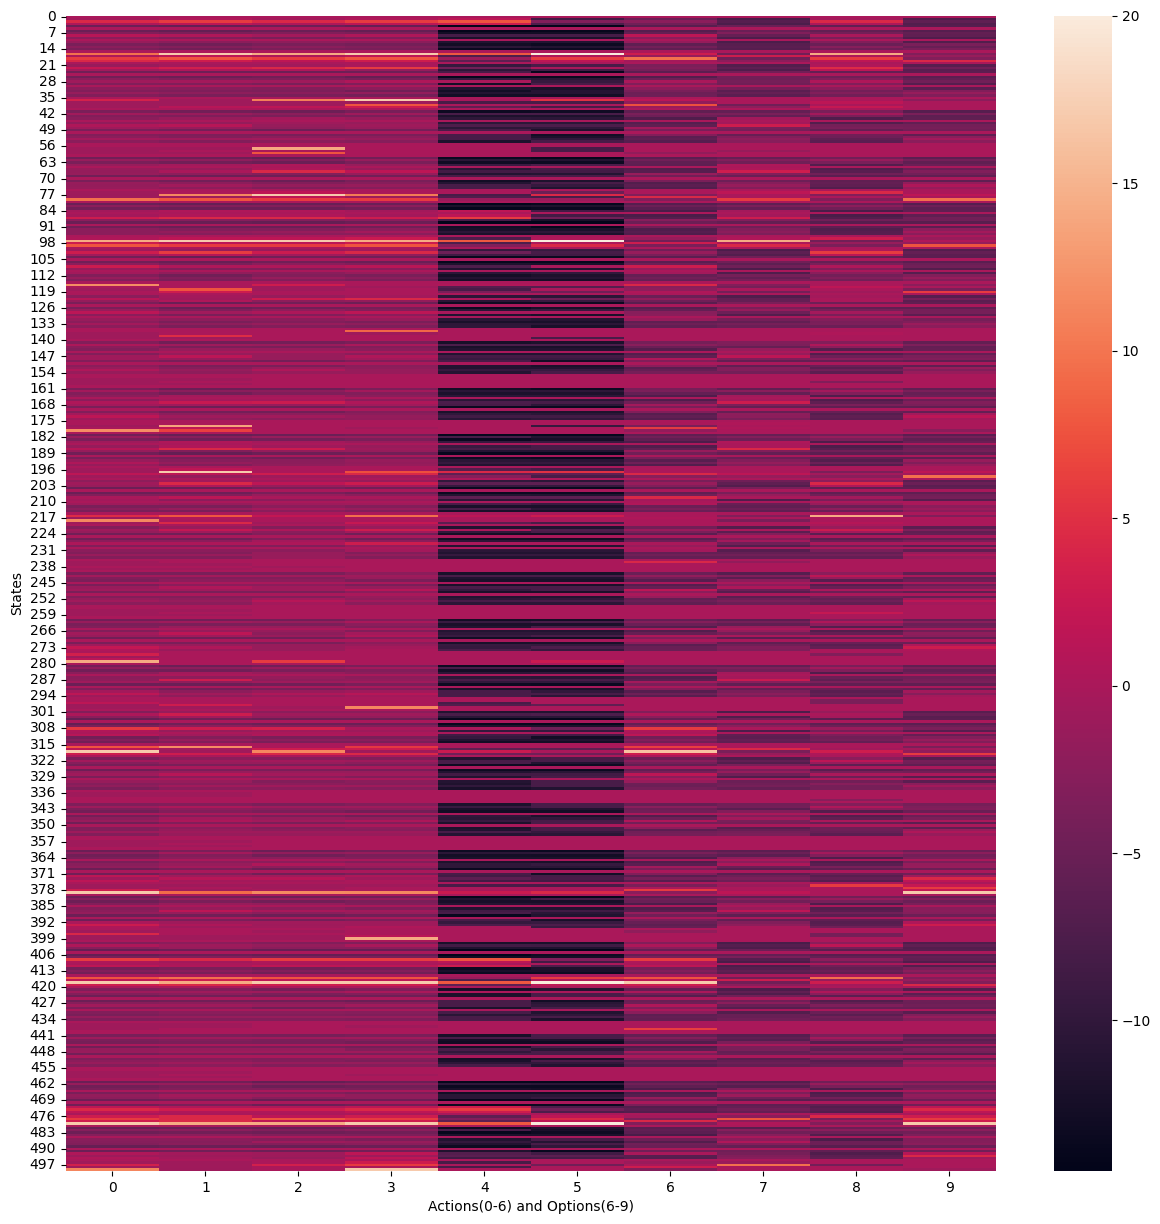

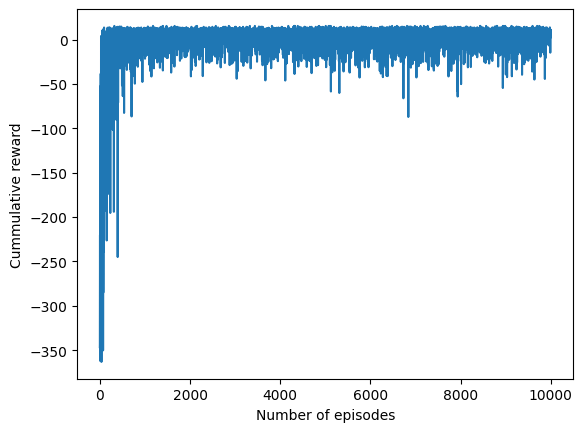

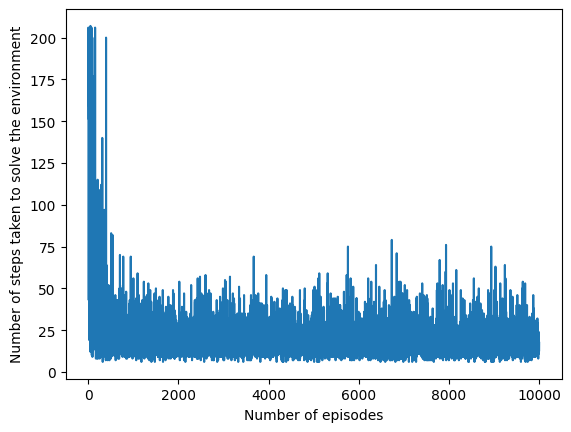

In [9]:
EP = 0.17893708108977718
LR =  0.8 	
NUM_EPISODES =  10000


mean_steps,mean_reward,Q_SMDP,Update_Frequency_SMDP_q_learning = SMDP_Learning(0.8,0.9,0.1789,10000)



In [11]:
sns.heatmap(Q_SMDP)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: >

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


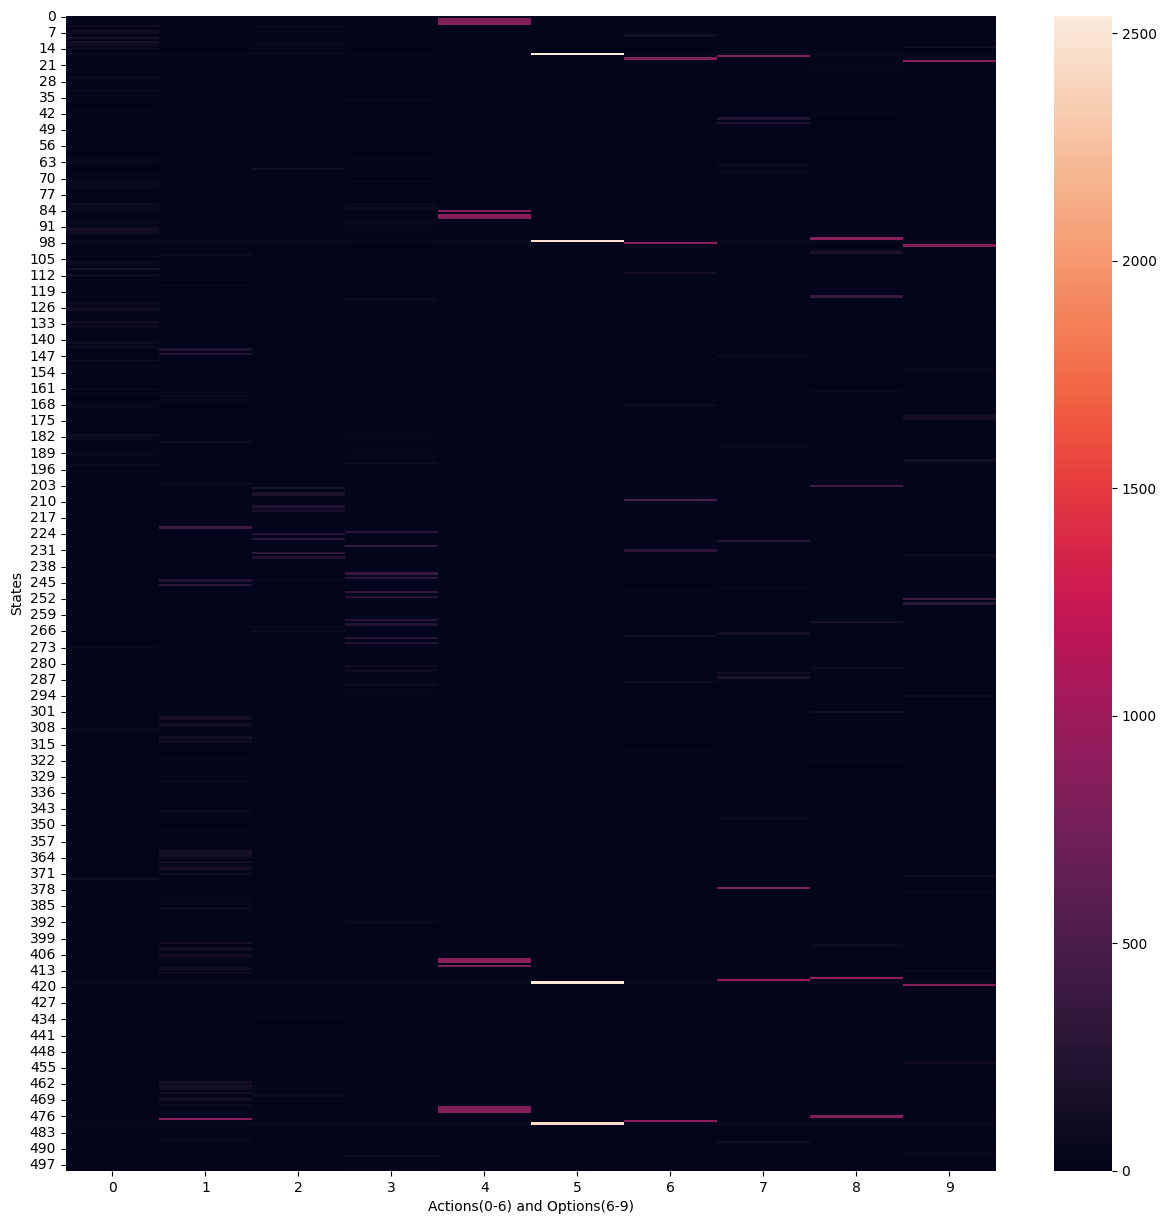

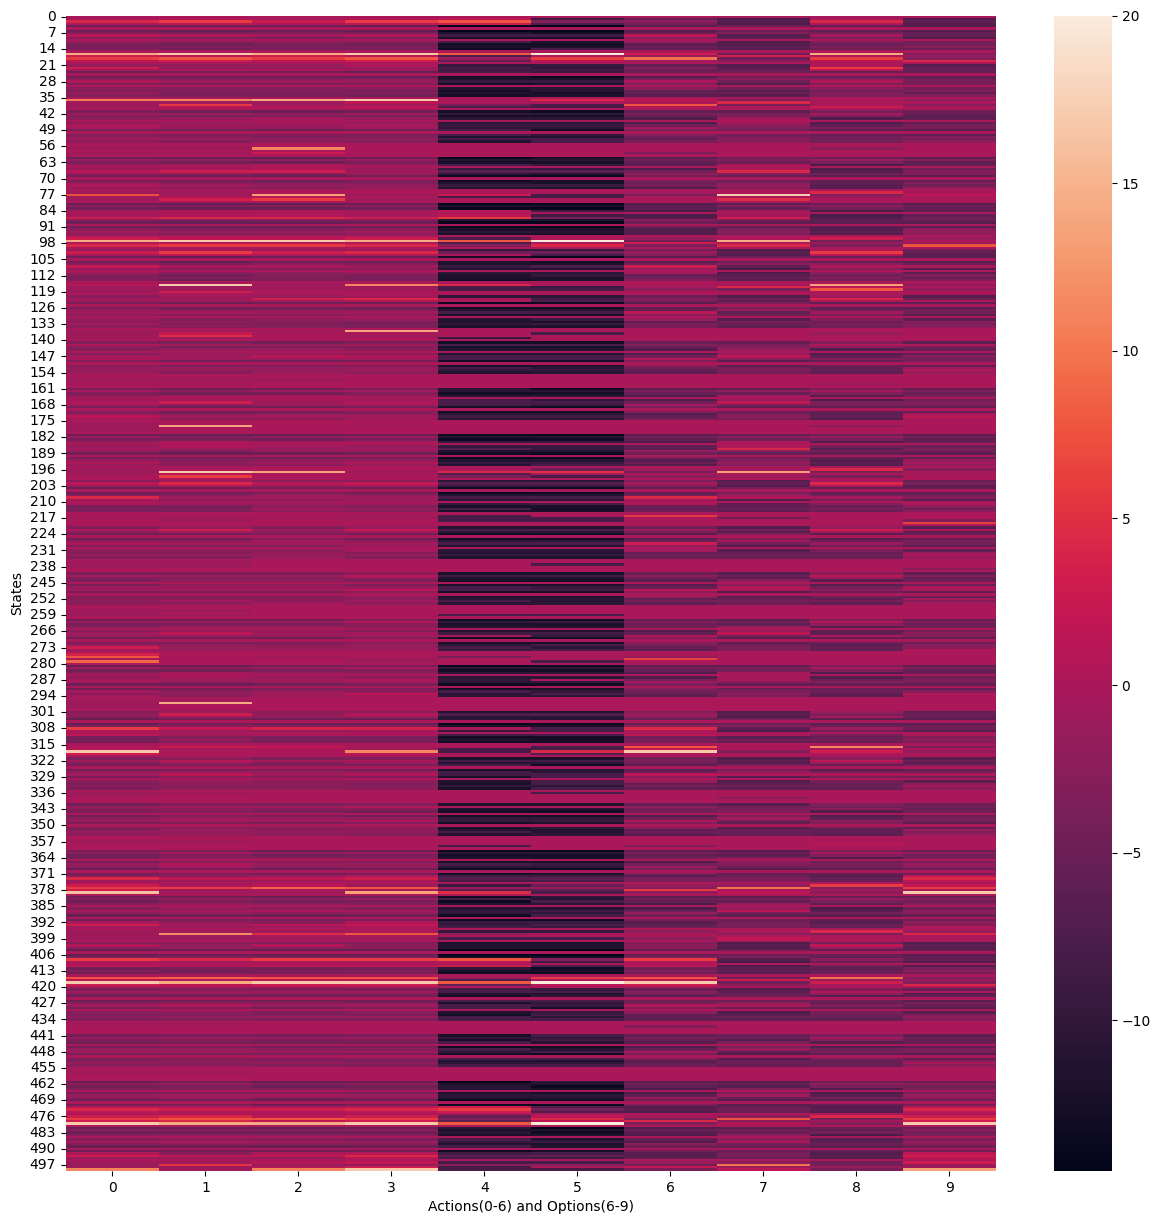

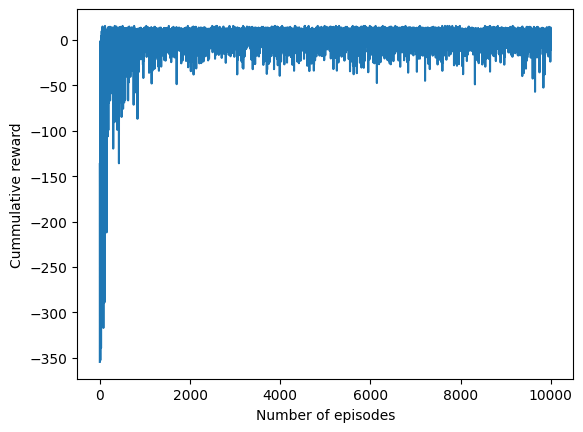

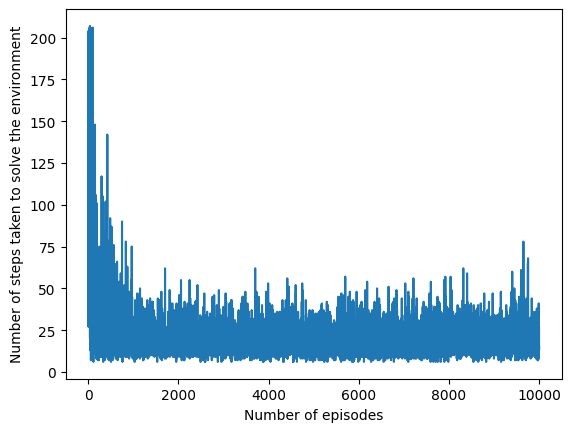

0    40
1    22
8    21
3    13
4     3
9     1
Name: 0, dtype: int64
0    38
1    27
7    20
2    11
4     3
3     1
Name: 1, dtype: int64
0    45
6    25
1    15
3    11
4     3
8     1
Name: 2, dtype: int64
0    50
9    23
2     9
1     9
3     5
4     3
8     1
Name: 3, dtype: int64
8    8
0    6
2    4
3    2
1    2
5    1
6    1
9    1
Name: 0, dtype: int64
7    7
1    7
2    5
0    2
5    1
3    1
9    1
6    1
Name: 1, dtype: int64
6    7
0    6
1    5
2    3
8    2
5    1
3    1
Name: 2, dtype: int64
0    7
9    5
2    5
1    4
8    1
7    1
5    1
3    1
Name: 3, dtype: int64


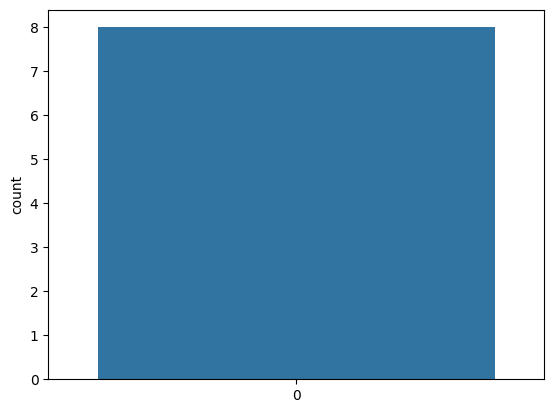

In [29]:
EP = 0.17893708108977718
LR =  0.8 	
NUM_EPISODES =  10000


mean_steps,mean_reward,Q,Update_Frequency_SMDP_q_learning = SMDP_Learning_(0.8,0.9,0.1789,10000)


arr = Q.argmax(-1)
actions = [0,1,2,3,4,5,6,7,8,9] #6-9 options in the order -> y,g,r,b
termination_dict = {6:20,7:4,8:0,9:23}
passenger_dest = {0:0, 1:4, 2:20, 3:23}

action_count_passenger = {0:[],1:[],2:[],3:[]}
action_count_destination = {0:[],1:[],2:[],3:[]}
notintaxi = []
intaxi = []
for i in range(len(arr)):
  action = arr[i]
  r,c,passenger_ind,destination = env.decode(i)
  if passenger_ind!=4:
    action_count_passenger[passenger_ind].append(action)
  if passenger_ind == 4:
    action_count_destination[destination].append(action)

  
    
df1 = pd.DataFrame(action_count_passenger)

for i in df1.columns:
  print(df1[i].value_counts())
  sns.countplot(df1[i].value_counts())
  plt.show()




df2 = pd.DataFrame(action_count_destination)

for i in df2.columns:
  print(df2[i].value_counts())
  sns.countplot(df2[i].value_counts())
  plt.show()


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    40
1    22
8    21
3    13
4     3
9     1
Name: 0, dtype: int64


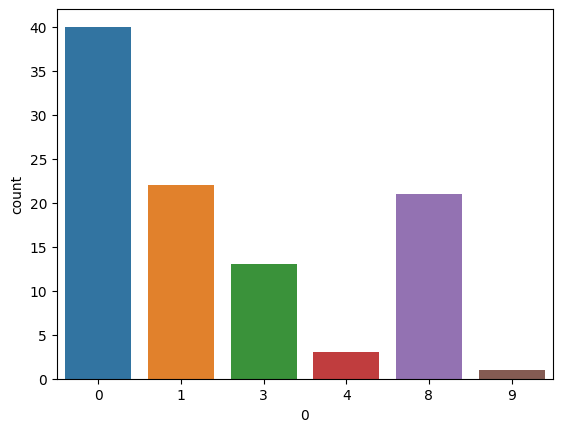

0    38
1    27
7    20
2    11
4     3
3     1
Name: 1, dtype: int64


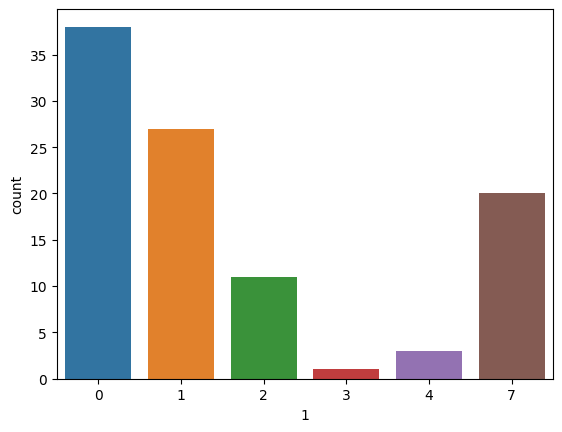

0    45
6    25
1    15
3    11
4     3
8     1
Name: 2, dtype: int64


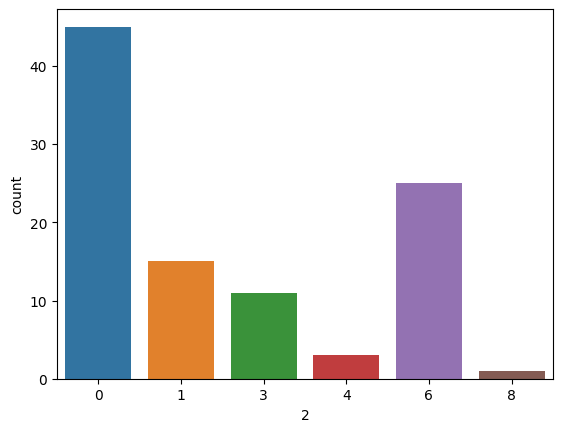

0    50
9    23
2     9
1     9
3     5
4     3
8     1
Name: 3, dtype: int64


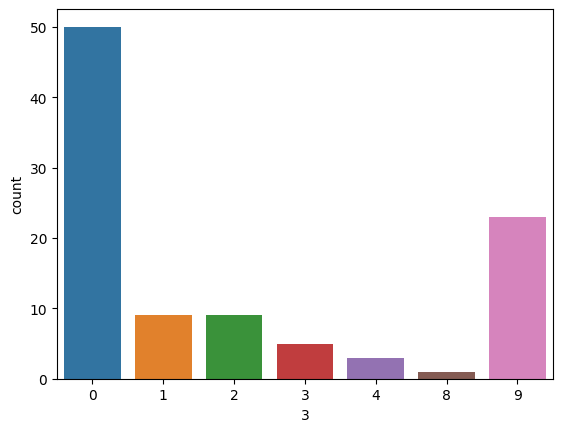

8    8
0    6
2    4
3    2
1    2
5    1
6    1
9    1
Name: 0, dtype: int64


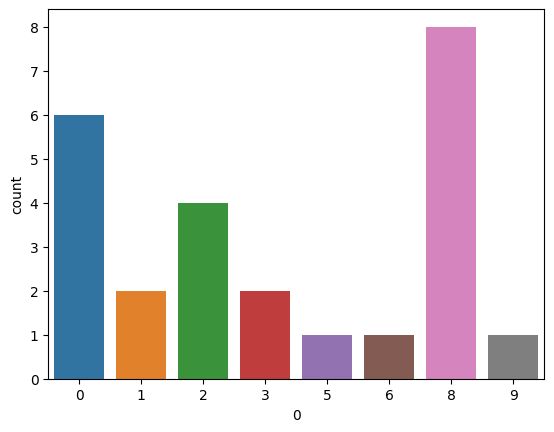

7    7
1    7
2    5
0    2
5    1
3    1
9    1
6    1
Name: 1, dtype: int64


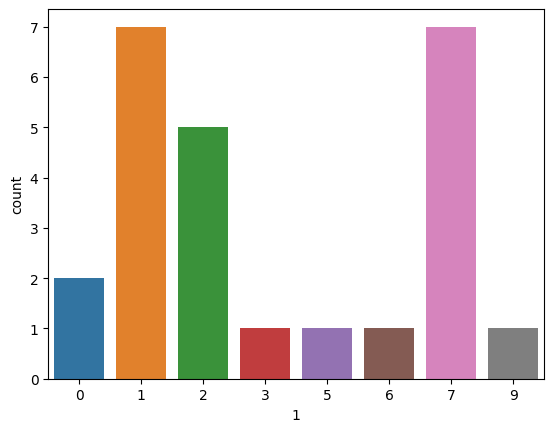

6    7
0    6
1    5
2    3
8    2
5    1
3    1
Name: 2, dtype: int64


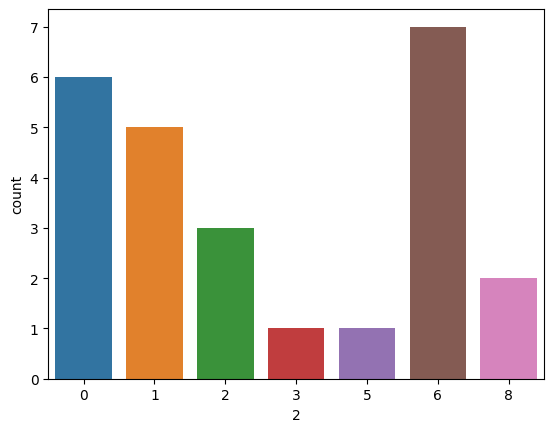

0    7
9    5
2    5
1    4
8    1
7    1
5    1
3    1
Name: 3, dtype: int64


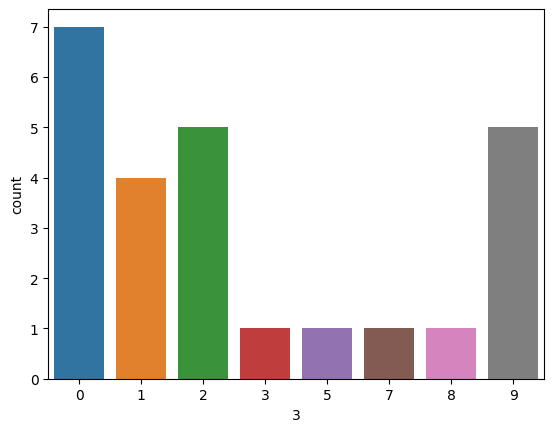

In [32]:
df1 = pd.DataFrame(action_count_passenger)

for i in df1.columns:
  print(df1[i].value_counts())
  sns.countplot(x = (df1[i]))
  plt.show()




df2 = pd.DataFrame(action_count_destination)

for i in df2.columns:
  print(df2[i].value_counts())
  sns.countplot(x = (df2[i]))
  plt.show()
